<a href="https://colab.research.google.com/github/Francesco0101/Computer-Vision-Project-on-Ground-To-Aerial-Matching/blob/main/CV_project_on_Cross_image_matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import

In [ ]:
%%capture
!pip install gdown
!pip install rarfile
!pip install datasets opencv-contrib-python opencv-python ipywidgets scipy
!pip install pytorch_lightning
!pip install transformers torch pillow matplotlib

In [1]:
import gdown
import zipfile
import os
#from google.colab.patches import cv2_imshow #rimuovere se online
import cv2
from tqdm import tqdm
import numpy as np
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pytorch_lightning as pl
import csv
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
import pytorch_lightning as pl
from torch.utils.data import random_split
import logging
from collections import OrderedDict
import torchvision
from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer
from torch import optim
from torch.utils.data.distributed import DistributedSampler
from pytorch_lightning.callbacks.progress import RichProgressBar
import matplotlib.pyplot as plt
from pytorch_lightning import seed_everything, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
import matplotlib.pyplot as plt
from transformers import AutoImageProcessor, AutoModelForDepthEstimation, Mask2FormerForUniversalSegmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2
import re

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [3]:
torch.set_float32_matmul_precision('medium') # solo in locale

In [4]:
seed_everything(42, workers=True)

Seed set to 42


42

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

ModuleNotFoundError: No module named 'google.colab'

In [5]:
cvusa_dir = 'CVUSA_subset'
csv_path = 'CVUSA_subset/file_paths.csv'

# Dataset

In [6]:
class CVUSADatasetPath(Dataset):
    def __init__(self, cvusa_dir, directory):
        self.directory = directory
        self.cvusa_dir = cvusa_dir
        self.aerial_paths = []
        self.ground_paths = []
        self.aerial_sift_paths = []
        self.ground_sift_paths = []
        self.aerial_depth_paths = []
        self.ground_depth_paths = []
        self.aerial_segmap_paths = []
        self.ground_segmap_paths = []

        with open(self.directory, mode='r') as file:
          csv_reader = csv.reader(file, delimiter=',')
          for row in csv_reader:
              aerial_path = row[0]
              ground_path = row[1]
              aerial_sift_path = row[2]
              ground_sift_path = row[3]
              aerial_depth_path = row[4]
              ground_depth_path = row[5]
              aerial_segmap_path = row[6]
              ground_segmap_path = row[7]

              self.aerial_paths.append(aerial_path)
              self.ground_paths.append(ground_path)
              self.aerial_sift_paths.append(aerial_sift_path)
              self.ground_sift_paths.append(ground_sift_path)
              self.aerial_depth_paths.append(aerial_depth_path)
              self.ground_depth_paths.append(ground_depth_path)
              self.aerial_segmap_paths.append(aerial_segmap_path)
              self.ground_segmap_paths.append(ground_segmap_path)

    def __len__(self):
        return len(self.aerial_paths) # any image path is good

    def __getitem__(self, idx):
        return self.ground_paths[idx], self.aerial_paths[idx], self.ground_sift_paths[idx], self.aerial_sift_paths[idx], self.ground_depth_paths[idx], self.aerial_depth_paths[idx], self.ground_segmap_paths[idx], self.aerial_segmap_paths[idx]

In [56]:
class CVUSADataset(pl.LightningDataModule):
    def __init__(self, cvusa_dir, directory, batch_size=32, transform=True):
        super().__init__()
        self.batch_size = batch_size
        self.cvusa_dir = cvusa_dir
        self.directory = directory
        self.transformation = transform

    def setup(self, stage=None):
        self.dataset = CVUSADatasetPath(self.cvusa_dir, self.directory)
        dataset_length = len(self.dataset)
        # Calculate split indices
        train_end = int(0.8 * dataset_length)
        val_end = train_end + int(0.1 * dataset_length)

        # Create subsets using slicing
        train_dataset = Subset(self.dataset, range(0, train_end))
        val_dataset = Subset(self.dataset, range(train_end, val_end))
        test_dataset = Subset(self.dataset, range(val_end, dataset_length))

        # Assign to self
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.test_dataset = test_dataset

    def transforms(self, set_type , aerial):
        # Define the transformation pipeline using Albumentations
        if self.transformation is False:
            return A.Compose([
                A.Resize(56, 308, interpolation=cv2.INTER_CUBIC),
                A.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0)),
                ToTensorV2(),
            ], additional_targets={
                'sift': 'image',
                'depth': 'image',
                'segmap': 'image'
            })

        if set_type == 'train':
            if aerial:
              return A.Compose([
                A.Resize(56, 308, interpolation=cv2.INTER_CUBIC),
                # New Transforms
                A.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.15, always_apply=False, p=0.5),
                A.OneOf([
                    A.AdvancedBlur(p=1.0),
                    A.Sharpen(p=1.0),
                ], p=0.3),
                A.OneOf([
                    A.GridDropout(ratio=0.5, p=1.0),
                    A.CoarseDropout(max_holes=25,
                        max_height=int(0.2*56),
                        max_width=int(0.2*56),
                        min_holes=10,
                        min_height=int(0.1*56),
                        min_width=int(0.1*56),
                        p=1.0),
                    ], p=0.3),
                ###
                A.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0)),
                ToTensorV2()
              ], additional_targets={
                  'sift': 'image',
                  'depth': 'image',
                  'segmap': 'image'
              })
            else:
              return A.Compose([
                A.Resize(56, 308, interpolation=cv2.INTER_CUBIC),
                # New Transforms
                A.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.15, always_apply=False, p=0.5),
                A.OneOf([
                    A.AdvancedBlur(p=1.0),
                    A.Sharpen(p=1.0),
                ], p=0.3),
                A.OneOf([
                    A.GridDropout(ratio=0.5, p=1.0),
                    A.CoarseDropout(max_holes=25,
                        max_height=int(0.2*56),
                        max_width=int(0.2*56),
                        min_holes=10,
                        min_height=int(0.1*56),
                        min_width=int(0.1*56),
                        p=1.0),
                    ], p=0.3),
                ###
                A.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0)),
                ToTensorV2()
              ], additional_targets={
                  'sift': 'image',
                  'depth': 'image',
                  'segmap': 'image'
              })
        else:
            return A.Compose([
                A.Resize(56, 308, interpolation=cv2.INTER_CUBIC),
                A.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0)),
                ToTensorV2(),
            ], additional_targets={
                'sift': 'image',
                'depth': 'image',
                'segmap': 'image'
            })


    def load_images_with_targets(self, paths, sift_paths, depth_paths, segmap_paths, transform=None):
        images, sift_images, depth_images, segmap_images = [], [], [], []
        #printa tutti i path

        for i in range(len(paths)):
            img = cv2.imread(paths[i])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            sift_img = cv2.imread(sift_paths[i])
            sift_img = cv2.cvtColor(sift_img, cv2.COLOR_BGR2RGB)

            depth_img = cv2.imread(depth_paths[i])
            depth_img = cv2.cvtColor(depth_img, cv2.COLOR_BGR2RGB)

            segmap_img = cv2.imread(segmap_paths[i])
            segmap_img = cv2.cvtColor(segmap_img, cv2.COLOR_BGR2RGB)

            augmented = transform(
                image=img,
                sift=sift_img,
                depth=depth_img,
                segmap=segmap_img
            )


            img = augmented['image']
            sift_img = augmented['sift']
            depth_img = augmented['depth']
            segmap_img = augmented['segmap']

            images.append(img)
            sift_images.append(sift_img)
            depth_images.append(depth_img)
            segmap_images.append(segmap_img)



        images = torch.stack(images).to(device, dtype=torch.float)
        sift_images = torch.stack(sift_images).to(device, dtype=torch.float)
        depth_images = torch.stack(depth_images).to(device, dtype=torch.float)
        segmap_images = torch.stack(segmap_images).to(device, dtype=torch.float)

        return images, sift_images, depth_images, segmap_images

    def collate_fn(self, batch, set_type):
        # Unpack batch elements
        ground_paths, aerial_paths, ground_sift_paths, aerial_sift_paths, ground_depth_paths, aerial_depth_paths, ground_segmap_paths, aerial_segmap_paths = zip(*batch)

        # Get the same transform for the entire batch
        transform_grd = self.transforms(set_type , aerial=False)
        transform_aerial = self.transforms(set_type, aerial=True)

        # Apply transformations consistently across images, sifts, depth maps, and segmaps
        ground_images, ground_sift, ground_depth, ground_segmap = self.load_images_with_targets(
            ground_paths, ground_sift_paths, ground_depth_paths, ground_segmap_paths, transform_grd
        )
        aerial_images, aerial_sift, aerial_depth, aerial_segmap = self.load_images_with_targets(
            aerial_paths, aerial_sift_paths, aerial_depth_paths, aerial_segmap_paths, transform_aerial
        )


        return ground_images, aerial_images, ground_sift, aerial_sift, ground_depth, aerial_depth, ground_segmap, aerial_segmap

    def collate_fn_train(self, batch):
        return self.collate_fn(batch, 'train')

    def collate_fn_val(self, batch):
        return self.collate_fn(batch, 'val')

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, collate_fn=self.collate_fn_train)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, collate_fn=self.collate_fn_val)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, collate_fn=self.collate_fn_val)


#Siamese Branches

###VGG

In [57]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torchvision.models import vgg16, VGG16_Weights

class SiameseNetworkVGG(nn.Module):
    def __init__(self):
        super(SiameseNetworkVGG, self).__init__()
        # only convolution
        vgg16 = models.vgg16(weights= VGG16_Weights.DEFAULT)
        self.vgg16_features = vgg16.features
        for param in self.vgg16_features[:27].parameters():
            param.requires_grad = False


        self.fc1 = nn.Linear(512 * 7 * 7, 256)  # Adjust input size based on VGG16 output (n°feature maps * (img size / 2^num max pooling)^2)

    def forward_one(self, x, sift_type= False):

        #print("x prima di vgg: ", x.size())
        # x = self.vgg16_features(x)
        x = self.vgg16_features(x)
        # print("x: ", x.size())
        x = F.adaptive_avg_pool2d(x, (7, 7))
        # print("x: ", x.size())
        # print("x dopo avg_pool: ",x.size())
        x = x.view(x.size()[0], -1)
        x = self.fc1(x)
        return x

    def forward_combined(self, input1, input2):
        grd_global = self.forward_one(input1)
        sat_global = self.forward_one(input2)
        return grd_global, sat_global

    def forward_combined_3(self, input1, input2, input3):
        grd_global = self.forward_one(input1)
        var_global = self.forward_one(input3)
        sat_global = self.forward_one(input2)
        return grd_global, sat_global , var_global


    def forward_combined_4(self, input1, input2, input3, input4):
        grd_global = self.forward_one(input1)
        sat_global = self.forward_one(input2)
        grd_global2 = self.forward_one(input3)
        sat_global2 = self.forward_one(input4)
        return grd_global, sat_global, grd_global2, sat_global2

    def forward_combined_6(self, input1, input2, input3, input4, input5, input6):
        grd_global = self.forward_one(input1)
        sat_global = self.forward_one(input2)
        grd_global3 = self.forward_one(input5)
        sat_global3 = self.forward_one(input6)
        grd_global2 = self.forward_one(input3)
        sat_global2 = self.forward_one(input4)
        return grd_global, sat_global, grd_global2, sat_global2 , grd_global3, sat_global3

    def forward_combined_8(self, input1, input2, input3, input4, input5, input6, input7, input8):
        grd_global = self.forward_one(input1)
        sat_global = self.forward_one(input2)
        grd_global3 = self.forward_one(input5)
        sat_global3 = self.forward_one(input6)
        grd_global2 = self.forward_one(input3)
        sat_global2 = self.forward_one(input4)
        grd_global4 = self.forward_one(input7)
        sat_global4 = self.forward_one(input8)

        return grd_global, sat_global, grd_global2, sat_global2 , grd_global3, sat_global3 , grd_global4, sat_global4

##RESNET BRANCH

In [68]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50, ResNet50_Weights

class SiameseNetworkRESNET(nn.Module):
    def __init__(self):
        super(SiameseNetworkRESNET, self).__init__()

        # Load the pretrained ResNet-50 model with the best available weights
        self.resnet = resnet50(weights=ResNet50_Weights.DEFAULT)
        i=0

        for pram in self.resnet.children():
          i+=1
          if i < 7:
            for param in pram.parameters():
              param.requires_grad = False

        #self.fc1 = nn.Linear(1000, 256)

    def forward_one(self, x):
        x = self.resnet(x)
        #x = x.view(x.size()[0], -1)
        #x = self.fc1(x)

        return x

    def forward_combined(self, input1, input2):
        grd_global = self.forward_one(input1)

        sat_global = self.forward_one(input2)

        return grd_global, sat_global

    def forward_combined_3(self, input1, input2, input3):
        grd_global = self.forward_one(input1)
        var_global = self.forward_one(input3)
        sat_global = self.forward_one(input2)

        return grd_global, sat_global , var_global

    def forward_combined_4(self, input1, input2, input3, input4):
        grd_global = self.forward_one(input1)
        sat_global = self.forward_one(input2)

        grd_global2 = self.forward_one(input3)
        sat_global2 = self.forward_one(input4)
        return grd_global, sat_global, grd_global2, sat_global2

    def forward_combined_6(self, input1, input2, input3, input4, input5, input6):
        grd_global = self.forward_one(input1)
        sat_global = self.forward_one(input2)
        grd_global3 = self.forward_one(input5)
        sat_global3 = self.forward_one(input6)
        grd_global2 = self.forward_one(input3)
        sat_global2 = self.forward_one(input4)
        return grd_global, sat_global, grd_global2, sat_global2 , grd_global3, sat_global3

    def forward_combined_8(self, input1, input2, input3, input4, input5, input6, input7, input8):
        grd_global = self.forward_one(input1)
        sat_global = self.forward_one(input2)
        grd_global3 = self.forward_one(input5)
        sat_global3 = self.forward_one(input6)
        grd_global2 = self.forward_one(input3)
        sat_global2 = self.forward_one(input4)
        grd_global4 = self.forward_one(input7)
        sat_global4 = self.forward_one(input8)

        return grd_global, sat_global, grd_global2, sat_global2 , grd_global3, sat_global3 , grd_global4, sat_global4

#LOSS AND VALIDATE

In [59]:
class SiameseLoss:
    def __init__(self, loss_weight=10.0):
        self.loss_weight = loss_weight

    def compute_loss(self, triplet_dist_g2s, triplet_dist_s2g, pair_n):
        if pair_n == 0:
          pair_n = 1
        loss_g2s = torch.sum(torch.log(1 + torch.exp(triplet_dist_g2s * self.loss_weight))) / pair_n
        loss_s2g = torch.sum(torch.log(1 + torch.exp(triplet_dist_s2g * self.loss_weight))) / pair_n
        loss = (loss_g2s + loss_s2g) / 2.0
        return loss

class ValidationMetrics:
    def __init__(self):
        pass

    @staticmethod
    def validate(grd_descriptor, sat_descriptor):
        accuracy = 0.0
        data_amount = 0.0
        dist_array = 2 - 2 * np.matmul(sat_descriptor.cpu(), np.transpose(grd_descriptor.cpu()))
        if (int(dist_array.shape[0] * 0.01) < 1 ):
          top1_percent = 1
        else:
          top1_percent = int(dist_array.shape[0] * 0.01)
        for i in range(dist_array.shape[0]):
            gt_dist = dist_array[i, i]
            prediction = torch.sum(dist_array[:, i].cpu().lt(gt_dist.cpu()))
            if prediction < top1_percent:
                accuracy += 1.0
            data_amount += 1.0
        accuracy /= data_amount
        return accuracy

    @staticmethod
    def validate_topk(grd_descriptor, sat_descriptor, k):
        accuracy_topk = 0.0
        data_amount = 0.0
        dist_array = 2 - 2 * np.matmul(sat_descriptor.cpu(), np.transpose(grd_descriptor.cpu()))
        for i in range(dist_array.shape[0]):
            gt_dist = dist_array[i, i]
            sorted_indices = torch.argsort(dist_array[:, i])
            rank = torch.where(sorted_indices == i)[0].item()
            if rank < k:
                accuracy_topk += 1.0
            data_amount += 1.0
        accuracy_topk /= data_amount
        return accuracy_topk


# DUAL NETWORK (SIAMESE-LIKE OR NOT)

In [60]:
class SiameseDualNetworkLightning(pl.LightningModule):
    def __init__(self, learning_rate=1e-5, branch = "VGG", combined = True):
        super(SiameseDualNetworkLightning, self).__init__()
        self.branch = branch
        self.combined = combined
        if branch == "VGG":
          if self.combined:
            self.model1 = SiameseNetworkVGG()
          else:
            self.model1 = SiameseNetworkVGG()
            self.model2 = SiameseNetworkVGG()
        elif branch == "RESNET":
          if self.combined:
            self.model1 = SiameseNetworkRESNET()
          else:
            self.model1 = SiameseNetworkRESNET()
            self.model2 = SiameseNetworkRESNET()
        else:
          raise ValueError("Branch must be either 'VGG' or 'RESNET'")

        self.learning_rate = learning_rate
        self.loss_calculator = SiameseLoss()
        self.validator = ValidationMetrics()

    #deve sempre essere uguale a quella definita in cvusadataset
    def transform(self):
      transform = transforms.Compose([
          # transforms.Resize((224, 224)),
          transforms.ToTensor(),
          transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))
      ])

      return transform


    def forward(self, ground, aerial):
        grd_global = None
        sat_global = None

        if self.combined:
          grd_global, sat_global = self.model1.forward_combined(ground, aerial)
        else:
          grd_global  = self.model1.forward_one(ground)
          sat_global  = self.model2.forward_one(aerial)
        grd_global = F.normalize(grd_global, dim=1)
        sat_global = F.normalize(sat_global, dim=1)
        #print("grd_global: ", grd_global)
        #print("sat_global: ", sat_global)

        dist_matrix = 2 - 2 * torch.matmul(sat_global, grd_global.t())
        #print("dist_matrix: ",dist_matrix)
        pos_dist = torch.diag(dist_matrix)

        batch_size = sat_global.size(0)
        #print("batch_size: ",batch_size)

        pair_n = batch_size * (batch_size - 1.0)

        # ground to satellite
        triplet_dist_g2s = pos_dist - dist_matrix

        # satellite to ground
        triplet_dist_s2g = pos_dist.unsqueeze(1) - dist_matrix

        #print("triplet_dist_g2s: ", triplet_dist_g2s)
        #print("triplet_dist_s2g: ", triplet_dist_s2g)

        return triplet_dist_g2s, triplet_dist_s2g, pair_n, grd_global, sat_global

    def training_step(self, batch, batch_idx):
      grd, sat, _ , _ , _, _, _, _= batch
      # print("batch id: ", batch_idx)
      dist_g2s , dist_s2g , pair_n , grd_global , sat_global = self.forward(grd ,sat)
      loss_train = self.loss_calculator.compute_loss(dist_g2s, dist_s2g, pair_n)
      self.log('train_loss', loss_train, on_step=True, on_epoch=True, prog_bar=True )
      tqdm_dict = OrderedDict({"loss_train": loss_train})
      output = {"loss": loss_train, "progress_bar": tqdm_dict, "log": tqdm_dict}
      return output

    def validation_step(self, batch, batch_idx):
        grd, sat, _ , _ , _, _, _, _= batch
        dist_g2s, dist_s2g, pair_n, grd_global , sat_global = self.forward(grd, sat)
        loss_val = self.loss_calculator.compute_loss(dist_g2s, dist_s2g, pair_n)
        accuracy_val = self.validator.validate(grd_global, sat_global)
        accuracy_top1 = self.validator.validate_topk(grd_global, sat_global, 1)
        accuracy_top3 = self.validator.validate_topk(grd_global, sat_global, 3)
        accuracy_top5 = self.validator.validate_topk(grd_global, sat_global, 5)
        accuracy_top8 = self.validator.validate_topk(grd_global, sat_global, 8)
        self.log('batch_size', grd.shape[0], on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_loss', loss_val, on_step=False, on_epoch=True, prog_bar=True )
        self.log('val_accuracy_top1percent', accuracy_val, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_accuracy_top1', accuracy_top1, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_accuracy_top3', accuracy_top3, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_accuracy_top5', accuracy_top5, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_accuracy_top8', accuracy_top8, on_step=False, on_epoch=True, prog_bar=True)
        output= {"val_loss": loss_val, "val_accuracy": accuracy_val}
        return output

    def test_step(self, batch, batch_idx):
        grd, sat, _ , _ , _, _, _, _= batch
        dist_g2s, dist_s2g, pair_n, grd_global, sat_global = self.forward(grd, sat)
        loss_test = self.loss_calculator.compute_loss(dist_g2s, dist_s2g, pair_n)
        accuracy_val = self.validator.validate(grd_global, sat_global)
        accuracy_top1 = self.validator.validate_topk(grd_global, sat_global, 1)
        accuracy_top3 = self.validator.validate_topk(grd_global, sat_global, 3)
        accuracy_top5 = self.validator.validate_topk(grd_global, sat_global, 5)
        accuracy_top8 = self.validator.validate_topk(grd_global, sat_global, 8)
        self.log('batch_size', grd.shape[0], on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_loss', loss_test, on_step=False, on_epoch=True, prog_bar=True )
        self.log('test_accuracy_top1percent', accuracy_val, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_accuracy_top1', accuracy_top1, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_accuracy_top3', accuracy_top3, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_accuracy_top5', accuracy_top5, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_accuracy_top8', accuracy_top8, on_step=False, on_epoch=True, prog_bar=True)
        return {"test_loss": loss_test, "test_accuracy": accuracy_val}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer


# QUAD NETWORK (SIAMESE-LIKE OR NOT)

In [61]:
class SiameseQuadNetworkLightning(pl.LightningModule):
    def __init__(self, learning_rate=1e-5, branch = "VGG", combined = 0, feature_type = 'SIFT'):
        super(SiameseQuadNetworkLightning, self).__init__()
        self.branch = branch
        self.combined = combined
        self.feature_type = feature_type
        if branch == "VGG":
          if self.combined == 0:
            self.model1 = SiameseNetworkVGG()

          elif self.combined == 1:
            self.model1 = SiameseNetworkVGG() # prende in input due cose (immagine + sift, depth, segmap) ground
            self.model2 = SiameseNetworkVGG() # prende in input due cose (immagine + sift, depth, segmap) aerial
          else:
            self.model1 = SiameseNetworkVGG() # immagine ground
            self.model2 = SiameseNetworkVGG() # immagine aerial
            self.model3 = SiameseNetworkVGG() # sift, depth, segmap ground
            self.model4 = SiameseNetworkVGG() # sift, depth, segmap aerial
        elif branch == "RESNET":
          # guardare VGG
          if self.combined == 0:
            self.model1 = SiameseNetworkRESNET()

          elif self.combined == 1:
            self.model1 = SiameseNetworkRESNET()
            self.model2 = SiameseNetworkRESNET()

          else:
            self.model1 = SiameseNetworkRESNET()
            self.model2 = SiameseNetworkRESNET()
            self.model3 = SiameseNetworkRESNET()
            self.model4 = SiameseNetworkRESNET()
        else:
          raise ValueError("Branch must be either 'VGG' or 'RESNET'")

        self.learning_rate = learning_rate
        self.loss_calculator = SiameseLoss()
        self.validator = ValidationMetrics()


    #deve sempre essere uguale a quella definita in cvusadataset (modificare quando si fa la search forse)
    def transform(self):
      transform = transforms.Compose([
          # transforms.Resize((224, 224)),
          transforms.ToTensor(),
          transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))
      ])

      return transform


    def forward(self, ground, aerial, feature_ground, feature_aerial):
        grd_global = None
        sat_global = None
        feat_aerial = None
        feat_ground = None

        if self.combined == 0:
          grd_global, sat_global, feat_ground, feat_aerial  = self.model1.forward_combined_4(ground, aerial, feature_ground, feature_aerial)

        elif self.combined == 1:
          grd_global, feat_ground = self.model1.forward_combined(ground, feature_ground)
          sat_global, feat_aerial = self.model2.forward_combined(aerial, feature_aerial)

        else:
          grd_global  = self.model1.forward_one(ground)
          sat_global  = self.model2.forward_one(aerial)
          feat_ground = self.model3.forward_one(feature_ground)
          feat_aerial = self.model4.forward_one(feature_aerial)

        # Concatenazione delle caratteristiche
        grd_global = torch.cat((grd_global, feat_ground), dim=1)
        sat_global = torch.cat((sat_global, feat_aerial), dim=1)
        grd_global = F.normalize(grd_global, dim=1)
        sat_global = F.normalize(sat_global, dim=1)

        #print("grd_global: ", grd_global)
        #print("sat_global: ", sat_global)


        dist_matrix = 2 - 2 * torch.matmul(sat_global, grd_global.t())
        #print("dist_matrix: ",dist_matrix)
        pos_dist = torch.diag(dist_matrix)

        batch_size = sat_global.size(0)
        #print("batch_size: ",batch_size)

        pair_n = batch_size * (batch_size - 1.0)

        # ground to satellite
        triplet_dist_g2s = pos_dist - dist_matrix

        # satellite to ground
        triplet_dist_s2g = pos_dist.unsqueeze(1) - dist_matrix

        #print("triplet_dist_g2s: ", triplet_dist_g2s)
        #print("triplet_dist_s2g: ", triplet_dist_s2g)

        return triplet_dist_g2s, triplet_dist_s2g, pair_n, grd_global, sat_global

    def training_step(self, batch, batch_idx):
      if self.feature_type == 'SIFT':
        grd, sat, feat_grd , feat_sat, _, _, _, _ = batch
      elif self.feature_type == 'DEPTH':
        grd, sat, _, _, feat_grd , feat_sat, _, _ = batch
      elif self.feature_type == 'SEGMAP':
        grd, sat, _, _, _, _, feat_grd , feat_sat = batch
      # print("batch id: ", batch_idx)
      dist_g2s , dist_s2g , pair_n , grd_global , sat_global = self.forward(grd , sat, feat_grd, feat_sat)

      loss_train = self.loss_calculator.compute_loss(dist_g2s, dist_s2g, pair_n)
      self.log('train_loss', loss_train, on_step=True, on_epoch=True, prog_bar=True )
      tqdm_dict = OrderedDict({"loss_train": loss_train})
      output = {"loss": loss_train, "progress_bar": tqdm_dict, "log": tqdm_dict}
      return output

    def validation_step(self, batch, batch_idx):
        if self.feature_type == 'SIFT':
          grd, sat, feat_grd , feat_sat, _, _, _, _ = batch
        elif self.feature_type == 'DEPTH':
          grd, sat, _, _, feat_grd , feat_sat, _, _ = batch
        elif self.feature_type == 'SEGMAP':
          grd, sat, _, _, _, _, feat_grd , feat_sat = batch
        # print("batch id: ", batch_idx)
        dist_g2s , dist_s2g , pair_n , grd_global , sat_global = self.forward(grd , sat, feat_grd, feat_sat)
        loss_val = self.loss_calculator.compute_loss(dist_g2s, dist_s2g, pair_n)
        # self.search(grd_global, sat_global, grd, sat, 2)
        accuracy_val = self.validator.validate(grd_global, sat_global)
        accuracy_top1 = self.validator.validate_topk(grd_global, sat_global, 1)
        accuracy_top3 = self.validator.validate_topk(grd_global, sat_global, 3)
        accuracy_top5 = self.validator.validate_topk(grd_global, sat_global, 5)
        accuracy_top8 = self.validator.validate_topk(grd_global, sat_global, 8)
        self.log('batch_size', grd.shape[0], on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_loss', loss_val, on_step=False, on_epoch=True, prog_bar=True )
        self.log('val_accuracy_top1percent', accuracy_val, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_accuracy_top1', accuracy_top1, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_accuracy_top3', accuracy_top3, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_accuracy_top5', accuracy_top5, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_accuracy_top8', accuracy_top8, on_step=False, on_epoch=True, prog_bar=True)
        output= {"val_loss": loss_val, "val_accuracy": accuracy_val}
        return output

    def test_step(self, batch, batch_idx):
        if self.feature_type == 'SIFT':
          grd, sat, feat_grd , feat_sat, _, _, _, _ = batch
        elif self.feature_type == 'DEPTH':
          grd, sat, _, _, feat_grd , feat_sat, _, _ = batch
        elif self.feature_type == 'SEGMAP':
          grd, sat, _, _, _, _, feat_grd , feat_sat = batch
        # print("batch id: ", batch_idx)
        dist_g2s , dist_s2g , pair_n , grd_global , sat_global = self.forward(grd , sat, feat_grd, feat_sat)
        loss_test = self.loss_calculator.compute_loss(dist_g2s, dist_s2g, pair_n)
        accuracy_val = self.validator.validate(grd_global, sat_global)
        accuracy_top1 = self.validator.validate_topk(grd_global, sat_global, 1)
        accuracy_top3 = self.validator.validate_topk(grd_global, sat_global, 3)
        accuracy_top5 = self.validator.validate_topk(grd_global, sat_global, 5)
        accuracy_top8 = self.validator.validate_topk(grd_global, sat_global, 8)
        self.log('batch_size', grd.shape[0], on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_loss', loss_test, on_step=False, on_epoch=True, prog_bar=True )
        self.log('test_accuracy_top1percent', accuracy_val, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_accuracy_top1', accuracy_top1, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_accuracy_top3', accuracy_top3, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_accuracy_top5', accuracy_top5, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_accuracy_top8', accuracy_top8, on_step=False, on_epoch=True, prog_bar=True)
        return {"test_loss": loss_test, "test_accuracy": accuracy_val}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer


# HEX NETWORK (SIAMESE-LIKE OR NOT)

In [62]:
class SiameseHexNetworkLightning(pl.LightningModule):
    def __init__(self, learning_rate=1e-5, branch = "VGG", combined = 0, feature_type = 'SIFT' , feature2_type = "DEPTH"):
        super(SiameseHexNetworkLightning, self).__init__()
        self.branch = branch
        self.combined = combined

        if feature2_type == "SIFT":
          self.feature_type = feature2_type
          self.feature2_type = feature_type
        else:
          self.feature_type = feature_type
          self.feature2_type = feature2_type

        if branch == "VGG":
          if self.combined == 0:
            self.model1 = SiameseNetworkVGG()

          elif self.combined == 1:
            self.model1 = SiameseNetworkVGG() # prende in input due cose (immagine + sift, depth, segmap) ground
            self.model2 = SiameseNetworkVGG() # prende in input due cose (immagine + sift, depth, segmap) aerial
          else:
            self.model1 = SiameseNetworkVGG() # immagine ground
            self.model2 = SiameseNetworkVGG() # immagine aerial
            self.model3 = SiameseNetworkVGG() # depth ground
            self.model4 = SiameseNetworkVGG() # depth aerial
            self.model5 = SiameseNetworkVGG() # seg ground
            self.model6 = SiameseNetworkVGG() # seg aerial
        elif branch == "RESNET":
          # guardare VGG
          if self.combined == 0:
            self.model1 = SiameseNetworkRESNET()

          elif self.combined == 1:
            self.model1 = SiameseNetworkRESNET()
            self.model2 = SiameseNetworkRESNET()

          else:
            self.model1 = SiameseNetworkRESNET()
            self.model2 = SiameseNetworkRESNET()
            self.model3 = SiameseNetworkRESNET()
            self.model4 = SiameseNetworkRESNET()
            self.model5 = SiameseNetworkRESNET()
            self.model6 = SiameseNetworkRESNET()
        else:
          raise ValueError("Branch must be either 'VGG' or 'RESNET'")

        self.learning_rate = learning_rate
        self.loss_calculator = SiameseLoss()
        self.validator = ValidationMetrics()


    #deve sempre essere uguale a quella definita in cvusadataset (modificare quando si fa la search forse)
    def transform(self):
      transform = transforms.Compose([
          # transforms.Resize((224, 224)),
          transforms.ToTensor(),
          transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))
      ])

      return transform

    def forward(self, ground, aerial, f1_ground, f1_aerial , f2_ground , f2_aerial):
        grd_global = None
        sat_global = None
        feat1_aerial = None
        feat1_ground = None
        feat2_aerial = None
        feat2_ground = None
        if self.combined == 0:
          grd_global, sat_global, feat1_ground, feat1_aerial , feat2_ground , feat2_aerial = self.model1.forward_combined_6(ground, aerial, f1_ground, f1_aerial, f2_ground, f2_aerial)

        elif self.combined == 1:
          grd_global, feat1_ground , feat2_ground = self.model1.forward_combined_3(ground, f1_ground, f2_ground)
          sat_global, feat1_aerial , feat2_aerial = self.model2.forward_combined_3(aerial, f1_aerial, f2_aerial)

        else:
          grd_global  = self.model1.forward_one(ground)
          sat_global  = self.model2.forward_one(aerial)
          feat1_ground = self.model3.forward_one(f1_ground)
          feat1_aerial = self.model4.forward_one(f1_aerial)
          feat2_ground = self.model5.forward_one(f2_ground)
          feat2_aerial = self.model6.forward_one(f2_aerial)

        # Concatenazione delle caratteristiche
        grd_global = torch.cat((grd_global, feat1_ground ,feat2_ground), dim=1)
        sat_global = torch.cat((sat_global, feat1_aerial, feat2_aerial), dim=1)
        grd_global = F.normalize(grd_global, dim=1)
        sat_global = F.normalize(sat_global, dim=1)

        #print("grd_global: ", grd_global)
        #print("sat_global: ", sat_global)

        dist_matrix = 2 - 2 * torch.matmul(sat_global, grd_global.t())
        #print("dist_matrix: ",dist_matrix)
        pos_dist = torch.diag(dist_matrix)

        batch_size = sat_global.size(0)
        #print("batch_size: ",batch_size)

        pair_n = batch_size * (batch_size - 1.0)

        # ground to satellite
        triplet_dist_g2s = pos_dist - dist_matrix

        # satellite to ground
        triplet_dist_s2g = pos_dist.unsqueeze(1) - dist_matrix

        #print("triplet_dist_g2s: ", triplet_dist_g2s)
        #print("triplet_dist_s2g: ", triplet_dist_s2g)

        return triplet_dist_g2s, triplet_dist_s2g, pair_n, grd_global, sat_global

    def training_step(self, batch, batch_idx):

      if self.feature_type == "SIFT" and self.feature2_type == "DEPTH" or self.feature_type == "DEPTH" and self.feature2_type == "SIFT":
        grd, sat, feat1_ground, feat1_aerial, feat2_ground, feat2_aerial, _, _ = batch

      elif self.feature_type == "SIFT" and self.feature2_type == "SEGMAP" or self.feature_type == "SEGMAP" and self.feature2_type == "SIFT":
        grd, sat, feat1_ground, feat1_aerial, _, _, feat2_ground, feat2_aerial = batch

      elif self.feature_type == "DEPTH" and self.feature2_type == "SEGMAP" or self.feature_type == "SEGMAP" and self.feature2_type == "DEPTH":
        grd, sat, _, _, feat1_ground, feat1_aerial, feat2_ground, feat2_aerial = batch


      # print("batch id: ", batch_idx)
      dist_g2s , dist_s2g , pair_n , grd_global , sat_global = self.forward(grd , sat, feat1_ground, feat1_aerial , feat2_ground , feat2_aerial)

      loss_train = self.loss_calculator.compute_loss(dist_g2s, dist_s2g, pair_n)
      self.log('train_loss', loss_train, on_step=True, on_epoch=True, prog_bar=True )
      tqdm_dict = OrderedDict({"loss_train": loss_train})
      output = {"loss": loss_train, "progress_bar": tqdm_dict, "log": tqdm_dict}
      return output

    def validation_step(self, batch, batch_idx):

        if self.feature_type == "SIFT" and self.feature2_type == "DEPTH" or self.feature_type == "DEPTH" and self.feature2_type == "SIFT":
          grd, sat, feat1_ground, feat1_aerial, feat2_ground, feat2_aerial, _, _ = batch

        elif self.feature_type == "SIFT" and self.feature2_type == "SEGMAP" or self.feature_type == "SEGMAP" and self.feature2_type == "SIFT":
          grd, sat, feat1_ground, feat1_aerial, _, _, feat2_ground, feat2_aerial = batch

        elif self.feature_type == "DEPTH" and self.feature2_type == "SEGMAP" or self.feature_type == "SEGMAP" and self.feature2_type == "DEPTH":
          grd, sat, _, _, feat1_ground, feat1_aerial, feat2_ground, feat2_aerial = batch


        # print("batch id: ", batch_idx)
        dist_g2s , dist_s2g , pair_n , grd_global , sat_global = self.forward(grd , sat, feat1_ground, feat1_aerial , feat2_ground , feat2_aerial)
        loss_val = self.loss_calculator.compute_loss(dist_g2s, dist_s2g, pair_n)
        # self.search(grd_global, sat_global, grd, sat, 2)
        accuracy_val = self.validator.validate(grd_global, sat_global)
        accuracy_top1 = self.validator.validate_topk(grd_global, sat_global, 1)
        accuracy_top3 = self.validator.validate_topk(grd_global, sat_global, 3)
        accuracy_top5 = self.validator.validate_topk(grd_global, sat_global, 5)
        accuracy_top8 = self.validator.validate_topk(grd_global, sat_global, 8)
        self.log('batch_size', grd.shape[0], on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_loss', loss_val, on_step=False, on_epoch=True, prog_bar=True )
        self.log('val_accuracy_top1percent', accuracy_val, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_accuracy_top1', accuracy_top1, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_accuracy_top3', accuracy_top3, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_accuracy_top5', accuracy_top5, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_accuracy_top8', accuracy_top8, on_step=False, on_epoch=True, prog_bar=True)
        output= {"val_loss": loss_val, "val_accuracy": accuracy_val}
        return output

    def test_step(self, batch, batch_idx):

        if self.feature_type == "SIFT" and self.feature2_type == "DEPTH" or self.feature_type == "DEPTH" and self.feature2_type == "SIFT":
          grd, sat, feat1_ground, feat1_aerial, feat2_ground, feat2_aerial, _, _ = batch

        elif self.feature_type == "SIFT" and self.feature2_type == "SEGMAP" or self.feature_type == "SEGMAP" and self.feature2_type == "SIFT":
          grd, sat, feat1_ground, feat1_aerial, _, _, feat2_ground, feat2_aerial = batch

        elif self.feature_type == "DEPTH" and self.feature2_type == "SEGMAP" or self.feature_type == "SEGMAP" and self.feature2_type == "DEPTH":
          grd, sat, _, _, feat1_ground, feat1_aerial, feat2_ground, feat2_aerial = batch


        # print("batch id: ", batch_idx)
        dist_g2s , dist_s2g , pair_n , grd_global , sat_global = self.forward(grd , sat, feat1_ground, feat1_aerial , feat2_ground , feat2_aerial)
        loss_test = self.loss_calculator.compute_loss(dist_g2s, dist_s2g, pair_n)
        accuracy_val = self.validator.validate(grd_global, sat_global)
        accuracy_top1 = self.validator.validate_topk(grd_global, sat_global, 1)
        accuracy_top3 = self.validator.validate_topk(grd_global, sat_global, 3)
        accuracy_top5 = self.validator.validate_topk(grd_global, sat_global, 5)
        accuracy_top8 = self.validator.validate_topk(grd_global, sat_global, 8)
        self.log('batch_size', grd.shape[0], on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_loss', loss_test, on_step=False, on_epoch=True, prog_bar=True )
        self.log('test_accuracy_top1percent', accuracy_val, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_accuracy_top1', accuracy_top1, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_accuracy_top3', accuracy_top3, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_accuracy_top5', accuracy_top5, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_accuracy_top8', accuracy_top8, on_step=False, on_epoch=True, prog_bar=True)
        return {"test_loss": loss_test, "test_accuracy": accuracy_val}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer


# OCTA NETWORK (SIAMESE-LIKE OR NOT)

In [63]:
class SiameseOctaNetworkLightning(pl.LightningModule):
    def __init__(self, learning_rate=1e-5, branch = "VGG", combined = 0):
        super(SiameseOctaNetworkLightning, self).__init__()
        self.branch = branch
        self.combined = combined

        if branch == "VGG":
          if self.combined == 0:
            self.model1 = SiameseNetworkVGG()

          elif self.combined == 1:
            self.model1 = SiameseNetworkVGG() # prende in input due cose (immagine + sift, depth, segmap) ground
            self.model2 = SiameseNetworkVGG() # prende in input due cose (immagine + sift, depth, segmap) aerial
          else:
            self.model1 = SiameseNetworkVGG() # immagine ground
            self.model2 = SiameseNetworkVGG() # immagine aerial
            self.model3 = SiameseNetworkVGG() # siftground
            self.model4 = SiameseNetworkVGG() # siftaerial
            self.model5 = SiameseNetworkVGG() # depth ground
            self.model6 = SiameseNetworkVGG() # depth aerial
            self.model7 = SiameseNetworkVGG() # seg ground
            self.model8 = SiameseNetworkVGG() # seg aerial
        elif branch == "RESNET":
          # guardare VGG
          if self.combined == 0:
            self.model1 = SiameseNetworkRESNET()

          elif self.combined == 1:
            self.model1 = SiameseNetworkRESNET()
            self.model2 = SiameseNetworkRESNET()

          else:
            self.model1 = SiameseNetworkRESNET()
            self.model2 = SiameseNetworkRESNET()
            self.model3 = SiameseNetworkRESNET()
            self.model4 = SiameseNetworkRESNET()
            self.model5 = SiameseNetworkRESNET()
            self.model6 = SiameseNetworkRESNET()
            self.model7 = SiameseNetworkRESNET()
            self.model8 = SiameseNetworkRESNET()
        else:
          raise ValueError("Branch must be either 'VGG' or 'RESNET'")

        self.learning_rate = learning_rate
        self.loss_calculator = SiameseLoss()
        self.validator = ValidationMetrics()


    #deve sempre essere uguale a quella definita in cvusadataset (modificare quando si fa la search forse)
    def transform(self):
      transform = transforms.Compose([
          # transforms.Resize((224, 224)),
          transforms.ToTensor(),
          transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))
      ])

      return transform

    def forward(self, ground, aerial, feature_ground, feature_aerial, feature_ground_2 , feature_aerial_2, feature_ground_3 , feature_aerial_3):
        grd_global = None
        sat_global = None
        feat_aerial = None
        feat_ground = None
        feat_aerial_2 = None
        feat_ground_2 = None
        feat_aerial_3 = None
        feat_ground_3 = None



        if self.combined == 0:
          grd_global, sat_global, feat_ground, feat_aerial, feat_ground_2 , feat_aerial_2, feat_ground_3 , feat_aerial_3 = self.model1.forward_combined_8(ground, aerial, feature_ground, feature_aerial, feature_ground_2, feature_aerial_2, feature_ground_3, feature_aerial_3)

        elif self.combined == 1:
          grd_global, feat_ground ,feat_ground_2 , feat_ground_3 = self.model1.forward_combined_4(ground, feature_ground, feature_ground_2, feature_ground_3)
          sat_global, feat_aerial, feat_aerial_2 , feat_aerial_3 = self.model2.forward_combined_4(aerial, feature_aerial, feature_aerial_2, feature_aerial_3)

        else:
          grd_global  = self.model1.forward_one(ground)
          sat_global  = self.model2.forward_one(aerial)

          feat_ground = self.model3.forward_one(feature_ground)
          feat_aerial = self.model4.forward_one(feature_aerial)

          feat_ground_2 = self.model5.forward_one(feature_ground_2)
          feat_aerial_2 = self.model6.forward_one(feature_aerial_2)

          feat_ground_3 = self.model7.forward_one(feature_ground_3)
          feat_aerial_3 = self.model8.forward_one(feature_aerial_3)



        # Concatenazione delle caratteristiche
        grd_global = torch.cat((grd_global, feat_ground, feat_ground_2, feat_ground_3), dim=1)
        sat_global = torch.cat((sat_global, feat_aerial, feat_aerial_2, feat_aerial_3), dim=1)
        grd_global = F.normalize(grd_global, dim=1)
        sat_global = F.normalize(sat_global, dim=1)

        #print("grd_global: ", grd_global)
        #print("sat_global: ", sat_global)

        dist_matrix = 2 - 2 * torch.matmul(sat_global, grd_global.t())
        #print("dist_matrix: ",dist_matrix)
        pos_dist = torch.diag(dist_matrix)

        batch_size = sat_global.size(0)
        #print("batch_size: ",batch_size)

        pair_n = batch_size * (batch_size - 1.0)

        # ground to satellite
        triplet_dist_g2s = pos_dist - dist_matrix

        # satellite to ground
        triplet_dist_s2g = pos_dist.unsqueeze(1) - dist_matrix

        #print("triplet_dist_g2s: ", triplet_dist_g2s)
        #print("triplet_dist_s2g: ", triplet_dist_s2g)

        return triplet_dist_g2s, triplet_dist_s2g, pair_n, grd_global, sat_global

    def training_step(self, batch, batch_idx):

      grd, sat, feat_grd, feat_sat, feat_grd_2, feat_sat_2, feat_grd_3, feat_sat_3 = batch
      # print("batch id: ", batch_idx)
      dist_g2s , dist_s2g , pair_n , grd_global , sat_global = self.forward(grd , sat, feat_grd, feat_sat, feat_grd_2, feat_sat_2, feat_grd_3, feat_sat_3)

      loss_train = self.loss_calculator.compute_loss(dist_g2s, dist_s2g, pair_n)
      self.log('train_loss', loss_train, on_step=True, on_epoch=True, prog_bar=True )
      tqdm_dict = OrderedDict({"loss_train": loss_train})
      output = {"loss": loss_train, "progress_bar": tqdm_dict, "log": tqdm_dict}
      return output

    def validation_step(self, batch, batch_idx):

        grd, sat, feat_grd, feat_sat, feat_grd_2, feat_sat_2, feat_grd_3, feat_sat_3 = batch
        # print("batch id: ", batch_idx)
        dist_g2s , dist_s2g , pair_n , grd_global , sat_global = self.forward(grd , sat, feat_grd, feat_sat, feat_grd_2, feat_sat_2, feat_grd_3, feat_sat_3)
        loss_val = self.loss_calculator.compute_loss(dist_g2s, dist_s2g, pair_n)
        # self.search(grd_global, sat_global, grd, sat, 2)
        accuracy_val = self.validator.validate(grd_global, sat_global)
        accuracy_top1 = self.validator.validate_topk(grd_global, sat_global, 1)
        accuracy_top3 = self.validator.validate_topk(grd_global, sat_global, 3)
        accuracy_top5 = self.validator.validate_topk(grd_global, sat_global, 5)
        accuracy_top8 = self.validator.validate_topk(grd_global, sat_global, 8)
        self.log('batch_size', grd.shape[0], on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_loss', loss_val, on_step=False, on_epoch=True, prog_bar=True )
        self.log('val_accuracy_top1percent', accuracy_val, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_accuracy_top1', accuracy_top1, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_accuracy_top3', accuracy_top3, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_accuracy_top5', accuracy_top5, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_accuracy_top8', accuracy_top8, on_step=False, on_epoch=True, prog_bar=True)
        output= {"val_loss": loss_val, "val_accuracy": accuracy_val}
        return output

    def test_step(self, batch, batch_idx):

        grd, sat, feat_grd, feat_sat, feat_grd_2, feat_sat_2, feat_grd_3, feat_sat_3 = batch
        # print("batch id: ", batch_idx)
        dist_g2s , dist_s2g , pair_n , grd_global , sat_global = self.forward(grd , sat, feat_grd, feat_sat, feat_grd_2, feat_sat_2, feat_grd_3, feat_sat_3)
        loss_test = self.loss_calculator.compute_loss(dist_g2s, dist_s2g, pair_n)
        accuracy_val = self.validator.validate(grd_global, sat_global)
        accuracy_top1 = self.validator.validate_topk(grd_global, sat_global, 1)
        accuracy_top3 = self.validator.validate_topk(grd_global, sat_global, 3)
        accuracy_top5 = self.validator.validate_topk(grd_global, sat_global, 5)
        accuracy_top8 = self.validator.validate_topk(grd_global, sat_global, 8)
        self.log('batch_size', grd.shape[0], on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_loss', loss_test, on_step=False, on_epoch=True, prog_bar=True )
        self.log('test_accuracy_top1percent', accuracy_val, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_accuracy_top1', accuracy_top1, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_accuracy_top3', accuracy_top3, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_accuracy_top5', accuracy_top5, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_accuracy_top8', accuracy_top8, on_step=False, on_epoch=True, prog_bar=True)
        return {"test_loss": loss_test, "test_accuracy": accuracy_test}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer


#SEARCH

In [71]:
class ImageSearcher:
    def __init__(self, model, device):
        self.model = model.to(device)
        self.device = device
        self.transform = A.Compose([
                  A.Resize(56, 308, interpolation=cv2.INTER_LINEAR_EXACT),
                  # A.HorizontalFlip(p=0.2),
                  # A.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1, p=0.2),
                  A.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0)),
                  ToTensorV2(),
        ]
        )
        self.model.eval()

    def search(self, data_module, pos, n=5, batch_size=8):
        grd_global = None
        sat_global = None

        # Load and preprocess the ground image
        grd_path = data_module.dataset[pos][0]
        grd_image = cv2.imread(grd_path)
        grd_image = Image.fromarray(cv2.cvtColor(grd_image, cv2.COLOR_BGR2RGB))
        grd_tensor = self.transform(grd_image).unsqueeze(0).to(self.device, dtype=torch.float)

        # Prepare satellite image paths for batch processing
        other_sat_paths = [data_module.dataset[i][1] for i in range(len(data_module.dataset))]
        sat_search = []
        num_batches = len(other_sat_paths) // batch_size + (1 if len(other_sat_paths) % batch_size != 0 else 0)
        all_sat_global = []


        with torch.no_grad():
          for batch_idx in tqdm(range(num_batches)):
              start_idx = batch_idx * batch_size
              # if (start_idx > 32):
              #   break
              end_idx = min((batch_idx + 1) * batch_size, len(other_sat_paths))
              batch_sat_paths = other_sat_paths[start_idx:end_idx]

              batch_sat_search = []
              for sat_path in batch_sat_paths:
                  sat_image = cv2.imread(sat_path)
                  sat_image = Image.fromarray(cv2.cvtColor(sat_image, cv2.COLOR_BGR2RGB))
                  sat_tensor = self.transform(sat_image).unsqueeze(0).to(self.device, dtype=torch.float)
                  batch_sat_search.append(sat_tensor)

              batch_sat_search = torch.cat(batch_sat_search)

              # Forward pass based on model type
              if self.model.__class__.__name__ == "SiameseDualNetworkLightning":

                  _, _, _, grd_global, sat_global_batch = self.model.forward(grd_tensor, batch_sat_search)

              elif self.model.__class__.__name__ == "SiameseQuadNetworkLightning":
                  print('SiameseQuad')
                  index = {"SIFT": 2, "DEPTH": 4, "SEGMAP": 6}[self.model.feature_type]

                  grd_feature_path = data_module.dataset[pos][index]
                  other_sat_features_paths = [data_module.dataset[i][index + 1] for i in range(start_idx, end_idx)]

                  grd_feature_tensor = self._load_feature_tensor(grd_feature_path, index)
                  other_sat_features_tensors = self._load_feature_tensors(other_sat_features_paths, index)
                  _, _, _, grd_global, sat_global_batch = self.model.forward(
                      grd_tensor, batch_sat_search, grd_feature_tensor, other_sat_features_tensors
                  )

              elif self.model.__class__.__name__ == "SiameseHexNetworkLightning":

                  feature1_index = {"SIFT": 2, "DEPTH": 4, "SEGMAP": 6}[self.model.feature_type]
                  feature2_index = {"SIFT": 2, "DEPTH": 4, "SEGMAP": 6}[self.model.feature2_type]

                  grd_feature1_path = data_module.dataset[pos][feature1_index]
                  grd_feature2_path = data_module.dataset[pos][feature2_index]

                  other_sat_feature1_paths = [data_module.dataset[i][feature1_index + 1] for i in range(start_idx, end_idx)]
                  other_sat_feature2_paths = [data_module.dataset[i][feature2_index + 1] for i in range(start_idx, end_idx)]

                  grd_feature1_tensor = self._load_feature_tensor(grd_feature1_path, feature1_index)
                  other_sat_feature1_tensors = self._load_feature_tensors(other_sat_feature1_paths, feature1_index)

                  grd_feature2_tensor = self._load_feature_tensor(grd_feature2_path, feature2_index)
                  other_sat_feature2_tensors = self._load_feature_tensors(other_sat_feature2_paths, feature2_index)

                  _, _, _, grd_global, sat_global_batch = self.model.forward(
                      grd_tensor, batch_sat_search, grd_feature1_tensor, other_sat_feature1_tensors,
                      grd_feature2_tensor, other_sat_feature2_tensors
                  )

              elif self.model.__class__.__name__ == "SiameseOctaNetworkLightning":

                  feature1_index = 2
                  feature2_index = 4
                  feature3_index = 6

                  grd_feature1_path = data_module.dataset[pos][feature1_index]
                  grd_feature2_path = data_module.dataset[pos][feature2_index]
                  grd_feature3_path = data_module.dataset[pos][feature3_index]

                  other_sat_feature1_paths = [data_module.dataset[i][feature1_index + 1] for i in range(start_idx, end_idx)]
                  other_sat_feature2_paths = [data_module.dataset[i][feature2_index + 1] for i in range(start_idx, end_idx)]
                  other_sat_feature3_paths = [data_module.dataset[i][feature3_index + 1] for i in range(start_idx, end_idx)]

                  grd_feature1_tensor = CVUSADataset.load_sift(grd_feature1_path, 2)
                  other_sat_feature1_tensors = CVUSADataset.load_sift(other_sat_feature1_paths, 2)

                  grd_feature2_tensor = self._load_feature_tensor(grd_feature2_path, 4)
                  other_sat_feature2_tensors = self._load_feature_tensors(other_sat_feature2_paths, 4)

                  grd_feature3_tensor = self._load_feature_tensor(grd_feature3_path, 6)
                  other_sat_feature3_tensors = self._load_feature_tensors(other_sat_feature3_paths, 6)

                  _, _, _, grd_global, sat_global_batch = self.model.forward(
                      grd_tensor, batch_sat_search, grd_feature1_tensor, other_sat_feature1_tensors,
                      grd_feature2_tensor, other_sat_feature2_tensors, grd_feature3_tensor, other_sat_feature3_tensors
                  )

              # Collect the global descriptors from all batches
              all_sat_global.append(sat_global_batch)

        # Concatenate all satellite global descriptors
        sat_global = torch.cat(all_sat_global)

        # Calculate distance matrix
        dist_matrix = 2 - 2 * torch.matmul(sat_global, grd_global.t())
        distances, indices = torch.topk(dist_matrix.squeeze(), n, largest=False)

        # Plot results
        plt.figure(figsize=(5, 10 + n))  # Adjust dimensions for a long column
        plt.subplot(n + 1, 1, 1)  # One column, (n+1) rows
        plt.imshow(grd_image)
        plt.title("Original Image")
        plt.axis('off')

        for i, idx in enumerate(indices.tolist(), start=1):
            img_closest = cv2.imread(other_sat_paths[idx])
            img_closest = cv2.cvtColor(img_closest, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            plt.subplot(n + 1, 1, i + 1)  # One column, (n+1) rows
            title = f"Close image {idx} with distance {distances[i-1]:.5f}"
            plt.imshow(img_closest)
            plt.title(title)
            plt.axis('off')

        plt.tight_layout()
        plt.show()

        return dist_matrix, indices.tolist()

    def _load_feature_tensor(self, feature_path, index):
        """Helper method to load and transform a feature tensor."""

        feature_image = cv2.imread(feature_path)
        feature_image = Image.fromarray(cv2.cvtColor(feature_image, cv2.COLOR_BGR2RGB))
        # numpy array
        feature_image = np.array(feature_image)
        feature_tensor = self.transform(image=feature_image)['image'].unsqueeze(0).to(self.device, dtype=torch.float)
        return feature_tensor

    def _load_feature_tensors(self, feature_paths, index):
        """Helper method to load and transform multiple feature tensors."""
        feature_tensors = [self._load_feature_tensor(path, index) for path in feature_paths]
        return torch.cat(feature_tensors)



# Dataset Validator

In [72]:
class DatasetValidator:
    def __init__(self, model, device, data_module):
        self.model = model.to(device)
        self.device = device
        self.data_module = data_module
        self.image_searcher = ImageSearcher(model, device)
        self.validator = ValidationMetrics()
        self.model.eval()

    def validate_dataset(self, dataset_type='test'):
        if dataset_type == 'train':
            dataset = self.data_module.train_dataset
        elif dataset_type == 'validation':
            dataset = self.data_module.val_dataset
        elif dataset_type == 'test':
            dataset = self.data_module.test_dataset
        else:
            raise ValueError("dataset_type must be 'train', 'validation', or 'test'")

        grd_descriptors = []
        sat_descriptors = []
        print(self.model.__class__.__name__)
        for i in tqdm(range(len(dataset))):
            grd_path = dataset[i][0]
            sat_path = dataset[i][1]

            grd_image = cv2.imread(grd_path)
            grd_image = Image.fromarray(cv2.cvtColor(grd_image, cv2.COLOR_BGR2RGB))
            grd_image = np.array(grd_image)
            grd_tensor = self.image_searcher.transform(image=grd_image)['image'].unsqueeze(0).to(self.device, dtype=torch.float)

            sat_image = cv2.imread(sat_path)
            sat_image = Image.fromarray(cv2.cvtColor(sat_image, cv2.COLOR_BGR2RGB))
            sat_image = np.array(sat_image)
            sat_tensor = self.image_searcher.transform(image=sat_image)['image'].unsqueeze(0).to(self.device, dtype=torch.float)

            with torch.no_grad():
                if self.model.__class__.__name__ == "SiameseDualNetworkLightning":
                    _, _, _, grd_global, sat_global = self.model.forward(grd_tensor, sat_tensor)
                elif self.model.__class__.__name__ == "SiameseQuadNetworkLightning":
                    index = {"SIFT": 2, "DEPTH": 4, "SEGMAP": 6}[self.model.feature_type]
                    grd_feature_tensor = self.image_searcher._load_feature_tensor(dataset[i][index], index)
                    sat_feature_tensor = self.image_searcher._load_feature_tensor(dataset[i][index + 1], index)
                    _, _, _, grd_global, sat_global = self.model.forward(grd_tensor, sat_tensor, grd_feature_tensor, sat_feature_tensor)
                elif self.model.__class__.__name__ == "SiameseHexNetworkLightning":
                    feature1_index = {"SIFT": 2, "DEPTH": 4, "SEGMAP": 6}[self.model.feature_type]
                    feature2_index = {"SIFT": 2, "DEPTH": 4, "SEGMAP": 6}[self.model.feature2_type]
                    grd_feature1_tensor = self.image_searcher._load_feature_tensor(dataset[i][feature1_index], feature1_index)
                    grd_feature2_tensor = self.image_searcher._load_feature_tensor(dataset[i][feature2_index], feature2_index)
                    sat_feature1_tensor = self.image_searcher._load_feature_tensor(dataset[i][feature1_index + 1], feature1_index)
                    sat_feature2_tensor = self.image_searcher._load_feature_tensor(dataset[i][feature2_index + 1], feature2_index)
                    _, _, _, grd_global, sat_global = self.model.forward(
                        grd_tensor, sat_tensor, grd_feature1_tensor, sat_feature1_tensor, grd_feature2_tensor, sat_feature2_tensor)
                elif self.model.__class__.__name__ == "SiameseOctaNetworkLightning":
                    feature1_index = 2
                    feature2_index = 4
                    feature3_index = 6
                    grd_feature1_tensor = self.image_searcher._load_feature_tensor(dataset[i][feature1_index], feature1_index)
                    grd_feature2_tensor = self.image_searcher._load_feature_tensor(dataset[i][feature2_index], feature2_index)
                    grd_feature3_tensor = self.image_searcher._load_feature_tensor(dataset[i][feature3_index], feature3_index)
                    sat_feature1_tensor = self.image_searcher._load_feature_tensor(dataset[i][feature1_index + 1], feature1_index)
                    sat_feature2_tensor = self.image_searcher._load_feature_tensor(dataset[i][feature2_index + 1], feature2_index)
                    sat_feature3_tensor = self.image_searcher._load_feature_tensor(dataset[i][feature3_index + 1], feature3_index)
                    _, _, _, grd_global, sat_global = self.model.forward(
                        grd_tensor, sat_tensor, grd_feature1_tensor, sat_feature1_tensor, grd_feature2_tensor, sat_feature2_tensor, grd_feature3_tensor, sat_feature3_tensor)

            grd_descriptors.append(grd_global.cpu().numpy())
            sat_descriptors.append(sat_global.cpu().numpy())

        grd_descriptors = torch.tensor(np.vstack(grd_descriptors)).to(self.device)
        sat_descriptors = torch.tensor(np.vstack(sat_descriptors)).to(self.device)
        print(grd_descriptors.shape)
        print(sat_descriptors.shape)

        accuracy = self.validator.validate(grd_descriptors, sat_descriptors)
        accuracy_top1 = self.validator.validate_topk(grd_descriptors, sat_descriptors, 1)
        accuracy_top5 = self.validator.validate_topk(grd_descriptors, sat_descriptors, 5)
        accuracy_top10 = self.validator.validate_topk(grd_descriptors, sat_descriptors, 10)
        accuracy_top32 = self.validator.validate_topk(grd_descriptors, sat_descriptors, 32)

        print(f'Accuracy 1%: {accuracy * 100:.2f}%')
        print(f'Accuracy top1: {accuracy_top1 * 100:.2f}%')
        print(f'Accuracy top5: {accuracy_top5 * 100:.2f}%')
        print(f'Accuracy top10: {accuracy_top10 * 100:.2f}%')
        print(f'Accuracy top32: {accuracy_top32 * 100:.2f}%')

        return accuracy, accuracy_top1, accuracy_top5, accuracy_top10, accuracy_top32


#TRAINING Standard

In [ ]:
batch_size = 8
data_module = CVUSADataset(cvusa_dir, csv_path, batch_size, transform=False)

##DUAL

###DUAL COMBINED

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy_top1',
    mode='max',
    dirpath='drive/MyDrive/CV/CVUSA_subset/checkpoints/dual/VGG/',
    filename='best_model-VGG-combined-{epoch:02d}-{val_accuracy_top1:.2f}',
    save_top_k=1,
    save_last=True,
    save_on_train_epoch_end=True,
    verbose=True
)

early_stop_callback = EarlyStopping(
   monitor='val_accuracy_top1',
   min_delta=0.00,
   patience=2,
   verbose=True,
   mode='max'
)

model = SiameseDualNetworkLightning(branch="VGG", combined = True)
logger = TensorBoardLogger("drive/MyDrive/CV/CVUSA_subset/logs/dual/VGG/", name= model.__class__.__name__ + "combined")
trainer = pl.Trainer(
    max_epochs=10,
    logger=logger,
    callbacks=[ RichProgressBar(),  checkpoint_callback, early_stop_callback],
)

trainer.fit(model, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Missing logger folder: drive/MyDrive/CV/CVUSA_subset/logs/dual/VGG/SiameseDualNetworkLightningcombined
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name   ┃ Type              ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model1 │ SiameseNetworkVGG │ 21.1 M │ train │
└───┴────────┴───────────────────┴────────┴───────┘

Trainable params: 8.8 M                                                                                            
Non-trainable params: 12.4 M                                                                                       
Total params: 21.1 M                                                                                               
Total estimated model params size (MB): 84

Output()

Metric val_accuracy_top1 improved. New best score: 0.843
Epoch 0, global step 887: 'val_accuracy_top1' reached 0.84312 (best 0.84312), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\dual\\VGG\\best_model-VGG-combined-epoch=00-val_accuracy_top1=0.84.ckpt' as top 1
Metric val_accuracy_top1 improved by 0.034 >= min_delta = 0.0. New best score: 0.877
Epoch 1, global step 1774: 'val_accuracy_top1' reached 0.87698 (best 0.87698), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\dual\\VGG\\best_model-VGG-combined-epoch=01-val_accuracy_top1=0.88.ckpt' as top 1
Metric val_accuracy_top1 improved by 0.017 >= min_delta = 0.0. New best score: 0.894
Epoch 2, global step 2661: 'val_accuracy_top1' reached 0.89391 (best 0.89391), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\dual\\VGG\\best_model-VGG-combined-epoch=02-val_accuracy_top1=0.89.ckpt' as top 1
Metric val_accuracy_top1 improved by 0.007 >= min_delta = 0.0. New best score: 0.901
Ep

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy_top1',
    mode='max',
    dirpath='drive/MyDrive/CV/CVUSA_subset/checkpoints/dual/RESNET/',
    filename='best_model-RESNET-combined-{epoch:02d}-{val_accuracy_top1:.2f}',
    save_top_k=1,
    save_last=True,
    save_on_train_epoch_end=True,
    verbose=True
)

early_stop_callback = EarlyStopping(
   monitor='val_accuracy_top1',
   min_delta=0.00,
   patience=2,
   verbose=True,
   mode='max'
)

model = SiameseDualNetworkLightning(branch="RESNET", combined = True)
logger = TensorBoardLogger("drive/MyDrive/CV/CVUSA_subset/logs/dual/RESNET/", name= model.__class__.__name__ + "combined")
trainer = pl.Trainer(
    max_epochs=10,
    logger=logger,
    callbacks=[ RichProgressBar(),  checkpoint_callback, early_stop_callback],
)

trainer.fit(model, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Missing logger folder: drive/MyDrive/CV/CVUSA_subset/logs/dual/RESNET/SiameseDualNetworkLightningcombined
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name   ┃ Type                 ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model1 │ SiameseNetworkRESNET │ 25.8 M │ train │
└───┴────────┴──────────────────────┴────────┴───────┘

Trainable params: 24.4 M                                                                                           
Non-trainable params: 1.4 M                                                                                        
Total params: 25.8 M                                                                                               
Total estimated model params size (MB): 103

Output()

Metric val_accuracy_top1 improved. New best score: 0.467
Epoch 0, global step 887: 'val_accuracy_top1' reached 0.46727 (best 0.46727), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\dual\\RESNET\\best_model-RESNET-combined-epoch=00-val_accuracy_top1=0.47.ckpt' as top 1
Metric val_accuracy_top1 improved by 0.141 >= min_delta = 0.0. New best score: 0.608
Epoch 1, global step 1774: 'val_accuracy_top1' reached 0.60835 (best 0.60835), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\dual\\RESNET\\best_model-RESNET-combined-epoch=01-val_accuracy_top1=0.61.ckpt' as top 1
Epoch 2, global step 2661: 'val_accuracy_top1' was not in top 1
Metric val_accuracy_top1 improved by 0.069 >= min_delta = 0.0. New best score: 0.677
Epoch 3, global step 3548: 'val_accuracy_top1' reached 0.67720 (best 0.67720), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\dual\\RESNET\\best_model-RESNET-combined-epoch=03-val_accuracy_top1=0.68.ckpt' as top 1
Metri

###DUAL MODEL

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy_top1',
    mode='max',
    dirpath='drive/MyDrive/CV/CVUSA_subset/checkpoints/dual/VGG/',
    filename='best_model-VGG-{epoch:02d}-{val_accuracy_top1:.2f}',
    # every_n_train_steps=2, # test
    save_top_k=1,
    save_last=True,
    save_on_train_epoch_end=True,
    verbose=True
)

early_stop_callback = EarlyStopping(
   monitor='val_accuracy_top1',
   min_delta=0.00,
   patience=2,
   verbose=True,
   mode='max'
)

model = SiameseDualNetworkLightning(branch="VGG", combined = False)
logger = TensorBoardLogger("drive/MyDrive/CV/CVUSA_subset/logs/dual/VGG/", name= model.__class__.__name__)
trainer = pl.Trainer(
    max_epochs=10,
    logger=logger,
    callbacks=[ RichProgressBar(),  checkpoint_callback, early_stop_callback],
)

trainer.fit(model, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Missing logger folder: drive/MyDrive/CV/CVUSA_subset/logs/dual/VGG/SiameseDualNetworkLightning
C:\Users\palum\anaconda3\envs\prova\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:652: Checkpoint directory C:\drive\MyDrive\CV\CVUSA_subset\checkpoints\dual\VGG exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name   ┃ Type              ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model1 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 1 │ model2 │ SiameseNetworkVGG │ 21.1 M │ train │
└───┴────────┴───────────────────┴────────┴───────┘

Trainable params: 17.6 M                                                                                           
Non-trainable params: 24.7 M                                                                                       
Total params: 42.3 M                                                                                               
Total estimated model params size (MB): 169

Output()

Metric val_accuracy_top1 improved. New best score: 0.833
Epoch 0, global step 887: 'val_accuracy_top1' reached 0.83296 (best 0.83296), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\dual\\VGG\\best_model-VGG-epoch=00-val_accuracy_top1=0.83.ckpt' as top 1
Metric val_accuracy_top1 improved by 0.007 >= min_delta = 0.0. New best score: 0.840
Epoch 1, global step 1774: 'val_accuracy_top1' reached 0.83973 (best 0.83973), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\dual\\VGG\\best_model-VGG-epoch=01-val_accuracy_top1=0.84.ckpt' as top 1
Metric val_accuracy_top1 improved by 0.049 >= min_delta = 0.0. New best score: 0.888
Epoch 2, global step 2661: 'val_accuracy_top1' reached 0.88826 (best 0.88826), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\dual\\VGG\\best_model-VGG-epoch=02-val_accuracy_top1=0.89.ckpt' as top 1
Epoch 3, global step 3548: 'val_accuracy_top1' was not in top 1
Metric val_accuracy_top1 improved by 0.042 >= min_

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy_top1',
    mode='max',
    dirpath='drive/MyDrive/CV/CVUSA_subset/checkpoints/dual/RESNET/',
    filename='best_model-RESNET-{epoch:02d}-{val_accuracy_top1:.2f}',
    # every_n_train_steps=2, # test
    save_top_k=1,
    save_last=True,
    save_on_train_epoch_end=True,
    verbose=True
)

early_stop_callback = EarlyStopping(
   monitor='val_accuracy_top1',
   min_delta=0.00,
   patience=2,
   verbose=True,
   mode='max'
)

model = SiameseDualNetworkLightning(branch="RESNET", combined = False)
logger = TensorBoardLogger("drive/MyDrive/CV/CVUSA_subset/logs/dual/RESNET/", name= model.__class__.__name__)
trainer = pl.Trainer(
    max_epochs=10,
    logger=logger,
    callbacks=[ RichProgressBar(),  checkpoint_callback, early_stop_callback],
)

trainer.fit(model, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Missing logger folder: drive/MyDrive/CV/CVUSA_subset/logs/dual/RESNET/SiameseDualNetworkLightning
C:\Users\palum\anaconda3\envs\prova\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:652: Checkpoint directory C:\drive\MyDrive\CV\CVUSA_subset\checkpoints\dual\RESNET exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name   ┃ Type                 ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model1 │ SiameseNetworkRESNET │ 25.8 M │ train │
│ 1 │ model2 │ SiameseNetworkRESNET │ 25.8 M │ train │
└───┴────────┴──────────────────────┴────────┴───────┘

Trainable params: 48.7 M                                                                                           
Non-trainable params: 2.9 M                                                                                        
Total params: 51.6 M                                                                                               
Total estimated model params size (MB): 206

Output()

Metric val_accuracy_top1 improved. New best score: 0.466
Epoch 0, global step 887: 'val_accuracy_top1' reached 0.46614 (best 0.46614), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\dual\\RESNET\\best_model-RESNET-epoch=00-val_accuracy_top1=0.47.ckpt' as top 1
Metric val_accuracy_top1 improved by 0.258 >= min_delta = 0.0. New best score: 0.725
Epoch 1, global step 1774: 'val_accuracy_top1' reached 0.72460 (best 0.72460), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\dual\\RESNET\\best_model-RESNET-epoch=01-val_accuracy_top1=0.72.ckpt' as top 1
Metric val_accuracy_top1 improved by 0.008 >= min_delta = 0.0. New best score: 0.733
Epoch 2, global step 2661: 'val_accuracy_top1' reached 0.73251 (best 0.73251), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\dual\\RESNET\\best_model-RESNET-epoch=02-val_accuracy_top1=0.73.ckpt' as top 1
Epoch 3, global step 3548: 'val_accuracy_top1' was not in top 1
Metric val_accuracy_top1 improve

##QUAD

###QUAD COMBINED 0

SIFT

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy_top1',
    mode='max',
    dirpath='drive/MyDrive/CV/CVUSA_subset/checkpoints/quad/VGG/',
    filename='best_model-VGG-combined-sift{epoch:02d}-{val_accuracy_top1:.2f}',
    # every_n_train_steps=2, # test
    save_top_k=1,
    save_last=True,
    save_on_train_epoch_end=True,
    verbose=True
)

early_stop_callback = EarlyStopping(
   monitor='val_accuracy_top1',
   min_delta=0.00,
   patience=2,
   verbose=True,
   mode='max'
)


model = SiameseQuadNetworkLightning(branch="VGG", combined = 0, feature_type = 'SIFT')
logger = TensorBoardLogger("drive/MyDrive/CV/CVUSA_subset/logs/quad/VGG/", name= model.__class__.__name__ + "combined" + "SIFT")
trainer = pl.Trainer(
    max_epochs=10,
    logger=logger,
    callbacks=[ RichProgressBar(),  checkpoint_callback, early_stop_callback],
)
trainer.fit(model, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Missing logger folder: drive/MyDrive/CV/CVUSA_subset/logs/quad/VGG/SiameseQuadNetworkLightningcombinedSIFT
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name   ┃ Type              ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model1 │ SiameseNetworkVGG │ 21.1 M │ train │
└───┴────────┴───────────────────┴────────┴───────┘

Trainable params: 8.8 M                                                                                            
Non-trainable params: 12.4 M                                                                                       
Total params: 21.1 M                                                                                               
Total estimated model params size (MB): 84

Output()

Metric val_accuracy_top1 improved. New best score: 0.801
Epoch 0, global step 887: 'val_accuracy_top1' reached 0.80135 (best 0.80135), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\quad\\VGG\\best_model-VGG-combined-siftepoch=00-val_accuracy_top1=0.80.ckpt' as top 1
Metric val_accuracy_top1 improved by 0.030 >= min_delta = 0.0. New best score: 0.832
Epoch 1, global step 1774: 'val_accuracy_top1' reached 0.83183 (best 0.83183), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\quad\\VGG\\best_model-VGG-combined-siftepoch=01-val_accuracy_top1=0.83.ckpt' as top 1
Metric val_accuracy_top1 improved by 0.010 >= min_delta = 0.0. New best score: 0.842
Epoch 2, global step 2661: 'val_accuracy_top1' reached 0.84199 (best 0.84199), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\quad\\VGG\\best_model-VGG-combined-siftepoch=02-val_accuracy_top1=0.84.ckpt' as top 1
Metric val_accuracy_top1 improved by 0.021 >= min_delta = 0.0. New best sco

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy_top1',
    mode='max',
    dirpath='drive/MyDrive/CV/CVUSA_subset/checkpoints/quad/RESNET/',
    filename='best_model-RESNET-combined-sift{epoch:02d}-{val_accuracy_top1:.2f}',
    save_top_k=1,
    save_last=True,
    save_on_train_epoch_end=True,
    verbose=True
)

early_stop_callback = EarlyStopping(
   monitor='val_accuracy_top1',
   min_delta=0.00,
   patience=2,
   verbose=True,
   mode='max'
)


model = SiameseQuadNetworkLightning(branch="RESNET", combined = 0, feature_type = 'SIFT')
logger = TensorBoardLogger("drive/MyDrive/CV/CVUSA_subset/logs/quad/RESNET/", name= model.__class__.__name__ + "combined" + "SIFT")
trainer = pl.Trainer(
    max_epochs=10,
    logger=logger,
    callbacks=[ RichProgressBar(),  checkpoint_callback, early_stop_callback],
)
trainer.fit(model, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Missing logger folder: drive/MyDrive/CV/CVUSA_subset/logs/quad/RESNET/SiameseQuadNetworkLightningcombinedSIFT
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name   ┃ Type                 ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model1 │ SiameseNetworkRESNET │ 25.8 M │ train │
└───┴────────┴──────────────────────┴────────┴───────┘

Trainable params: 24.4 M                                                                                           
Non-trainable params: 1.4 M                                                                                        
Total params: 25.8 M                                                                                               
Total estimated model params size (MB): 103

Output()

Metric val_accuracy_top1 improved. New best score: 0.449
Epoch 0, global step 887: 'val_accuracy_top1' reached 0.44921 (best 0.44921), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\quad\\RESNET\\best_model-RESNET-combined-siftepoch=00-val_accuracy_top1=0.45.ckpt' as top 1
Metric val_accuracy_top1 improved by 0.028 >= min_delta = 0.0. New best score: 0.477
Epoch 1, global step 1774: 'val_accuracy_top1' reached 0.47743 (best 0.47743), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\quad\\RESNET\\best_model-RESNET-combined-siftepoch=01-val_accuracy_top1=0.48.ckpt' as top 1
Metric val_accuracy_top1 improved by 0.065 >= min_delta = 0.0. New best score: 0.543
Epoch 2, global step 2661: 'val_accuracy_top1' reached 0.54289 (best 0.54289), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\quad\\RESNET\\best_model-RESNET-combined-siftepoch=02-val_accuracy_top1=0.54.ckpt' as top 1
Metric val_accuracy_top1 improved by 0.055 >= min_delta =

DEPTH

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy_top1',
    mode='max',
    dirpath='drive/MyDrive/CV/CVUSA_subset/checkpoints/quad/VGG/',
    filename='best_model-VGG-combined-depth{epoch:02d}-{val_accuracy_top1:.2f}',
    save_top_k=1,
    save_last=True,
    save_on_train_epoch_end=True,
    verbose=True
)

early_stop_callback = EarlyStopping(
   monitor='val_accuracy_top1',
   min_delta=0.00,
   patience=2,
   verbose=True,
   mode='max'
)

model = SiameseQuadNetworkLightning(branch="VGG", combined = 0, feature_type = 'DEPTH')
logger = TensorBoardLogger("drive/MyDrive/CV/CVUSA_subset/logs/quad/VGG/", name= model.__class__.__name__ + "combined" + "DEPTH")
trainer = pl.Trainer(
    max_epochs=10,
    logger=logger,
    callbacks=[ RichProgressBar(),  checkpoint_callback, early_stop_callback],
)
trainer.fit(model, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Missing logger folder: drive/MyDrive/CV/CVUSA_subset/logs/quad/VGG/SiameseQuadNetworkLightningcombinedDEPTH
C:\Users\palum\anaconda3\envs\prova\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:652: Checkpoint directory C:\drive\MyDrive\CV\CVUSA_subset\checkpoints\quad\VGG exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name   ┃ Type              ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model1 │ SiameseNetworkVGG │ 21.1 M │ train │
└───┴────────┴───────────────────┴────────┴───────┘

Trainable params: 8.8 M                                                                                            
Non-trainable params: 12.4 M                                                                                       
Total params: 21.1 M                                                                                               
Total estimated model params size (MB): 84

Output()

Metric val_accuracy_top1 improved. New best score: 0.804
Epoch 0, global step 887: 'val_accuracy_top1' reached 0.80361 (best 0.80361), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\quad\\VGG\\best_model-VGG-combined-depthepoch=00-val_accuracy_top1=0.80.ckpt' as top 1
Metric val_accuracy_top1 improved by 0.042 >= min_delta = 0.0. New best score: 0.845
Epoch 1, global step 1774: 'val_accuracy_top1' reached 0.84537 (best 0.84537), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\quad\\VGG\\best_model-VGG-combined-depthepoch=01-val_accuracy_top1=0.85.ckpt' as top 1
Metric val_accuracy_top1 improved by 0.021 >= min_delta = 0.0. New best score: 0.867
Epoch 2, global step 2661: 'val_accuracy_top1' reached 0.86682 (best 0.86682), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\quad\\VGG\\best_model-VGG-combined-depthepoch=02-val_accuracy_top1=0.87.ckpt' as top 1
Epoch 3, global step 3548: 'val_accuracy_top1' was not in top 1
Metric v

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy_top1',
    mode='max',
    dirpath='drive/MyDrive/CV/CVUSA_subset/checkpoints/quad/RESNET/',
    filename='best_model-RESNET-combined-depth{epoch:02d}-{val_accuracy_top1:.2f}',
    save_top_k=1,
    save_last=True,
    save_on_train_epoch_end=True,
    verbose=True
)

early_stop_callback = EarlyStopping(
   monitor='val_accuracy_top1',
   min_delta=0.00,
   patience=2,
   verbose=True,
   mode='max'
)

model = SiameseQuadNetworkLightning(branch="RESNET", combined = 0, feature_type = 'DEPTH')
logger = TensorBoardLogger("drive/MyDrive/CV/CVUSA_subset/logs/quad/RESNET/", name= model.__class__.__name__ + "combined" + "DEPTH")
trainer = pl.Trainer(
    max_epochs=10,
    logger=logger,
    callbacks=[ RichProgressBar(),  checkpoint_callback, early_stop_callback],
)
trainer.fit(model, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Missing logger folder: drive/MyDrive/CV/CVUSA_subset/logs/quad/RESNET/SiameseQuadNetworkLightningcombinedDEPTH
C:\Users\palum\anaconda3\envs\prova\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:652: Checkpoint directory C:\drive\MyDrive\CV\CVUSA_subset\checkpoints\quad\RESNET exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name   ┃ Type                 ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model1 │ SiameseNetworkRESNET │ 25.8 M │ train │
└───┴────────┴──────────────────────┴────────┴───────┘

Trainable params: 24.4 M                                                                                           
Non-trainable params: 1.4 M                                                                                        
Total params: 25.8 M                                                                                               
Total estimated model params size (MB): 103

Output()

Metric val_accuracy_top1 improved. New best score: 0.305
Epoch 0, global step 887: 'val_accuracy_top1' reached 0.30474 (best 0.30474), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\quad\\RESNET\\best_model-RESNET-combined-depthepoch=00-val_accuracy_top1=0.30.ckpt' as top 1
Epoch 1, global step 1774: 'val_accuracy_top1' was not in top 1
Metric val_accuracy_top1 improved by 0.158 >= min_delta = 0.0. New best score: 0.463
Epoch 2, global step 2661: 'val_accuracy_top1' reached 0.46275 (best 0.46275), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\quad\\RESNET\\best_model-RESNET-combined-depthepoch=02-val_accuracy_top1=0.46.ckpt' as top 1
Epoch 3, global step 3548: 'val_accuracy_top1' was not in top 1
Metric val_accuracy_top1 improved by 0.087 >= min_delta = 0.0. New best score: 0.550
Epoch 4, global step 4435: 'val_accuracy_top1' reached 0.54966 (best 0.54966), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\quad\\RESNET\\best_

SEG

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy_top1',
    mode='max',
    # dirpath='CVUSA_subset/checkpointVGG/',
    dirpath='drive/MyDrive/CV/CVUSA_subset/checkpoints/quad/VGG/',
    filename='best_model-VGG-combined-seg{epoch:02d}-{val_accuracy_top1:.2f}',
    # every_n_train_steps=2, # test
    save_top_k=1,
    save_last=True,
    save_on_train_epoch_end=True,
    verbose=True
)

early_stop_callback = EarlyStopping(
   monitor='val_accuracy_top1',
   min_delta=0.00,
   patience=2,
   verbose=True,
   mode='max'
)


model = SiameseQuadNetworkLightning(branch="VGG", combined = 0, feature_type = 'SEGMAP')
logger = TensorBoardLogger("drive/MyDrive/CV/CVUSA_subset/logs/quad/VGG/", name= model.__class__.__name__ + "combined" + "SEGMAP")
trainer = pl.Trainer(
    max_epochs=10,
    logger=logger,
    callbacks=[ RichProgressBar(),  checkpoint_callback, early_stop_callback],
)
trainer.fit(model, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Missing logger folder: drive/MyDrive/CV/CVUSA_subset/logs/quad/VGG/SiameseQuadNetworkLightningcombinedSEGMAP
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name   ┃ Type              ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model1 │ SiameseNetworkVGG │ 21.1 M │ train │
└───┴────────┴───────────────────┴────────┴───────┘

Trainable params: 8.8 M                                                                                            
Non-trainable params: 12.4 M                                                                                       
Total params: 21.1 M                                                                                               
Total estimated model params size (MB): 84

Output()

Metric val_accuracy_top1 improved. New best score: 0.800
Epoch 0, global step 887: 'val_accuracy_top1' reached 0.80023 (best 0.80023), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\quad\\VGG\\best_model-VGG-combined-segepoch=00-val_accuracy_top1=0.80.ckpt' as top 1
Metric val_accuracy_top1 improved by 0.040 >= min_delta = 0.0. New best score: 0.840
Epoch 1, global step 1774: 'val_accuracy_top1' reached 0.83973 (best 0.83973), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\quad\\VGG\\best_model-VGG-combined-segepoch=01-val_accuracy_top1=0.84.ckpt' as top 1
Metric val_accuracy_top1 improved by 0.014 >= min_delta = 0.0. New best score: 0.853
Epoch 2, global step 2661: 'val_accuracy_top1' reached 0.85327 (best 0.85327), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\quad\\VGG\\best_model-VGG-combined-segepoch=02-val_accuracy_top1=0.85.ckpt' as top 1
Metric val_accuracy_top1 improved by 0.018 >= min_delta = 0.0. New best score:

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy_top1',
    mode='max',
    # dirpath='CVUSA_subset/checkpointVGG/',
    dirpath='drive/MyDrive/CV/CVUSA_subset/checkpoints/quad/RESNET/',
    filename='best_model-RESNET-combined-seg{epoch:02d}-{val_accuracy_top1:.2f}',
    # every_n_train_steps=2, # test
    save_top_k=1,
    save_last=True,
    save_on_train_epoch_end=True,
    verbose=True
)

early_stop_callback = EarlyStopping(
   monitor='val_accuracy_top1',
   min_delta=0.00,
   patience=2,
   verbose=True,
   mode='max'
)


model = SiameseQuadNetworkLightning(branch="RESNET", combined = 0, feature_type = 'SEGMAP')
logger = TensorBoardLogger("drive/MyDrive/CV/CVUSA_subset/logs/quad/RESNET/", name= model.__class__.__name__ + "combined" + "SEGMAP")
trainer = pl.Trainer(
    max_epochs=10,
    callbacks=[ RichProgressBar(),  checkpoint_callback, early_stop_callback],
    logger=logger,
)
trainer.fit(model, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Missing logger folder: drive/MyDrive/CV/CVUSA_subset/logs/quad/RESNET/SiameseQuadNetworkLightningcombinedSEGMAP
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name   ┃ Type                 ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model1 │ SiameseNetworkRESNET │ 25.8 M │ train │
└───┴────────┴──────────────────────┴────────┴───────┘

Trainable params: 24.4 M                                                                                           
Non-trainable params: 1.4 M                                                                                        
Total params: 25.8 M                                                                                               
Total estimated model params size (MB): 103

Output()

Metric val_accuracy_top1 improved. New best score: 0.262
Epoch 0, global step 887: 'val_accuracy_top1' reached 0.26185 (best 0.26185), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\quad\\RESNET\\best_model-RESNET-combined-segepoch=00-val_accuracy_top1=0.26.ckpt' as top 1
Metric val_accuracy_top1 improved by 0.120 >= min_delta = 0.0. New best score: 0.381
Epoch 1, global step 1774: 'val_accuracy_top1' reached 0.38149 (best 0.38149), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\quad\\RESNET\\best_model-RESNET-combined-segepoch=01-val_accuracy_top1=0.38.ckpt' as top 1
Metric val_accuracy_top1 improved by 0.037 >= min_delta = 0.0. New best score: 0.419
Epoch 2, global step 2661: 'val_accuracy_top1' reached 0.41874 (best 0.41874), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\quad\\RESNET\\best_model-RESNET-combined-segepoch=02-val_accuracy_top1=0.42.ckpt' as top 1
Metric val_accuracy_top1 improved by 0.018 >= min_delta = 0.

###QUAD COMBINED 1

SIFT

In [ ]:
# Checkpoint for VGG with SIFT
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy_top1',
    mode='max',
    dirpath='drive/MyDrive/CV/CVUSA_subset/checkpoints/quad/VGG/',
    filename='best_model-VGG-half_combined-sift{epoch:02d}-{val_accuracy_top1:.2f}',
    save_top_k=1,
    save_last=True,
    save_on_train_epoch_end=True,
    verbose=True
)

early_stop_callback = EarlyStopping(
   monitor='val_accuracy_top1',
   min_delta=0.00,
   patience=2,
   verbose=True,
   mode='max'
)



# Initialize model
model = SiameseQuadNetworkLightning(branch="VGG", combined=1, feature_type='SIFT')

# Configure the logger
logger = TensorBoardLogger(
    "drive/MyDrive/CV/CVUSA_subset/logs/quad/VGG/",
    name=model.__class__.__name__ + "half_combined" + "SIFT"
)

# Initialize the trainer
trainer = pl.Trainer(
    max_epochs=10,
    callbacks=[RichProgressBar(), checkpoint_callback, early_stop_callback],
    logger=logger,
)

# Train the model
trainer.fit(model, data_module)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


┏━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name   ┃ Type              ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model1 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 1 │ model2 │ SiameseNetworkVGG │ 21.1 M │ train │
└───┴────────┴───────────────────┴────────┴───────┘

Trainable params: 17.6 M                                                                                           
Non-trainable params: 24.7 M                                                                                       
Total params: 42.3 M                                                                                               
Total estimated model params size (MB): 169

Output()

dopo load

ground

<class 'torch.Tensor'>

torch.Size([8, 3, 224, 1232])

aerial

<class 'torch.Tensor'>

torch.Size([8, 3, 370, 370])

dopo load

ground

<class 'torch.Tensor'>

torch.Size([8, 3, 224, 1232])

aerial

<class 'torch.Tensor'>

torch.Size([8, 3, 370, 370])

/usr/local/lib/python3.10/dist-packages/pydantic/main.py:364: UserWarning: Pydantic serializer warnings:
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(

dopo load

ground

<class 'torch.Tensor'>

torch.Size([8, 3, 224, 1232])

aerial

<class 'torch.Tensor'>

torch.Size([8, 3, 370, 370])

dopo load

ground

<class 'torch.Tensor'>

torch.Size([8, 3, 224, 1232])

aerial

<class 'torch.Tensor'>

torch.Size([8, 3, 370, 370])

dopo load

ground

<class 'torch.Tensor'>

torch.Size([8, 3, 224, 1232])

aerial

<class 'torch.Tensor'>

torch.Size([8, 3, 370, 370])

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, 
attempting graceful shutdown...

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy_top1',
    mode='max',
    dirpath='drive/MyDrive/CV/CVUSA_subset/checkpoints/quad/RESNET/',
    filename='best_model-RESNET-half_combined-sift{epoch:02d}-{val_accuracy_top1:.2f}',
    save_top_k=1,
    save_last=True,
    save_on_train_epoch_end=True,
    verbose=True
)

early_stop_callback = EarlyStopping(
   monitor='val_accuracy_top1',
   min_delta=0.00,
   patience=2,
   verbose=True,
   mode='max'
)

# Initialize model
model = SiameseQuadNetworkLightning(branch="RESNET", combined=1, feature_type='SIFT')

# Configure the logger
logger = TensorBoardLogger(
    "drive/MyDrive/CV/CVUSA_subset/logs/quad/RESNET/",
    name=model.__class__.__name__ + "half_combined" + "SIFT"
)

# Initialize the trainer
trainer = pl.Trainer(
    max_epochs=10,
    callbacks=[RichProgressBar(), checkpoint_callback, early_stop_callback],
    logger=logger,
)

# Train the model
trainer.fit(model, data_module)

DEPTH

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy_top1',
    mode='max',
    dirpath='drive/MyDrive/CV/CVUSA_subset/checkpoints/quad/VGG/',
    filename='best_model-VGG-half_combined-depth{epoch:02d}-{val_accuracy_top1:.2f}',
    save_top_k=1,
    save_last=True,
    save_on_train_epoch_end=True,
    verbose=True
)

early_stop_callback = EarlyStopping(
   monitor='val_accuracy_top1',
   min_delta=0.00,
   patience=2,
   verbose=True,
   mode='max'
)

# Initialize model
model = SiameseQuadNetworkLightning(branch="VGG", combined=1, feature_type='DEPTH')

# Configure the logger
logger = TensorBoardLogger(
    "drive/MyDrive/CV/CVUSA_subset/logs/quad/VGG/",
    name=model.__class__.__name__ + "half_combined" + "DEPTH"
)

# Initialize the trainer
trainer = pl.Trainer(
    max_epochs=10,
    callbacks=[RichProgressBar(), checkpoint_callback, early_stop_callback],
    logger=logger,
)

# Train the model
trainer.fit(model, data_module)

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy_top1',
    mode='max',
    dirpath='drive/MyDrive/CV/CVUSA_subset/checkpoints/quad/RESNET/',
    filename='best_model-RESNET-half_combined-depth{epoch:02d}-{val_accuracy_top1:.2f}',
    save_top_k=1,
    save_last=True,
    save_on_train_epoch_end=True,
    verbose=True
)

early_stop_callback = EarlyStopping(
   monitor='val_accuracy_top1',
   min_delta=0.00,
   patience=2,
   verbose=True,
   mode='max'
)

# Initialize model
model = SiameseQuadNetworkLightning(branch="RESNET", combined=1, feature_type='DEPTH')

# Configure the logger
logger = TensorBoardLogger(
    "drive/MyDrive/CV/CVUSA_subset/logs/quad/RESNET/",
    name=model.__class__.__name__ + "half_combined" + "DEPTH"
)

# Initialize the trainer
trainer = pl.Trainer(
    max_epochs=10,
    callbacks=[RichProgressBar(), checkpoint_callback, early_stop_callback],
    logger=logger,
)

# Train the model
trainer.fit(model, data_module)

SEGMAP

In [ ]:
# Checkpoint for VGG with SEGMAP
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy_top1',
    mode='max',
    dirpath='drive/MyDrive/CV/CVUSA_subset/checkpoints/quad/VGG/',
    filename='best_model-VGG-half_combined-seg{epoch:02d}-{val_accuracy_top1:.2f}',
    save_top_k=1,
    save_last=True,
    save_on_train_epoch_end=True,
    verbose=True
)

early_stop_callback = EarlyStopping(
   monitor='val_accuracy_top1',
   min_delta=0.00,
   patience=2,
   verbose=True,
   mode='max'
)

# Initialize model
model = SiameseQuadNetworkLightning(branch="VGG", combined=1, feature_type='SEGMAP')

# Configure the logger
logger = TensorBoardLogger(
    "drive/MyDrive/CV/CVUSA_subset/logs/quad/VGG/",
    name=model.__class__.__name__ + "half_combined" + "SEGMAP"
)

# Initialize the trainer
trainer = pl.Trainer(
    max_epochs=10,
    callbacks=[RichProgressBar(), checkpoint_callback, early_stop_callback],
    logger=logger,
)

# Train the model
trainer.fit(model, data_module)

In [ ]:
# Checkpoint for RESNET with SEGMAP
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy_top1',
    mode='max',
    dirpath='drive/MyDrive/CV/CVUSA_subset/checkpoints/quad/RESNET/',
    filename='best_model-RESNET-half_combined-seg{epoch:02d}-{val_accuracy_top1:.2f}',
    save_top_k=1,
    save_last=True,
    save_on_train_epoch_end=True,
    verbose=True
)

early_stop_callback = EarlyStopping(
   monitor='val_accuracy_top1',
   min_delta=0.00,
   patience=2,
   verbose=True,
   mode='max'
)

# Initialize model
model = SiameseQuadNetworkLightning(branch="RESNET", combined=1, feature_type='SEGMAP')

# Configure the logger
logger = TensorBoardLogger(
    "drive/MyDrive/CV/CVUSA_subset/logs/quad/RESNET/",
    name=model.__class__.__name__ + "half_combined" + "SEGMAP"
)

# Initialize the trainer
trainer = pl.Trainer(
    max_epochs=10,
    callbacks=[RichProgressBar(), checkpoint_callback, early_stop_callback],
    logger=logger,
)

# Train the model
trainer.fit(model, data_module)

###QUAD COMBINED 2

SIFT

In [ ]:
# Checkpoint for VGG with SIFT
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy_top1',
    mode='max',
    dirpath='drive/MyDrive/CV/CVUSA_subset/checkpoints/quad/VGG/',
    filename='best_model-VGG-no-combined-sift{epoch:02d}-{val_accuracy_top1:.2f}',
    save_top_k=1,
    save_last=True,
    save_on_train_epoch_end=True,
    verbose=True
)

early_stop_callback = EarlyStopping(
   monitor='val_accuracy_top1',
   min_delta=0.00,
   patience=2,
   verbose=True,
   mode='max'
)

# Initialize model
model = SiameseQuadNetworkLightning(branch="VGG", combined=2, feature_type='SIFT')

# Configure the logger
logger = TensorBoardLogger(
    "drive/MyDrive/CV/CVUSA_subset/logs/quad/VGG/",
    name=model.__class__.__name__ + "no_combined" + "SIFT"
)

# Initialize the trainer
trainer = pl.Trainer(
    max_epochs=10,
    callbacks=[RichProgressBar(), checkpoint_callback, early_stop_callback],
    logger=logger,
)

# Train the model
trainer.fit(model, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Missing logger folder: drive/MyDrive/CV/CVUSA_subset/logs/quad/VGG/SiameseQuadNetworkLightningno_combinedSIFT
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name   ┃ Type              ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model1 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 1 │ model2 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 2 │ model3 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 3 │ model4 │ SiameseNetworkVGG │ 21.1 M │ train │
└───┴────────┴───────────────────┴────────┴───────┘

Trainable params: 35.1 M                                                                                           
Non-trainable params: 49.4 M                                                                                       
Total params: 84.5 M                                                                                               
Total estimated model params size (MB): 338

Output()

C:\Users\palum\anaconda3\envs\prova\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: 
The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.

C:\Users\palum\anaconda3\envs\prova\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: 
The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.

Metric val_accuracy_top1 improved. New best score: 0.874
Epoch 0, global step 887: 'val_accuracy_top1' reached 0.87359 (best 0.87359), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\quad\\VGG\\best_model-VGG-no-combined-siftepoch=00-val_accuracy_top1=0.87.ckpt' as top 1
Metric val_accuracy_top1 improved by 0.032 >= min_delta = 0.0. New best score: 0.905
Epoch 1, global step 1774: 'val_accuracy_top1' reached 0.90519 (best 0.90519), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\quad\\VGG\\best_model-VGG-no-combined-siftepoch=01-val_accuracy_top1=0.91.ckpt' as top 1
Metric val_accuracy_top1 improved by 0.016 >= min_delta = 0.0. New best score: 0.921
Epoch 2, global step 2661: 'val_accuracy_top1' reached 0.92099 (best 0.92099), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\quad\\VGG\\best_model-VGG-no-combined-siftepoch=02-val_accuracy_top1=0.92.ckpt' as top 1
Metric val_accuracy_top1 improved by 0.006 >= min_delta = 0.0. New

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy_top1',
    mode='max',
    dirpath='drive/MyDrive/CV/CVUSA_subset/checkpoints/quad/RESNET/',
    filename='best_model-RESNET-no-combined-sift{epoch:02d}-{val_accuracy_top1:.2f}',
    save_top_k=1,
    save_last=True,
    save_on_train_epoch_end=True,
    verbose=True
)

early_stop_callback = EarlyStopping(
   monitor='val_accuracy_top1',
   min_delta=0.00,
   patience=2,
   verbose=True,
   mode='max'
)

# Initialize model
model = SiameseQuadNetworkLightning(branch="RESNET", combined=2, feature_type='SIFT')

# Configure the logger
logger = TensorBoardLogger(
    "drive/MyDrive/CV/CVUSA_subset/logs/quad/RESNET/",
    name=model.__class__.__name__ + "no_combined" + "SIFT"
)

# Initialize the trainer
trainer = pl.Trainer(
    max_epochs=10,
    callbacks=[RichProgressBar(), checkpoint_callback, early_stop_callback],
    logger=logger,
)

# Train the model
trainer.fit(model, data_module)


DEPTH

In [ ]:
# Checkpoint for VGG with DEPTH
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy_top1',
    mode='max',
    dirpath='drive/MyDrive/CV/CVUSA_subset/checkpoints/quad/VGG/',
    filename='best_model-VGG-no-combined-depth{epoch:02d}-{val_accuracy_top1:.2f}',
    save_top_k=1,
    save_last=True,
    save_on_train_epoch_end=True,
    verbose=True
)

early_stop_callback = EarlyStopping(
   monitor='val_accuracy_top1',
   min_delta=0.00,
   patience=2,
   verbose=True,
   mode='max'
)

# Initialize model
model = SiameseQuadNetworkLightning(branch="VGG", combined=2, feature_type='DEPTH')

# Configure the logger
logger = TensorBoardLogger(
    "drive/MyDrive/CV/CVUSA_subset/logs/quad/VGG/",
    name=model.__class__.__name__ + "no_combined" + "DEPTH"
)

# Initialize the trainer
trainer = pl.Trainer(
    max_epochs=10,
    callbacks=[RichProgressBar(), checkpoint_callback, early_stop_callback],
    logger=logger,
)

# Train the model
trainer.fit(model, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Missing logger folder: drive/MyDrive/CV/CVUSA_subset/logs/quad/VGG/SiameseQuadNetworkLightningno_combinedDEPTH
C:\Users\palum\anaconda3\envs\prova\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:652: Checkpoint directory C:\drive\MyDrive\CV\CVUSA_subset\checkpoints\quad\VGG exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name   ┃ Type              ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model1 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 1 │ model2 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 2 │ model3 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 3 │ model4 │ SiameseNetworkVGG │ 21.1 M │ train │
└───┴────────┴───────────────────┴────────┴───────┘

Trainable params: 35.1 M                                                                                           
Non-trainable params: 49.4 M                                                                                       
Total params: 84.5 M                                                                                               
Total estimated model params size (MB): 338

Output()

Metric val_accuracy_top1 improved. New best score: 0.872
Epoch 0, global step 887: 'val_accuracy_top1' reached 0.87246 (best 0.87246), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\quad\\VGG\\best_model-VGG-no-combined-depthepoch=00-val_accuracy_top1=0.87.ckpt' as top 1
Metric val_accuracy_top1 improved by 0.024 >= min_delta = 0.0. New best score: 0.896
Epoch 1, global step 1774: 'val_accuracy_top1' reached 0.89616 (best 0.89616), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\quad\\VGG\\best_model-VGG-no-combined-depthepoch=01-val_accuracy_top1=0.90.ckpt' as top 1
Metric val_accuracy_top1 improved by 0.008 >= min_delta = 0.0. New best score: 0.904
Epoch 2, global step 2661: 'val_accuracy_top1' reached 0.90406 (best 0.90406), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\quad\\VGG\\best_model-VGG-no-combined-depthepoch=02-val_accuracy_top1=0.90.ckpt' as top 1
Metric val_accuracy_top1 improved by 0.001 >= min_delta = 0.0. 

In [ ]:
# Checkpoint for RESNET with DEPTH
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy_top1',
    mode='max',
    dirpath='drive/MyDrive/CV/CVUSA_subset/checkpoints/quad/RESNET/',
    filename='best_model-RESNET-no-combined-depth{epoch:02d}-{val_accuracy_top1:.2f}',
    save_top_k=1,
    save_last=True,
    save_on_train_epoch_end=True,
    verbose=True
)

early_stop_callback = EarlyStopping(
   monitor='val_accuracy_top1',
   min_delta=0.00,
   patience=2,
   verbose=True,
   mode='max'
)

# Initialize model
model = SiameseQuadNetworkLightning(branch="RESNET", combined=2, feature_type='DEPTH')

# Configure the logger
logger = TensorBoardLogger(
    "drive/MyDrive/CV/CVUSA_subset/logs/quad/RESNET/",
    name=model.__class__.__name__ + "no_combined" + "DEPTH"
)

# Initialize the trainer
trainer = pl.Trainer(
    max_epochs=10,
    callbacks=[RichProgressBar(), checkpoint_callback, early_stop_callback],
    logger=logger,
)

# Train the model
trainer.fit(model, data_module)

SEGMAP

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy_top1',
    mode='max',
    dirpath='drive/MyDrive/CV/CVUSA_subset/checkpoints/quad/VGG/',
    filename='best_model-VGG-no-combined-seg{epoch:02d}-{val_accuracy_top1:.2f}',
    save_top_k=1,
    save_last=True,
    save_on_train_epoch_end=True,
    verbose=True
)

early_stop_callback = EarlyStopping(
   monitor='val_accuracy_top1',
   min_delta=0.00,
   patience=2,
   verbose=True,
   mode='max'
)

# Initialize model
model = SiameseQuadNetworkLightning(branch="VGG", combined=2, feature_type='SEGMAP')

# Configure the logger
logger = TensorBoardLogger(
    "drive/MyDrive/CV/CVUSA_subset/logs/quad/VGG/",
    name=model.__class__.__name__ + "no_combined" + "SEGMAP"
)

# Initialize the trainer
trainer = pl.Trainer(
    max_epochs=10,
    callbacks=[RichProgressBar(), checkpoint_callback, early_stop_callback],
    logger=logger
)

# Train the model
trainer.fit(model, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Missing logger folder: drive/MyDrive/CV/CVUSA_subset/logs/quad/VGG/SiameseQuadNetworkLightningno_combinedSEGMAP
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name   ┃ Type              ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model1 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 1 │ model2 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 2 │ model3 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 3 │ model4 │ SiameseNetworkVGG │ 21.1 M │ train │
└───┴────────┴───────────────────┴────────┴───────┘

Trainable params: 35.1 M                                                                                           
Non-trainable params: 49.4 M                                                                                       
Total params: 84.5 M                                                                                               
Total estimated model params size (MB): 338

Output()

Metric val_accuracy_top1 improved. New best score: 0.871
Epoch 0, global step 887: 'val_accuracy_top1' reached 0.87133 (best 0.87133), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\quad\\VGG\\best_model-VGG-no-combined-segepoch=00-val_accuracy_top1=0.87.ckpt' as top 1
Metric val_accuracy_top1 improved by 0.016 >= min_delta = 0.0. New best score: 0.887
Epoch 1, global step 1774: 'val_accuracy_top1' reached 0.88713 (best 0.88713), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\quad\\VGG\\best_model-VGG-no-combined-segepoch=01-val_accuracy_top1=0.89.ckpt' as top 1
Metric val_accuracy_top1 improved by 0.018 >= min_delta = 0.0. New best score: 0.905
Epoch 2, global step 2661: 'val_accuracy_top1' reached 0.90519 (best 0.90519), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\quad\\VGG\\best_model-VGG-no-combined-segepoch=02-val_accuracy_top1=0.91.ckpt' as top 1
Metric val_accuracy_top1 improved by 0.016 >= min_delta = 0.0. New be

In [ ]:
# Checkpoint for RESNET with SEGMAP
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy_top1',
    mode='max',
    dirpath='drive/MyDrive/CV/CVUSA_subset/checkpoints/quad/RESNET/',
    filename='best_model-RESNET-no-combined-seg{epoch:02d}-{val_accuracy_top1:.2f}',
    save_top_k=1,
    save_last=True,
    save_on_train_epoch_end=True,
    verbose=True
)

early_stop_callback = EarlyStopping(
   monitor='val_accuracy_top1',
   min_delta=0.00,
   patience=2,
   verbose=True,
   mode='max'
)

# Initialize model
model = SiameseQuadNetworkLightning(branch="RESNET", combined=2, feature_type='SEGMAP')

# Configure the logger
logger = TensorBoardLogger(
    "drive/MyDrive/CV/CVUSA_subset/logs/quad/RESNET/",
    name=model.__class__.__name__ + "no_combined" + "SEGMAP"
)

# Initialize the trainer
trainer = pl.Trainer(
    max_epochs=10,
    callbacks=[RichProgressBar(), checkpoint_callback, early_stop_callback],
    logger=logger
)

# Train the model
trainer.fit(model, data_module)

##HEX

###HEX COMBINED 0

DEPTH - SEGMAP

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy_top1',
    mode='max',
    dirpath='drive/MyDrive/CV/CVUSA_subset/checkpoints/hex/VGG/',
    filename='best_model-VGG-combined-depth-segmap{epoch:02d}-{val_accuracy_top1:.2f}',
    save_top_k=1,
    save_last=True,
    save_on_train_epoch_end=True,
    verbose=True
)

early_stop_callback = EarlyStopping(
   monitor='val_accuracy_top1',
   min_delta=0.00,
   patience=2,
   verbose=True,
   mode='max'
)

model = SiameseHexNetworkLightning(branch="VGG", combined = 0, feature_type = 'DEPTH', feature2_type = "SEGMAP")

# Configure the logger
logger = TensorBoardLogger(
    "drive/MyDrive/CV/CVUSA_subset/logs/hex/VGG/",
    name=model.__class__.__name__ + "-combined-" + "DEPTH-" + "SEGMAP"
)

trainer = pl.Trainer(
    max_epochs=10,
    callbacks=[ RichProgressBar(),  checkpoint_callback, early_stop_callback],
    logger=logger
)
trainer.fit(model, data_module)
#trainer.validate(model, data_module)

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy_top1',
    mode='max',
    dirpath='drive/MyDrive/CV/CVUSA_subset/checkpoints/hex/RESNET/',
    filename='best_model-RESNET-combined-depth-segmap{epoch:02d}-{val_accuracy_top1:.2f}',
    save_top_k=1,
    save_last=True,
    save_on_train_epoch_end=True,
    verbose=True
)

early_stop_callback = EarlyStopping(
   monitor='val_accuracy_top1',
   min_delta=0.00,
   patience=2,
   verbose=True,
   mode='max'
)

model = SiameseHexNetworkLightning(branch="RESNET", combined = 0, feature_type = 'DEPTH', feature2_type = "SEGMAP")

# Configure the logger
logger = TensorBoardLogger(
    "drive/MyDrive/CV/CVUSA_subset/logs/hex/RESNET/",
    name=model.__class__.__name__ + "-combined-" + "DEPTH-" + "SEGMAP"
)

trainer = pl.Trainer(
    max_epochs=10,
    logger=logger,
    callbacks=[ RichProgressBar(),  checkpoint_callback, early_stop_callback],
)
trainer.fit(model, data_module)
#trainer.validate(model, data_module)

SIFT-SEGMAP

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy_top1',
    mode='max',
    dirpath='drive/MyDrive/CV/CVUSA_subset/checkpoints/hex/VGG/',
    filename='best_model-VGG-combined-sift-segmap{epoch:02d}-{val_accuracy_top1:.2f}',
    save_top_k=1,
    save_last=True,
    save_on_train_epoch_end=True,
    verbose=True
)

early_stop_callback = EarlyStopping(
   monitor='val_accuracy_top1',
   min_delta=0.00,
   patience=2,
   verbose=True,
   mode='max'
)

model = SiameseHexNetworkLightning(branch="VGG", combined = 0, feature_type = 'SIFT', feature2_type = "SEGMAP")

# Configure the logger
logger = TensorBoardLogger(
    "drive/MyDrive/CV/CVUSA_subset/logs/hex/VGG/",
    name=model.__class__.__name__ + "-combined-" + "SIFT-" + "SEGMAP"
)

trainer = pl.Trainer(
    max_epochs=10,
    logger=logger,
    callbacks=[ RichProgressBar(),  checkpoint_callback, early_stop_callback],
)
trainer.fit(model, data_module)
#trainer.validate(model, data_module)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


┏━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name   ┃ Type              ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model1 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 1 │ model2 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 2 │ model3 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 3 │ model4 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 4 │ model5 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 5 │ model6 │ SiameseNetworkVGG │ 21.1 M │ train │
└───┴────────┴───────────────────┴────────┴───────┘

Trainable params: 52.7 M                                                                                           
Non-trainable params: 74.1 M                                                                                       
Total params: 126 M                                                                                                
Total estimated model params size (MB): 507

Output()

dopo load

ground

<class 'torch.Tensor'>

torch.Size([8, 3, 224, 1232])

aerial

<class 'torch.Tensor'>

torch.Size([8, 3, 370, 370])

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, 
attempting graceful shutdown...

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy_top1',
    mode='max',
    dirpath='drive/MyDrive/CV/CVUSA_subset/checkpoints/hex/RESNET/',
    filename='best_model-RESNET-combined-sift-segmap{epoch:02d}-{val_accuracy_top1:.2f}',
    save_top_k=1,
    save_last=True,
    save_on_train_epoch_end=True,
    verbose=True
)

early_stop_callback = EarlyStopping(
   monitor='val_accuracy_top1',
   min_delta=0.00,
   patience=2,
   verbose=True,
   mode='max'
)

model = SiameseHexNetworkLightning(branch="RESNET", combined = 0, feature_type = 'SIFT', feature2_type = "SEGMAP")

# Configure the logger
logger = TensorBoardLogger(
    "drive/MyDrive/CV/CVUSA_subset/logs/hex/RESNET/",
    name=model.__class__.__name__ + "-combined-" + "SIFT-" + "SEGMAP"
)

trainer = pl.Trainer(
    max_epochs=10,
    logger=logger,
    callbacks=[ RichProgressBar(),  checkpoint_callback, early_stop_callback],
)
trainer.fit(model, data_module)
#trainer.validate(model, data_module)

SIFT-DEPTH

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy_top1',
    mode='max',
    dirpath='drive/MyDrive/CV/CVUSA_subset/checkpoints/hex/VGG/',
    filename='best_model-VGG-combined-sift-depth{epoch:02d}-{val_accuracy_top1:.2f}',
    save_top_k=1,
    save_last=True,
    save_on_train_epoch_end=True,
    verbose=True
)

early_stop_callback = EarlyStopping(
   monitor='val_accuracy_top1',
   min_delta=0.00,
   patience=2,
   verbose=True,
   mode='max'
)

model = SiameseHexNetworkLightning(branch="VGG", combined = 0, feature_type = 'SIFT', feature2_type = "DEPTH")

# Configure the logger
logger = TensorBoardLogger(
    "drive/MyDrive/CV/CVUSA_subset/logs/hex/VGG/",
    name=model.__class__.__name__ + "-combined-" + "SIFT-" + "DEPTH"
)

trainer = pl.Trainer(
    max_epochs=10,
    logger=logger,
    callbacks=[ RichProgressBar(),  checkpoint_callback, early_stop_callback],
)
trainer.fit(model, data_module)
#trainer.validate(model, data_module)

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy_top1',
    mode='max',
    dirpath='drive/MyDrive/CV/CVUSA_subset/checkpoints/hex/RESNET/',
    filename='best_model-RESNET-combined-sift-depth{epoch:02d}-{val_accuracy_top1:.2f}',
    save_top_k=1,
    save_last=True,
    save_on_train_epoch_end=True,
    verbose=True
)

early_stop_callback = EarlyStopping(
   monitor='val_accuracy_top1',
   min_delta=0.00,
   patience=2,
   verbose=True,
   mode='max'
)

model = SiameseHexNetworkLightning(branch="RESNET", combined = 0, feature_type = 'SIFT', feature2_type = "DEPTH")

# Configure the logger
logger = TensorBoardLogger(
    "drive/MyDrive/CV/CVUSA_subset/logs/hex/RESNET/",
    name=model.__class__.__name__ + "-combined-" + "SIFT-" + "DEPTH"
)

trainer = pl.Trainer(
    max_epochs=10,
    logger=logger,
    callbacks=[ RichProgressBar(),  checkpoint_callback, early_stop_callback],
)
trainer.fit(model, data_module)
#trainer.validate(model, data_module)

###HEX COMBINED 1

SIFT-DEPTH

In [ ]:
# Checkpoint for VGG with SIFT-DEPTH
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy_top1',
    mode='max',
    dirpath='drive/MyDrive/CV/CVUSA_subset/checkpoints/hex/VGG/',
    filename='best_model-VGG-half-combined-sift-depth{epoch:02d}-{val_accuracy_top1:.2f}',
    save_top_k=1,
    save_last=True,
    save_on_train_epoch_end=True,
    verbose=True
)

early_stop_callback = EarlyStopping(
   monitor='val_accuracy_top1',
   min_delta=0.00,
   patience=2,
   verbose=True,
   mode='max'
)

# Initialize model
model = SiameseHexNetworkLightning(branch="VGG", combined=1, feature_type='SIFT', feature2_type='DEPTH')

# Configure the logger
logger = TensorBoardLogger(
    "drive/MyDrive/CV/CVUSA_subset/logs/hex/VGG/",
    name=model.__class__.__name__ + "-half-combined-" + "SIFT-" + "DEPTH"
)

# Initialize the trainer
trainer = pl.Trainer(
    max_epochs=10,
    callbacks=[RichProgressBar(), checkpoint_callback, early_stop_callback],
    logger=logger
)

# Train the model
trainer.fit(model, data_module)

In [ ]:
# Checkpoint for RESNET with SIFT-DEPTH
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy_top1',
    mode='max',
    dirpath='drive/MyDrive/CV/CVUSA_subset/checkpoints/hex/RESNET/',
    filename='best_model-RESNET-half-combined-sift-depth{epoch:02d}-{val_accuracy_top1:.2f}',
    save_top_k=1,
    save_last=True,
    save_on_train_epoch_end=True,
    verbose=True
)

early_stop_callback = EarlyStopping(
   monitor='val_accuracy_top1',
   min_delta=0.00,
   patience=2,
   verbose=True,
   mode='max'
)

# Initialize model
model = SiameseHexNetworkLightning(branch="RESNET", combined=1, feature_type='SIFT', feature2_type='DEPTH')

# Configure the logger
logger = TensorBoardLogger(
    "drive/MyDrive/CV/CVUSA_subset/logs/hex/RESNET/",
    name=model.__class__.__name__ + "-half-combined-" + "SIFT-" + "DEPTH"
)

# Initialize the trainer
trainer = pl.Trainer(
    max_epochs=10,
    callbacks=[RichProgressBar(), checkpoint_callback, early_stop_callback],
    logger=logger
)

# Train the model
trainer.fit(model, data_module)

SIFT-SEGMAP

In [ ]:
# Checkpoint for VGG with SIFT-SEGMAP
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy_top1',
    mode='max',
    dirpath='drive/MyDrive/CV/CVUSA_subset/checkpoints/hex/VGG/',
    filename='best_model-VGG-half-combined-sift-segmap{epoch:02d}-{val_accuracy_top1:.2f}',
    save_top_k=1,
    save_last=True,
    save_on_train_epoch_end=True,
    verbose=True
)

early_stop_callback = EarlyStopping(
   monitor='val_accuracy_top1',
   min_delta=0.00,
   patience=2,
   verbose=True,
   mode='max'
)

# Initialize model
model = SiameseHexNetworkLightning(branch="VGG", combined=1, feature_type='SIFT', feature2_type='SEGMAP')

# Configure the logger
logger = TensorBoardLogger(
    "drive/MyDrive/CV/CVUSA_subset/logs/hex/VGG/",
    name=model.__class__.__name__ + "-half-combined-" + "SIFT-" + "SEGMAP"
)

# Initialize the trainer
trainer = pl.Trainer(
    max_epochs=10,
    callbacks=[RichProgressBar(), checkpoint_callback, early_stop_callback],
    logger=logger
)

# Train the model
trainer.fit(model, data_module)

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy_top1',
    mode='max',
    dirpath='drive/MyDrive/CV/CVUSA_subset/checkpoints/hex/RESNET/',
    filename='best_model-RESNET-half-combined-sift-segmap{epoch:02d}-{val_accuracy_top1:.2f}',
    save_top_k=1,
    save_last=True,
    save_on_train_epoch_end=True,
    verbose=True
)

early_stop_callback = EarlyStopping(
   monitor='val_accuracy_top1',
   min_delta=0.00,
   patience=2,
   verbose=True,
   mode='max'
)

# Initialize model
model = SiameseHexNetworkLightning(branch="RESNET", combined=1, feature_type='SIFT', feature2_type='SEGMAP')

# Configure the logger
logger = TensorBoardLogger(
    "drive/MyDrive/CV/CVUSA_subset/logs/hex/RESNET/",
    name=model.__class__.__name__ + "-half-combined-" + "SIFT-" + "SEGMAP"
)

# Initialize the trainer
trainer = pl.Trainer(
    max_epochs=10,
    callbacks=[RichProgressBar(), checkpoint_callback, early_stop_callback],
    logger=logger
)

# Train the model
trainer.fit(model, data_module)

SEGMAP-DEPTH

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy_top1',
    mode='max',
    dirpath='drive/MyDrive/CV/CVUSA_subset/checkpoints/hex/VGG/',
    filename='best_model-VGG-half-combined-depth-segmap{epoch:02d}-{val_accuracy_top1:.2f}',
    save_top_k=1,
    save_last=True,
    save_on_train_epoch_end=True,
    verbose=True
)

early_stop_callback = EarlyStopping(
   monitor='val_accuracy_top1',
   min_delta=0.00,
   patience=2,
   verbose=True,
   mode='max'
)

# Initialize model
model = SiameseHexNetworkLightning(branch="VGG", combined=1, feature_type='DEPTH', feature2_type='SEGMAP')

# Configure the logger
logger = TensorBoardLogger(
    "drive/MyDrive/CV/CVUSA_subset/logs/hex/VGG/",
    name=model.__class__.__name__ + "-half-combined-" + "DEPTH-" + "SEGMAP"
)

# Initialize the trainer
trainer = pl.Trainer(
    max_epochs=10,
    callbacks=[RichProgressBar(), checkpoint_callback, early_stop_callback],
    logger=logger
)

# Train the model
trainer.fit(model, data_module)

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy_top1',
    mode='max',
    dirpath='drive/MyDrive/CV/CVUSA_subset/checkpoints/hex/RESNET/',
    filename='best_model-RESNET-half-combined-depth-segmap{epoch:02d}-{val_accuracy_top1:.2f}',
    save_top_k=1,
    save_last=True,
    save_on_train_epoch_end=True,
    verbose=True
)

early_stop_callback = EarlyStopping(
   monitor='val_accuracy_top1',
   min_delta=0.00,
   patience=2,
   verbose=True,
   mode='max'
)

# Initialize model
model = SiameseHexNetworkLightning(branch="RESNET", combined=1, feature_type='DEPTH', feature2_type='SEGMAP')

# Configure the logger
logger = TensorBoardLogger(
    "drive/MyDrive/CV/CVUSA_subset/logs/hex/RESNET/",
    name=model.__class__.__name__ + "-half-combined-" + "DEPTH-" + "SEGMAP"
)

# Initialize the trainer
trainer = pl.Trainer(
    max_epochs=10,
    callbacks=[RichProgressBar(), checkpoint_callback, early_stop_callback],
    logger=logger
)

# Train the model
trainer.fit(model, data_module)

###HEX COMBINED 2

SIFT-DEPTH

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy_top1',
    mode='max',
    dirpath='drive/MyDrive/CV/CVUSA_subset/checkpoints/hex/VGG/',
    filename='best_model-VGG-no-combined-sift-depth{epoch:02d}-{val_accuracy_top1:.2f}',
    save_top_k=1,
    save_last=True,
    save_on_train_epoch_end=True,
    verbose=True
)

early_stop_callback = EarlyStopping(
   monitor='val_accuracy_top1',
   min_delta=0.00,
   patience=2,
   verbose=True,
   mode='max'
)

# Initialize model
model = SiameseHexNetworkLightning(branch="VGG", combined=2, feature_type='SIFT', feature2_type='DEPTH')

# Configure the logger
logger = TensorBoardLogger(
    "drive/MyDrive/CV/CVUSA_subset/logs/hex/VGG/",
    name=model.__class__.__name__ + "-no-combined-" + "SIFT-" + "DEPTH"
)

# Initialize the trainer
trainer = pl.Trainer(
    max_epochs=10,
    callbacks=[RichProgressBar(), checkpoint_callback, early_stop_callback],
    logger=logger
)

# Train the model
trainer.fit(model, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Missing logger folder: drive/MyDrive/CV/CVUSA_subset/logs/hex/VGG/SiameseHexNetworkLightning-no-combined-SIFT-DEPTH
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name   ┃ Type              ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model1 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 1 │ model2 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 2 │ model3 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 3 │ model4 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 4 │ model5 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 5 │ model6 │ SiameseNetworkVGG │ 21.1 M │ train │
└───┴────────┴───────────────────┴────────┴───────┘

Trainable params: 52.7 M                                                                                           
Non-trainable params: 74.1 M                                                                                       
Total params: 126 M                                                                                                
Total estimated model params size (MB): 507

Output()

C:\Users\palum\anaconda3\envs\prova\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: 
The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.

C:\Users\palum\anaconda3\envs\prova\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: 
The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.

Metric val_accuracy_top1 improved. New best score: 0.857
Epoch 0, global step 887: 'val_accuracy_top1' reached 0.85666 (best 0.85666), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\hex\\VGG\\best_model-VGG-no-combined-sift-depthepoch=00-val_accuracy_top1=0.86.ckpt' as top 1
Metric val_accuracy_top1 improved by 0.042 >= min_delta = 0.0. New best score: 0.898
Epoch 1, global step 1774: 'val_accuracy_top1' reached 0.89842 (best 0.89842), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\hex\\VGG\\best_model-VGG-no-combined-sift-depthepoch=01-val_accuracy_top1=0.90.ckpt' as top 1
Metric val_accuracy_top1 improved by 0.016 >= min_delta = 0.0. New best score: 0.914
Epoch 2, global step 2661: 'val_accuracy_top1' reached 0.91422 (best 0.91422), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\hex\\VGG\\best_model-VGG-no-combined-sift-depthepoch=02-val_accuracy_top1=0.91.ckpt' as top 1
Metric val_accuracy_top1 improved by 0.011 >= min_d

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy_top1',
    mode='max',
    dirpath='drive/MyDrive/CV/CVUSA_subset/checkpoints/hex/RESNET/',
    filename='best_model-RESNET-no-combined-sift-depth{epoch:02d}-{val_accuracy_top1:.2f}',
    save_top_k=1,
    save_last=True,
    save_on_train_epoch_end=True,
    verbose=True
)

early_stop_callback = EarlyStopping(
   monitor='val_accuracy_top1',
   min_delta=0.00,
   patience=2,
   verbose=True,
   mode='max'
)

# Initialize model
model = SiameseHexNetworkLightning(branch="RESNET", combined=2, feature_type='SIFT', feature2_type='DEPTH')

# Configure the logger
logger = TensorBoardLogger(
    "drive/MyDrive/CV/CVUSA_subset/logs/hex/RESNET/",
    name=model.__class__.__name__ + "-no-combined-" + "SIFT-" + "DEPTH"
)

# Initialize the trainer
trainer = pl.Trainer(
    max_epochs=10,
    callbacks=[RichProgressBar(), checkpoint_callback, early_stop_callback],
    logger=logger
)

# Train the model
trainer.fit(model, data_module)

SIFT-SEGMAP

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy_top1',
    mode='max',
    dirpath='drive/MyDrive/CV/CVUSA_subset/checkpoints/hex/VGG/',
    filename='best_model-VGG-no-combined-sift-segmap{epoch:02d}-{val_accuracy_top1:.2f}',
    save_top_k=1,
    save_last=True,
    save_on_train_epoch_end=True,
    verbose=True
)

early_stop_callback = EarlyStopping(
   monitor='val_accuracy_top1',
   min_delta=0.00,
   patience=2,
   verbose=True,
   mode='max'
)

# Initialize model
model = SiameseHexNetworkLightning(branch="VGG", combined=2, feature_type='SIFT', feature2_type='SEGMAP')

# Configure the logger
logger = TensorBoardLogger(
    "drive/MyDrive/CV/CVUSA_subset/logs/hex/VGG/",
    name=model.__class__.__name__ + "-no-combined-" + "SIFT-" + "SEGMAP"
)

# Initialize the trainer
trainer = pl.Trainer(
    max_epochs=10,
    callbacks=[RichProgressBar(), checkpoint_callback, early_stop_callback],
    logger=logger
)

# Train the model
trainer.fit(model, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Missing logger folder: drive/MyDrive/CV/CVUSA_subset/logs/hex/VGG/SiameseHexNetworkLightning-no-combined-SIFT-SEGMAP
C:\Users\palum\anaconda3\envs\prova\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:652: Checkpoint directory C:\drive\MyDrive\CV\CVUSA_subset\checkpoints\hex\VGG exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name   ┃ Type              ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model1 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 1 │ model2 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 2 │ model3 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 3 │ model4 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 4 │ model5 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 5 │ model6 │ SiameseNetworkVGG │ 21.1 M │ train │
└───┴────────┴───────────────────┴────────┴───────┘

Trainable params: 52.7 M                                                                                           
Non-trainable params: 74.1 M                                                                                       
Total params: 126 M                                                                                                
Total estimated model params size (MB): 507

Output()

Metric val_accuracy_top1 improved. New best score: 0.866
Epoch 0, global step 887: 'val_accuracy_top1' reached 0.86569 (best 0.86569), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\hex\\VGG\\best_model-VGG-no-combined-sift-segmapepoch=00-val_accuracy_top1=0.87.ckpt' as top 1
Metric val_accuracy_top1 improved by 0.036 >= min_delta = 0.0. New best score: 0.902
Epoch 1, global step 1774: 'val_accuracy_top1' reached 0.90181 (best 0.90181), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\hex\\VGG\\best_model-VGG-no-combined-sift-segmapepoch=01-val_accuracy_top1=0.90.ckpt' as top 1
Metric val_accuracy_top1 improved by 0.017 >= min_delta = 0.0. New best score: 0.919
Epoch 2, global step 2661: 'val_accuracy_top1' reached 0.91874 (best 0.91874), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\hex\\VGG\\best_model-VGG-no-combined-sift-segmapepoch=02-val_accuracy_top1=0.92.ckpt' as top 1
Metric val_accuracy_top1 improved by 0.017 >= mi

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy_top1',
    mode='max',
    dirpath='drive/MyDrive/CV/CVUSA_subset/checkpoints/hex/RESNET/',
    filename='best_model-RESNET-no-combined-sift-segmap{epoch:02d}-{val_accuracy_top1:.2f}',
    save_top_k=1,
    save_last=True,
    save_on_train_epoch_end=True,
    verbose=True
)

early_stop_callback = EarlyStopping(
   monitor='val_accuracy_top1',
   min_delta=0.00,
   patience=2,
   verbose=True,
   mode='max'
)

# Initialize model
model = SiameseHexNetworkLightning(branch="RESNET", combined=2, feature_type='SIFT', feature2_type='SEGMAP')

# Configure the logger
logger = TensorBoardLogger(
    "drive/MyDrive/CV/CVUSA_subset/logs/hex/RESNET/",
    name=model.__class__.__name__ + "-no-combined-" + "SIFT-" + "SEGMAP"
)

# Initialize the trainer
trainer = pl.Trainer(
    max_epochs=10,
    callbacks=[RichProgressBar(), checkpoint_callback, early_stop_callback],
    logger=logger
)

# Train the model
trainer.fit(model, data_module)

DEPTH-SEGMAP

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy_top1',
    mode='max',
    dirpath='drive/MyDrive/CV/CVUSA_subset/checkpoints/hex/VGG/',
    filename='best_model-VGG-no-combined-depth-segmap{epoch:02d}-{val_accuracy_top1:.2f}',
    save_top_k=1,
    save_last=True,
    save_on_train_epoch_end=True,
    verbose=True
)

early_stop_callback = EarlyStopping(
   monitor='val_accuracy_top1',
   min_delta=0.00,
   patience=2,
   verbose=True,
   mode='max'
)

# Initialize model
model = SiameseHexNetworkLightning(branch="VGG", combined=2, feature_type='DEPTH', feature2_type='SEGMAP')

# Configure the logger
logger = TensorBoardLogger(
    "drive/MyDrive/CV/CVUSA_subset/logs/hex/VGG/",
    name=model.__class__.__name__ + "-no-combined-" + "DEPTH-" + "SEGMAP"
)

# Initialize the trainer
trainer = pl.Trainer(
    max_epochs=10,
    callbacks=[RichProgressBar(), checkpoint_callback, early_stop_callback],
    logger=logger
)

# Train the model
trainer.fit(model, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Missing logger folder: drive/MyDrive/CV/CVUSA_subset/logs/hex/VGG/SiameseHexNetworkLightning-no-combined-DEPTH-SEGMAP
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name   ┃ Type              ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model1 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 1 │ model2 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 2 │ model3 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 3 │ model4 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 4 │ model5 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 5 │ model6 │ SiameseNetworkVGG │ 21.1 M │ train │
└───┴────────┴───────────────────┴────────┴───────┘

Trainable params: 52.7 M                                                                                           
Non-trainable params: 74.1 M                                                                                       
Total params: 126 M                                                                                                
Total estimated model params size (MB): 507

Output()

Metric val_accuracy_top1 improved. New best score: 0.868
Epoch 0, global step 887: 'val_accuracy_top1' reached 0.86795 (best 0.86795), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\hex\\VGG\\best_model-VGG-no-combined-depth-segmapepoch=00-val_accuracy_top1=0.87.ckpt' as top 1
Metric val_accuracy_top1 improved by 0.029 >= min_delta = 0.0. New best score: 0.897
Epoch 1, global step 1774: 'val_accuracy_top1' reached 0.89729 (best 0.89729), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\hex\\VGG\\best_model-VGG-no-combined-depth-segmapepoch=01-val_accuracy_top1=0.90.ckpt' as top 1
Metric val_accuracy_top1 improved by 0.008 >= min_delta = 0.0. New best score: 0.905
Epoch 2, global step 2661: 'val_accuracy_top1' reached 0.90519 (best 0.90519), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\hex\\VGG\\best_model-VGG-no-combined-depth-segmapepoch=02-val_accuracy_top1=0.91.ckpt' as top 1
Metric val_accuracy_top1 improved by 0.007 >=

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy_top1',
    mode='max',
    dirpath='drive/MyDrive/CV/CVUSA_subset/checkpoints/hex/RESNET/',
    filename='best_model-RESNET-no-combined-depth-segmap{epoch:02d}-{val_accuracy_top1:.2f}',
    save_top_k=1,
    save_last=True,
    save_on_train_epoch_end=True,
    verbose=True
)

early_stop_callback = EarlyStopping(
   monitor='val_accuracy_top1',
   min_delta=0.00,
   patience=2,
   verbose=True,
   mode='max'
)

# Initialize model
model = SiameseHexNetworkLightning(branch="RESNET", combined=2, feature_type='DEPTH', feature2_type='SEGMAP')

# Configure the logger
logger = TensorBoardLogger(
    "drive/MyDrive/CV/CVUSA_subset/logs/hex/RESNET/",
    name=model.__class__.__name__ + "-no-combined-" + "DEPTH-" + "SEGMAP"
)

# Initialize the trainer
trainer = pl.Trainer(
    max_epochs=10,
    callbacks=[RichProgressBar(), checkpoint_callback, early_stop_callback],
    logger=logger
)

# Train the model
trainer.fit(model, data_module)

##OCTA

###OCTA COMBINED 0

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy_top1',
    mode='max',
    dirpath='drive/MyDrive/CV/CVUSA_subset/checkpoints/octa/VGG/',
    filename='best_model-VGG-combined-{epoch:02d}-{val_accuracy_top1:.2f}',
    save_top_k=1,
    save_last=True,
    save_on_train_epoch_end=True,
    verbose=True
)

early_stop_callback = EarlyStopping(
   monitor='val_accuracy_top1',
   min_delta=0.00,
   patience=2,
   verbose=True,
   mode='max'
)

model = SiameseOctaNetworkLightning(branch="VGG", combined = 0)
logger = TensorBoardLogger("drive/MyDrive/CV/CVUSA_subset/logs/octa/VGG/", name= model.__class__.__name__ + "combined")

trainer = pl.Trainer(
    max_epochs=10,
    logger=logger,
    callbacks=[ RichProgressBar(),  checkpoint_callback, early_stop_callback],
)
trainer.fit(model, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Missing logger folder: drive/MyDrive/CV/CVUSA_subset/logs/octa/VGG/SiameseOctaNetworkLightningcombined
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name   ┃ Type              ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model1 │ SiameseNetworkVGG │ 21.1 M │ train │
└───┴────────┴───────────────────┴────────┴───────┘

Trainable params: 8.8 M                                                                                            
Non-trainable params: 12.4 M                                                                                       
Total params: 21.1 M                                                                                               
Total estimated model params size (MB): 84

Output()

Metric val_accuracy_top1 improved. New best score: 0.859
Epoch 0, global step 887: 'val_accuracy_top1' reached 0.85892 (best 0.85892), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\octa\\VGG\\best_model-VGG-combined-epoch=00-val_accuracy_top1=0.86.ckpt' as top 1
Metric val_accuracy_top1 improved by 0.028 >= min_delta = 0.0. New best score: 0.887
Epoch 1, global step 1774: 'val_accuracy_top1' reached 0.88713 (best 0.88713), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\octa\\VGG\\best_model-VGG-combined-epoch=01-val_accuracy_top1=0.89.ckpt' as top 1
Metric val_accuracy_top1 improved by 0.029 >= min_delta = 0.0. New best score: 0.916
Epoch 2, global step 2661: 'val_accuracy_top1' reached 0.91648 (best 0.91648), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\octa\\VGG\\best_model-VGG-combined-epoch=02-val_accuracy_top1=0.92.ckpt' as top 1
Metric val_accuracy_top1 improved by 0.007 >= min_delta = 0.0. New best score: 0.923
Ep

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy_top1',
    mode='max',
    # dirpath='CVUSA_subset/checkpointVGG/',
    dirpath='drive/MyDrive/CV/CVUSA_subset/checkpoints/octa/RESNET/',
    filename='best_model-RESNET-combined-{epoch:02d}-{val_accuracy_top1:.2f}',
    # every_n_train_steps=2, # test
    save_top_k=1,
    save_last=True,
    save_on_train_epoch_end=True,
    verbose=True
)

early_stop_callback = EarlyStopping(
   monitor='val_accuracy_top1',
   min_delta=0.00,
   patience=2,
   verbose=True,
   mode='max'
)

model = SiameseOctaNetworkLightning(branch="RESNET", combined = 0)
logger = TensorBoardLogger("drive/MyDrive/CV/CVUSA_subset/logs/octa/RESNET/", name= model.__class__.__name__ + "combined")

trainer = pl.Trainer(

    max_epochs=10,
    logger=logger,
    callbacks=[ RichProgressBar(),  checkpoint_callback, early_stop_callback],
)
trainer.fit(model, data_module)


###OCTA COMBINED 1

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy_top1',
    mode='max',
    dirpath='drive/MyDrive/CV/CVUSA_subset/checkpoints/octa/VGG/',
    filename='best_model-VGG-half-combined-{epoch:02d}-{val_accuracy_top1:.2f}',
    save_top_k=1,
    save_last=True,
    save_on_train_epoch_end=True,
    verbose=True
)

early_stop_callback = EarlyStopping(
   monitor='val_accuracy_top1',
   min_delta=0.00,
   patience=2,
   verbose=True,
   mode='max'
)

model = SiameseOctaNetworkLightning(branch="VGG", combined = 1)
logger = TensorBoardLogger("drive/MyDrive/CV/CVUSA_subset/logs/octa/VGG/", name= model.__class__.__name__ + "half-combined")

trainer = pl.Trainer(
    max_epochs=10,
    logger=logger,
    callbacks=[ RichProgressBar(),  checkpoint_callback, early_stop_callback],
)
trainer.fit(model, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Missing logger folder: drive/MyDrive/CV/CVUSA_subset/logs/octa/VGG/SiameseOctaNetworkLightninghalf-combined
C:\Users\palum\anaconda3\envs\prova\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:652: Checkpoint directory C:\drive\MyDrive\CV\CVUSA_subset\checkpoints\octa\VGG exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name   ┃ Type              ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model1 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 1 │ model2 │ SiameseNetworkVGG │ 21.1 M │ train │
└───┴────────┴───────────────────┴────────┴───────┘

Trainable params: 17.6 M                                                                                           
Non-trainable params: 24.7 M                                                                                       
Total params: 42.3 M                                                                                               
Total estimated model params size (MB): 169

Output()

Metric val_accuracy_top1 improved. New best score: 0.871
Epoch 0, global step 887: 'val_accuracy_top1' reached 0.87133 (best 0.87133), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\octa\\VGG\\best_model-VGG-half-combined-epoch=00-val_accuracy_top1=0.87.ckpt' as top 1
Metric val_accuracy_top1 improved by 0.028 >= min_delta = 0.0. New best score: 0.900
Epoch 1, global step 1774: 'val_accuracy_top1' reached 0.89955 (best 0.89955), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\octa\\VGG\\best_model-VGG-half-combined-epoch=01-val_accuracy_top1=0.90.ckpt' as top 1
Metric val_accuracy_top1 improved by 0.030 >= min_delta = 0.0. New best score: 0.930
Epoch 2, global step 2661: 'val_accuracy_top1' reached 0.93002 (best 0.93002), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\octa\\VGG\\best_model-VGG-half-combined-epoch=02-val_accuracy_top1=0.93.ckpt' as top 1
Epoch 3, global step 3548: 'val_accuracy_top1' was not in top 1
Metric v

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy_top1',
    mode='max',

    dirpath='drive/MyDrive/CV/CVUSA_subset/checkpoints/octa/RESMET/',
    filename='best_model-RESMET-half-combined-{epoch:02d}-{val_accuracy_top1:.2f}',

    save_top_k=1,
    save_last=True,
    save_on_train_epoch_end=True,
    verbose=True
)

early_stop_callback = EarlyStopping(
   monitor='val_accuracy_top1',
   min_delta=0.00,
   patience=2,
   verbose=True,
   mode='max'
)

model = SiameseOctaNetworkLightning(branch="RESMET", combined = 1)
logger = TensorBoardLogger("drive/MyDrive/CV/CVUSA_subset/logs/octa/RESMET/", name= model.__class__.__name__ + "half-combined")

trainer = pl.Trainer(

    max_epochs=10,
    logger=logger,
    callbacks=[ RichProgressBar(),  checkpoint_callback, early_stop_callback],
)
trainer.fit(model, data_module)

###OCTA COMBINED 2

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy_top1',
    mode='max',
    dirpath='drive/MyDrive/CV/CVUSA_subset/checkpoints/octa/VGG/',
    filename='best_model-VGG-half-no-combined-{epoch:02d}-{val_accuracy_top1:.2f}',
    save_top_k=1,
    save_last=True,
    save_on_train_epoch_end=True,
    verbose=True
)

early_stop_callback = EarlyStopping(
   monitor='val_accuracy_top1',
   min_delta=0.00,
   patience=2,
   verbose=True,
   mode='max'
)

model = SiameseOctaNetworkLightning(branch="VGG", combined = 2)
logger = TensorBoardLogger("drive/MyDrive/CV/CVUSA_subset/logs/octa/VGG/", name= model.__class__.__name__ + "no-combined")

trainer = pl.Trainer(
    max_epochs=10,
    logger=logger,
    callbacks=[ RichProgressBar(),  checkpoint_callback, early_stop_callback],
)
trainer.fit(model, data_module)
#trainer.validate(model, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Missing logger folder: drive/MyDrive/CV/CVUSA_subset/logs/octa/VGG/SiameseOctaNetworkLightningno-combined
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name   ┃ Type              ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model1 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 1 │ model2 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 2 │ model3 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 3 │ model4 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 4 │ model5 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 5 │ model6 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 6 │ model7 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 7 │ model8 │ SiameseNetworkVGG │ 21.1 M │ train │
└───┴────────┴───────────────────┴────────┴───────┘

Trainable params: 70.3 M                                                                                           
Non-trainable params: 98.8 M                                                                                       
Total params: 169 M                                                                                                
Total estimated model params size (MB): 676

Output()

Metric val_accuracy_top1 improved. New best score: 0.880
Epoch 0, global step 887: 'val_accuracy_top1' reached 0.88036 (best 0.88036), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\octa\\VGG\\best_model-VGG-half-no-combined-epoch=00-val_accuracy_top1=0.88.ckpt' as top 1
Metric val_accuracy_top1 improved by 0.021 >= min_delta = 0.0. New best score: 0.902
Epoch 1, global step 1774: 'val_accuracy_top1' reached 0.90181 (best 0.90181), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\octa\\VGG\\best_model-VGG-half-no-combined-epoch=01-val_accuracy_top1=0.90.ckpt' as top 1
Metric val_accuracy_top1 improved by 0.024 >= min_delta = 0.0. New best score: 0.926
Epoch 2, global step 2661: 'val_accuracy_top1' reached 0.92551 (best 0.92551), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\octa\\VGG\\best_model-VGG-half-no-combined-epoch=02-val_accuracy_top1=0.93.ckpt' as top 1
Metric val_accuracy_top1 improved by 0.005 >= min_delta = 0.0. 

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy_top1',
    mode='max',
    # dirpath='CVUSA_subset/checkpointVGG/',
    dirpath='drive/MyDrive/CV/CVUSA_subset/checkpoints/octa/RESNET/',
    filename='best_model-RESNET-half-no-combined-{epoch:02d}-{val_accuracy_top1:.2f}',
    # every_n_train_steps=2, # test
    save_top_k=1,
    save_last=True,
    save_on_train_epoch_end=True,
    verbose=True
)

early_stop_callback = EarlyStopping(
   monitor='val_accuracy_top1',
   min_delta=0.00,
   patience=2,
   verbose=True,
   mode='max'
)

model = SiameseOctaNetworkLightning(branch="RESNET", combined = 2)
logger = TensorBoardLogger("drive/MyDrive/CV/CVUSA_subset/logs/octa/RESNET/", name= model.__class__.__name__ + "no-combined")

trainer = pl.Trainer(
    #val_check_interval=2,
    max_epochs=10,
    logger=logger,
    callbacks=[ RichProgressBar(),  checkpoint_callback, early_stop_callback],
)
trainer.fit(model, data_module)

#TRAINING Polar

In [66]:
batch_size = 128
csv_path = 'CVUSA_subset/file_paths_polar.csv'
data_module = CVUSADataset(cvusa_dir, csv_path, batch_size, transform=True)

##DUAL

###DUAL MODEL

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy_top1',
    mode='max',
    dirpath='drive/MyDrive/CV/CVUSA_subset/checkpoints/polar/dual/VGG/',
    filename='best_model-VGG-{epoch:02d}-{val_accuracy_top1:.2f}',
    save_top_k=1,
    save_last=True,
    save_on_train_epoch_end=True,
    verbose=True
)

early_stop_callback = EarlyStopping(
   monitor='val_accuracy_top1',
   min_delta=0.00,
   patience=2,
   verbose=True,
   mode='max'
)

model = SiameseDualNetworkLightning(branch="VGG", combined = False)
logger = TensorBoardLogger("drive/MyDrive/CV/CVUSA_subset/logs/polar/dual/VGG/", name= model.__class__.__name__)
trainer = pl.Trainer(
    max_epochs=10,
    logger=logger,
    callbacks=[ RichProgressBar(),  checkpoint_callback, early_stop_callback],
)

trainer.fit(model, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Missing logger folder: drive/MyDrive/CV/CVUSA_subset/logs/dual/VGG/SiameseDualNetworkLightning
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name   ┃ Type              ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model1 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 1 │ model2 │ SiameseNetworkVGG │ 21.1 M │ train │
└───┴────────┴───────────────────┴────────┴───────┘

Trainable params: 17.6 M                                                                                           
Non-trainable params: 24.7 M                                                                                       
Total params: 42.3 M                                                                                               
Total estimated model params size (MB): 169

Output()

Metric val_accuracy_top1 improved. New best score: 0.886
Epoch 0, global step 887: 'val_accuracy_top1' reached 0.88600 (best 0.88600), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\dual\\VGG\\best_model-VGG-epoch=00-val_accuracy_top1=0.89.ckpt' as top 1
Metric val_accuracy_top1 improved by 0.017 >= min_delta = 0.0. New best score: 0.903
Epoch 1, global step 1774: 'val_accuracy_top1' reached 0.90293 (best 0.90293), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\dual\\VGG\\best_model-VGG-epoch=01-val_accuracy_top1=0.90.ckpt' as top 1
Metric val_accuracy_top1 improved by 0.016 >= min_delta = 0.0. New best score: 0.919
Epoch 2, global step 2661: 'val_accuracy_top1' reached 0.91874 (best 0.91874), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\dual\\VGG\\best_model-VGG-epoch=02-val_accuracy_top1=0.92.ckpt' as top 1
Metric val_accuracy_top1 improved by 0.007 >= min_delta = 0.0. New best score: 0.926
Epoch 3, global step 3548: 'v

##QUAD

###QUAD COMBINED 2

SIFT

In [ ]:
# Checkpoint for VGG with SIFT
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy_top1',
    mode='max',
    dirpath='drive/MyDrive/CV/CVUSA_subset/checkpoints/polar/quad/VGG/',
    filename='best_model-VGG-no-combined-sift{epoch:02d}-{val_accuracy_top1:.2f}',
    save_top_k=1,
    save_last=True,
    save_on_train_epoch_end=True,
    verbose=True
)

early_stop_callback = EarlyStopping(
   monitor='val_accuracy_top1',
   min_delta=0.00,
   patience=2,
   verbose=True,
   mode='max'
)

# Initialize model
model = SiameseQuadNetworkLightning(branch="VGG", combined=2, feature_type='SIFT')

# Configure the logger
logger = TensorBoardLogger(
    "drive/MyDrive/CV/CVUSA_subset/logs/polar/quad/VGG/",
    name=model.__class__.__name__ + "no_combined" + "SIFT"
)

# Initialize the trainer
trainer = pl.Trainer(
    max_epochs=10,
    callbacks=[RichProgressBar(), checkpoint_callback, early_stop_callback],
    logger=logger,
)

# Train the model
trainer.fit(model, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Missing logger folder: drive/MyDrive/CV/CVUSA_subset/logs/quad/VGG/SiameseQuadNetworkLightningno_combinedSIFT
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name   ┃ Type              ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model1 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 1 │ model2 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 2 │ model3 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 3 │ model4 │ SiameseNetworkVGG │ 21.1 M │ train │
└───┴────────┴───────────────────┴────────┴───────┘

Trainable params: 35.1 M                                                                                           
Non-trainable params: 49.4 M                                                                                       
Total params: 84.5 M                                                                                               
Total estimated model params size (MB): 338

Output()

Metric val_accuracy_top1 improved. New best score: 0.888
Epoch 0, global step 887: 'val_accuracy_top1' reached 0.88826 (best 0.88826), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\quad\\VGG\\best_model-VGG-no-combined-siftepoch=00-val_accuracy_top1=0.89.ckpt' as top 1
Metric val_accuracy_top1 improved by 0.020 >= min_delta = 0.0. New best score: 0.909
Epoch 1, global step 1774: 'val_accuracy_top1' reached 0.90858 (best 0.90858), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\quad\\VGG\\best_model-VGG-no-combined-siftepoch=01-val_accuracy_top1=0.91.ckpt' as top 1
Metric val_accuracy_top1 improved by 0.019 >= min_delta = 0.0. New best score: 0.928
Epoch 2, global step 2661: 'val_accuracy_top1' reached 0.92777 (best 0.92777), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\quad\\VGG\\best_model-VGG-no-combined-siftepoch=02-val_accuracy_top1=0.93.ckpt' as top 1
Metric val_accuracy_top1 improved by 0.008 >= min_delta = 0.0. New

DEPTH

In [ ]:
# Checkpoint for VGG with DEPTH
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy_top1',
    mode='max',
    dirpath='drive/MyDrive/CV/CVUSA_subset/checkpoints/polar/quad/VGG/',
    filename='best_model-VGG-no-combined-depth{epoch:02d}-{val_accuracy_top1:.2f}',
    save_top_k=1,
    save_last=True,
    save_on_train_epoch_end=True,
    verbose=True
)

early_stop_callback = EarlyStopping(
   monitor='val_accuracy_top1',
   min_delta=0.00,
   patience=2,
   verbose=True,
   mode='max'
)

# Initialize model
model = SiameseQuadNetworkLightning(branch="VGG", combined=2, feature_type='DEPTH')

# Configure the logger
logger = TensorBoardLogger(
    "drive/MyDrive/CV/CVUSA_subset/logs/polar/quad/VGG/",
    name=model.__class__.__name__ + "no_combined" + "DEPTH"
)

# Initialize the trainer
trainer = pl.Trainer(
    max_epochs=10,
    callbacks=[RichProgressBar(), checkpoint_callback, early_stop_callback],
    logger=logger,
)

# Train the model
trainer.fit(model, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Missing logger folder: drive/MyDrive/CV/CVUSA_subset/logs/quad/VGG/SiameseQuadNetworkLightningno_combinedDEPTH
C:\Users\palum\anaconda3\envs\prova\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:652: Checkpoint directory C:\drive\MyDrive\CV\CVUSA_subset\checkpoints\quad\VGG exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name   ┃ Type              ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model1 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 1 │ model2 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 2 │ model3 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 3 │ model4 │ SiameseNetworkVGG │ 21.1 M │ train │
└───┴────────┴───────────────────┴────────┴───────┘

Trainable params: 35.1 M                                                                                           
Non-trainable params: 49.4 M                                                                                       
Total params: 84.5 M                                                                                               
Total estimated model params size (MB): 338

Output()

Metric val_accuracy_top1 improved. New best score: 0.878
Epoch 0, global step 887: 'val_accuracy_top1' reached 0.87810 (best 0.87810), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\quad\\VGG\\best_model-VGG-no-combined-depthepoch=00-val_accuracy_top1=0.88.ckpt' as top 1
Metric val_accuracy_top1 improved by 0.026 >= min_delta = 0.0. New best score: 0.904
Epoch 1, global step 1774: 'val_accuracy_top1' reached 0.90406 (best 0.90406), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\quad\\VGG\\best_model-VGG-no-combined-depthepoch=01-val_accuracy_top1=0.90.ckpt' as top 1
Metric val_accuracy_top1 improved by 0.024 >= min_delta = 0.0. New best score: 0.928
Epoch 2, global step 2661: 'val_accuracy_top1' reached 0.92777 (best 0.92777), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\quad\\VGG\\best_model-VGG-no-combined-depthepoch=02-val_accuracy_top1=0.93.ckpt' as top 1
Epoch 3, global step 3548: 'val_accuracy_top1' was not in top 1

SEGMAP

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy_top1',
    mode='max',
    dirpath='drive/MyDrive/CV/CVUSA_subset/checkpoints/polar/quad/VGG/',
    filename='best_model-VGG-no-combined-seg{epoch:02d}-{val_accuracy_top1:.2f}',
    save_top_k=1,
    save_last=True,
    save_on_train_epoch_end=True,
    verbose=True
)

early_stop_callback = EarlyStopping(
   monitor='val_accuracy_top1',
   min_delta=0.00,
   patience=2,
   verbose=True,
   mode='max'
)

# Initialize model
model = SiameseQuadNetworkLightning(branch="VGG", combined=2, feature_type='SEGMAP')

# Configure the logger
logger = TensorBoardLogger(
    "drive/MyDrive/CV/CVUSA_subset/logs/polar/quad/VGG/",
    name=model.__class__.__name__ + "no_combined" + "SEGMAP"
)

# Initialize the trainer
trainer = pl.Trainer(
    max_epochs=10,
    callbacks=[RichProgressBar(), checkpoint_callback, early_stop_callback],
    logger=logger
)

# Train the model
trainer.fit(model, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Missing logger folder: drive/MyDrive/CV/CVUSA_subset/logs/quad/VGG/SiameseQuadNetworkLightningno_combinedSEGMAP
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name   ┃ Type              ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model1 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 1 │ model2 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 2 │ model3 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 3 │ model4 │ SiameseNetworkVGG │ 21.1 M │ train │
└───┴────────┴───────────────────┴────────┴───────┘

Trainable params: 35.1 M                                                                                           
Non-trainable params: 49.4 M                                                                                       
Total params: 84.5 M                                                                                               
Total estimated model params size (MB): 338

Output()

Metric val_accuracy_top1 improved. New best score: 0.875
Epoch 0, global step 887: 'val_accuracy_top1' reached 0.87472 (best 0.87472), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\quad\\VGG\\best_model-VGG-no-combined-segepoch=00-val_accuracy_top1=0.87.ckpt' as top 1
Metric val_accuracy_top1 improved by 0.017 >= min_delta = 0.0. New best score: 0.892
Epoch 1, global step 1774: 'val_accuracy_top1' reached 0.89165 (best 0.89165), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\quad\\VGG\\best_model-VGG-no-combined-segepoch=01-val_accuracy_top1=0.89.ckpt' as top 1
Metric val_accuracy_top1 improved by 0.026 >= min_delta = 0.0. New best score: 0.918
Epoch 2, global step 2661: 'val_accuracy_top1' reached 0.91761 (best 0.91761), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\quad\\VGG\\best_model-VGG-no-combined-segepoch=02-val_accuracy_top1=0.92.ckpt' as top 1
Metric val_accuracy_top1 improved by 0.002 >= min_delta = 0.0. New be

##HEX

###HEX COMBINED 2

SIFT-DEPTH

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy_top1',
    mode='max',
    dirpath='drive/MyDrive/CV/CVUSA_subset/checkpoints/polar/hex/VGG/',
    filename='best_model-VGG-no-combined-sift-depth{epoch:02d}-{val_accuracy_top1:.2f}',
    save_top_k=1,
    save_last=True,
    save_on_train_epoch_end=True,
    verbose=True
)

early_stop_callback = EarlyStopping(
   monitor='val_accuracy_top1',
   min_delta=0.00,
   patience=2,
   verbose=True,
   mode='max'
)

# Initialize model
model = SiameseHexNetworkLightning(branch="VGG", combined=2, feature_type='SIFT', feature2_type='DEPTH')

# Configure the logger
logger = TensorBoardLogger(
    "drive/MyDrive/CV/CVUSA_subset/logs/polar/hex/VGG/",
    name=model.__class__.__name__ + "-no-combined-" + "SIFT-" + "DEPTH"
)

# Initialize the trainer
trainer = pl.Trainer(
    max_epochs=10,
    callbacks=[RichProgressBar(), checkpoint_callback, early_stop_callback],
    logger=logger
)

# Train the model
trainer.fit(model, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Missing logger folder: drive/MyDrive/CV/CVUSA_subset/logs/hex/VGG/SiameseHexNetworkLightning-no-combined-SIFT-DEPTH
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name   ┃ Type              ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model1 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 1 │ model2 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 2 │ model3 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 3 │ model4 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 4 │ model5 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 5 │ model6 │ SiameseNetworkVGG │ 21.1 M │ train │
└───┴────────┴───────────────────┴────────┴───────┘

Trainable params: 52.7 M                                                                                           
Non-trainable params: 74.1 M                                                                                       
Total params: 126 M                                                                                                
Total estimated model params size (MB): 507

Output()

C:\Users\palum\anaconda3\envs\prova\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: 
The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.

C:\Users\palum\anaconda3\envs\prova\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: 
The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.

Metric val_accuracy_top1 improved. New best score: 0.869
Epoch 0, global step 887: 'val_accuracy_top1' reached 0.86907 (best 0.86907), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\hex\\VGG\\best_model-VGG-no-combined-sift-depthepoch=00-val_accuracy_top1=0.87.ckpt' as top 1
Metric val_accuracy_top1 improved by 0.041 >= min_delta = 0.0. New best score: 0.910
Epoch 1, global step 1774: 'val_accuracy_top1' reached 0.90971 (best 0.90971), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\hex\\VGG\\best_model-VGG-no-combined-sift-depthepoch=01-val_accuracy_top1=0.91.ckpt' as top 1
Metric val_accuracy_top1 improved by 0.021 >= min_delta = 0.0. New best score: 0.931
Epoch 2, global step 2661: 'val_accuracy_top1' reached 0.93115 (best 0.93115), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\hex\\VGG\\best_model-VGG-no-combined-sift-depthepoch=02-val_accuracy_top1=0.93.ckpt' as top 1
Epoch 3, global step 3548: 'val_accuracy_top1' was 

SIFT-SEGMAP

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy_top1',
    mode='max',
    dirpath='drive/MyDrive/CV/CVUSA_subset/checkpoints/polar/hex/VGG/',
    filename='best_model-VGG-no-combined-sift-segmap{epoch:02d}-{val_accuracy_top1:.2f}',
    save_top_k=1,
    save_last=True,
    save_on_train_epoch_end=True,
    verbose=True
)

early_stop_callback = EarlyStopping(
   monitor='val_accuracy_top1',
   min_delta=0.00,
   patience=2,
   verbose=True,
   mode='max'
)

# Initialize model
model = SiameseHexNetworkLightning(branch="VGG", combined=2, feature_type='SIFT', feature2_type='SEGMAP')

# Configure the logger
logger = TensorBoardLogger(
    "drive/MyDrive/CV/CVUSA_subset/logs/polar/hex/VGG/",
    name=model.__class__.__name__ + "-no-combined-" + "SIFT-" + "SEGMAP"
)

# Initialize the trainer
trainer = pl.Trainer(
    max_epochs=10,
    callbacks=[RichProgressBar(), checkpoint_callback, early_stop_callback],
    logger=logger
)

# Train the model
trainer.fit(model, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Missing logger folder: drive/MyDrive/CV/CVUSA_subset/logs/hex/VGG/SiameseHexNetworkLightning-no-combined-SIFT-SEGMAP
C:\Users\palum\anaconda3\envs\prova\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:652: Checkpoint directory C:\drive\MyDrive\CV\CVUSA_subset\checkpoints\hex\VGG exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name   ┃ Type              ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model1 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 1 │ model2 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 2 │ model3 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 3 │ model4 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 4 │ model5 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 5 │ model6 │ SiameseNetworkVGG │ 21.1 M │ train │
└───┴────────┴───────────────────┴────────┴───────┘

Trainable params: 52.7 M                                                                                           
Non-trainable params: 74.1 M                                                                                       
Total params: 126 M                                                                                                
Total estimated model params size (MB): 507

Output()

Metric val_accuracy_top1 improved. New best score: 0.892
Epoch 0, global step 887: 'val_accuracy_top1' reached 0.89165 (best 0.89165), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\hex\\VGG\\best_model-VGG-no-combined-sift-segmapepoch=00-val_accuracy_top1=0.89.ckpt' as top 1
Metric val_accuracy_top1 improved by 0.027 >= min_delta = 0.0. New best score: 0.919
Epoch 1, global step 1774: 'val_accuracy_top1' reached 0.91874 (best 0.91874), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\hex\\VGG\\best_model-VGG-no-combined-sift-segmapepoch=01-val_accuracy_top1=0.92.ckpt' as top 1
Epoch 2, global step 2661: 'val_accuracy_top1' was not in top 1
Metric val_accuracy_top1 improved by 0.009 >= min_delta = 0.0. New best score: 0.928
Epoch 3, global step 3548: 'val_accuracy_top1' reached 0.92777 (best 0.92777), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\hex\\VGG\\best_model-VGG-no-combined-sift-segmapepoch=03-val_accuracy_top1=0.93

DEPTH-SEGMAP

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy_top1',
    mode='max',
    dirpath='drive/MyDrive/CV/CVUSA_subset/checkpoints/polar/hex/VGG/',
    filename='best_model-VGG-no-combined-depth-segmap{epoch:02d}-{val_accuracy_top1:.2f}',
    save_top_k=1,
    save_last=True,
    save_on_train_epoch_end=True,
    verbose=True
)

early_stop_callback = EarlyStopping(
   monitor='val_accuracy_top1',
   min_delta=0.00,
   patience=2,
   verbose=True,
   mode='max'
)

# Initialize model
model = SiameseHexNetworkLightning(branch="VGG", combined=2, feature_type='DEPTH', feature2_type='SEGMAP')

# Configure the logger
logger = TensorBoardLogger(
    "drive/MyDrive/CV/CVUSA_subset/logs/polar/hex/VGG/",
    name=model.__class__.__name__ + "-no-combined-" + "DEPTH-" + "SEGMAP"
)

# Initialize the trainer
trainer = pl.Trainer(
    max_epochs=10,
    callbacks=[RichProgressBar(), checkpoint_callback, early_stop_callback],
    logger=logger
)

# Train the model
trainer.fit(model, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Missing logger folder: drive/MyDrive/CV/CVUSA_subset/logs/hex/VGG/SiameseHexNetworkLightning-no-combined-DEPTH-SEGMAP
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name   ┃ Type              ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model1 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 1 │ model2 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 2 │ model3 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 3 │ model4 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 4 │ model5 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 5 │ model6 │ SiameseNetworkVGG │ 21.1 M │ train │
└───┴────────┴───────────────────┴────────┴───────┘

Trainable params: 52.7 M                                                                                           
Non-trainable params: 74.1 M                                                                                       
Total params: 126 M                                                                                                
Total estimated model params size (MB): 507

Output()

Metric val_accuracy_top1 improved. New best score: 0.877
Epoch 0, global step 887: 'val_accuracy_top1' reached 0.87698 (best 0.87698), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\hex\\VGG\\best_model-VGG-no-combined-depth-segmapepoch=00-val_accuracy_top1=0.88.ckpt' as top 1
Metric val_accuracy_top1 improved by 0.023 >= min_delta = 0.0. New best score: 0.900
Epoch 1, global step 1774: 'val_accuracy_top1' reached 0.89955 (best 0.89955), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\hex\\VGG\\best_model-VGG-no-combined-depth-segmapepoch=01-val_accuracy_top1=0.90.ckpt' as top 1
Metric val_accuracy_top1 improved by 0.012 >= min_delta = 0.0. New best score: 0.912
Epoch 2, global step 2661: 'val_accuracy_top1' reached 0.91196 (best 0.91196), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\hex\\VGG\\best_model-VGG-no-combined-depth-segmapepoch=02-val_accuracy_top1=0.91.ckpt' as top 1
Metric val_accuracy_top1 improved by 0.018 >=

##OCTA

###OCTA COMBINED 0

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy_top1',
    mode='max',
    dirpath='drive/MyDrive/CV/CVUSA_subset/checkpoints/polar/octa/VGG/',
    filename='best_model-VGG-combined-{epoch:02d}-{val_accuracy_top1:.2f}',
    save_top_k=1,
    save_last=True,
    save_on_train_epoch_end=True,
    verbose=True
)

early_stop_callback = EarlyStopping(
   monitor='val_accuracy_top1',
   min_delta=0.00,
   patience=2,
   verbose=True,
   mode='max'
)

model = SiameseOctaNetworkLightning(branch="VGG", combined = 0)
logger = TensorBoardLogger("drive/MyDrive/CV/CVUSA_subset/logs/polar/octa/VGG/", name= model.__class__.__name__ + "combined")

trainer = pl.Trainer(
    max_epochs=10,
    logger=logger,
    callbacks=[ RichProgressBar(),  checkpoint_callback, early_stop_callback],
)
trainer.fit(model, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Missing logger folder: drive/MyDrive/CV/CVUSA_subset/logs/octa/VGG/SiameseOctaNetworkLightningcombined
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name   ┃ Type              ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model1 │ SiameseNetworkVGG │ 21.1 M │ train │
└───┴────────┴───────────────────┴────────┴───────┘

Trainable params: 8.8 M                                                                                            
Non-trainable params: 12.4 M                                                                                       
Total params: 21.1 M                                                                                               
Total estimated model params size (MB): 84

Output()

Metric val_accuracy_top1 improved. New best score: 0.876
Epoch 0, global step 887: 'val_accuracy_top1' reached 0.87585 (best 0.87585), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\octa\\VGG\\best_model-VGG-combined-epoch=00-val_accuracy_top1=0.88.ckpt' as top 1
Metric val_accuracy_top1 improved by 0.019 >= min_delta = 0.0. New best score: 0.895
Epoch 1, global step 1774: 'val_accuracy_top1' reached 0.89503 (best 0.89503), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\octa\\VGG\\best_model-VGG-combined-epoch=01-val_accuracy_top1=0.90.ckpt' as top 1
Metric val_accuracy_top1 improved by 0.016 >= min_delta = 0.0. New best score: 0.911
Epoch 2, global step 2661: 'val_accuracy_top1' reached 0.91084 (best 0.91084), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\octa\\VGG\\best_model-VGG-combined-epoch=02-val_accuracy_top1=0.91.ckpt' as top 1
Metric val_accuracy_top1 improved by 0.009 >= min_delta = 0.0. New best score: 0.920
Ep

###OCTA COMBINED 1

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy_top1',
    mode='max',
    dirpath='drive/MyDrive/CV/CVUSA_subset/checkpoints/polar/octa/VGG/',
    filename='best_model-VGG-half-combined-{epoch:02d}-{val_accuracy_top1:.2f}',
    save_top_k=1,
    save_last=True,
    save_on_train_epoch_end=True,
    verbose=True
)

early_stop_callback = EarlyStopping(
   monitor='val_accuracy_top1',
   min_delta=0.00,
   patience=2,
   verbose=True,
   mode='max'
)

model = SiameseOctaNetworkLightning(branch="VGG", combined = 1)
logger = TensorBoardLogger("drive/MyDrive/CV/CVUSA_subset/logs/polar/octa/VGG/", name= model.__class__.__name__ + "half-combined")

trainer = pl.Trainer(
    max_epochs=10,
    logger=logger,
    callbacks=[ RichProgressBar(),  checkpoint_callback, early_stop_callback],
)
trainer.fit(model, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Missing logger folder: drive/MyDrive/CV/CVUSA_subset/logs/octa/VGG/SiameseOctaNetworkLightninghalf-combined
C:\Users\palum\anaconda3\envs\prova\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:652: Checkpoint directory C:\drive\MyDrive\CV\CVUSA_subset\checkpoints\octa\VGG exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name   ┃ Type              ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model1 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 1 │ model2 │ SiameseNetworkVGG │ 21.1 M │ train │
└───┴────────┴───────────────────┴────────┴───────┘

Trainable params: 17.6 M                                                                                           
Non-trainable params: 24.7 M                                                                                       
Total params: 42.3 M                                                                                               
Total estimated model params size (MB): 169

Output()

Metric val_accuracy_top1 improved. New best score: 0.876
Epoch 0, global step 887: 'val_accuracy_top1' reached 0.87585 (best 0.87585), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\octa\\VGG\\best_model-VGG-half-combined-epoch=00-val_accuracy_top1=0.88.ckpt' as top 1
Metric val_accuracy_top1 improved by 0.025 >= min_delta = 0.0. New best score: 0.901
Epoch 1, global step 1774: 'val_accuracy_top1' reached 0.90068 (best 0.90068), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\octa\\VGG\\best_model-VGG-half-combined-epoch=01-val_accuracy_top1=0.90.ckpt' as top 1
Metric val_accuracy_top1 improved by 0.007 >= min_delta = 0.0. New best score: 0.907
Epoch 2, global step 2661: 'val_accuracy_top1' reached 0.90745 (best 0.90745), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\octa\\VGG\\best_model-VGG-half-combined-epoch=02-val_accuracy_top1=0.91.ckpt' as top 1
Metric val_accuracy_top1 improved by 0.002 >= min_delta = 0.0. New best 

###OCTA COMBINED 2

In [67]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy_top1',
    mode='max',
    dirpath='drive/MyDrive/CV/CVUSA_subset/checkpoints/polar/octa/VGG/',
    filename='best_model-VGG-half-no-combined-{epoch:02d}-{val_accuracy_top1:.2f}',
    save_top_k=1,
    save_last=True,
    save_on_train_epoch_end=True,
    verbose=True
)

# early_stop_callback = EarlyStopping(
#    monitor='val_accuracy_top1',
#    min_delta=0.00,
#    patience=2,
#    verbose=True,
#    mode='max'
# )

model = SiameseOctaNetworkLightning(branch="VGG", combined = 2)
logger = TensorBoardLogger("drive/MyDrive/CV/CVUSA_subset/logs/polar/octa/VGG/", name= model.__class__.__name__ + "no-combined")

trainer = pl.Trainer(
    max_epochs=40,
    logger=logger,
    callbacks=[ RichProgressBar(),  checkpoint_callback],
)
trainer.fit(model, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Missing logger folder: drive/MyDrive/CV/CVUSA_subset/logs/polar/ octa/VGG/SiameseOctaNetworkLightningno-combined
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name   ┃ Type              ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model1 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 1 │ model2 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 2 │ model3 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 3 │ model4 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 4 │ model5 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 5 │ model6 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 6 │ model7 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 7 │ model8 │ SiameseNetworkVGG │ 21.1 M │ train │
└───┴────────┴───────────────────┴────────┴───────┘

Trainable params: 70.3 M                                                                                           
Non-trainable params: 98.8 M                                                                                       
Total params: 169 M                                                                                                
Total estimated model params size (MB): 676

Output()

C:\Users\palum\anaconda3\envs\prova\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: 
The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.

C:\Users\palum\anaconda3\envs\prova\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: 
The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.

Epoch 0, global step 56: 'val_accuracy_top1' reached 0.09481 (best 0.09481), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\polar\\octa\\VGG\\best_model-VGG-half-no-combined-epoch=00-val_accuracy_top1=0.09.ckpt' as top 1
Epoch 1, global step 112: 'val_accuracy_top1' reached 0.17494 (best 0.17494), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\polar\\octa\\VGG\\best_model-VGG-half-no-combined-epoch=01-val_accuracy_top1=0.17.ckpt' as top 1
Epoch 2, global step 168: 'val_accuracy_top1' reached 0.23476 (best 0.23476), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\polar\\octa\\VGG\\best_model-VGG-half-no-combined-epoch=02-val_accuracy_top1=0.23.ckpt' as top 1
Epoch 3, global step 224: 'val_accuracy_top1' reached 0.24831 (best 0.24831), saving model to 'C:\\drive\\MyDrive\\CV\\CVUSA_subset\\checkpoints\\polar\\octa\\VGG\\best_model-VGG-half-no-combined-epoch=03-val_accuracy_top1=0.25.ckpt' as top 1
Epoch 4, global step 280: 'va

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy_top1',
    mode='max',
    dirpath='drive/MyDrive/CV/CVUSA_subset/checkpoints/polar/octa/RESNET/',
    filename='best_model-RESNET-half-no-combined-{epoch:02d}-{val_accuracy_top1:.2f}',
    save_top_k=1,
    save_last=True,
    save_on_train_epoch_end=True,
    verbose=True
)

# early_stop_callback = EarlyStopping(
#    monitor='val_accuracy_top1',
#    min_delta=0.00,
#    patience=2,
#    verbose=True,
#    mode='max'
# )

model = SiameseOctaNetworkLightning(branch="RESNET", combined = 2)
logger = TensorBoardLogger("drive/MyDrive/CV/CVUSA_subset/logs/polar/octa/RESNET/", name= model.__class__.__name__ + "no-combined")

trainer = pl.Trainer(
    max_epochs=40,
    logger=logger,
    callbacks=[ RichProgressBar(),  checkpoint_callback],
)
trainer.fit(model, data_module)

# Results Standard

In [ ]:
batch_size = 8
csv_path = 'CVUSA_subset/file_paths.csv'
data_module = CVUSADataset(cvusa_dir, csv_path, batch_size, transform=False)
data_module.setup()
data_module.train_dataset[0]

## Dual

### Dual Combined

In [ ]:
best_model_path = 'drive/MyDrive/CV/CVUSA_subset/checkpoints/dual/VGG/best_model-VGG-combined-epoch=03-val_accuracy_top1=0.90.ckpt'
best_model = SiameseDualNetworkLightning.load_from_checkpoint(best_model_path, branch="VGG", combined=True)
trainer.validate(best_model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        batch_size         │     7.986455917358398     │
│     val_accuracy_top1     │    0.9006772041320801     │
│ val_accuracy_top1percent  │    0.9006772041320801     │
│     val_accuracy_top3     │    0.9954853057861328     │
│     val_accuracy_top5     │    0.9988713264465332     │
│     val_accuracy_top8     │            1.0            │
│         val_loss          │    0.14499199390411377    │
└───────────────────────────┴───────────────────────────┘

[{'batch_size': 7.986455917358398,
  'val_loss': 0.14499199390411377,
  'val_accuracy_top1percent': 0.9006772041320801,
  'val_accuracy_top1': 0.9006772041320801,
  'val_accuracy_top3': 0.9954853057861328,
  'val_accuracy_top5': 0.9988713264465332,
  'val_accuracy_top8': 1.0}]

In [ ]:
dataset_validator = DatasetValidator(best_model , device, data_module)

In [ ]:
dataset_validator.validate_dataset('train')

SiameseDualNetworkLightning


100%|██████████████████████████████████████████████████████████████████████████████| 7089/7089 [02:36<00:00, 45.26it/s]


torch.Size([7089, 256])
torch.Size([7089, 256])
Accuracy 1%: 70.29%
Accuracy top1: 7.19%
Accuracy top5: 21.17%
Accuracy top10: 31.44%
Accuracy top32: 53.89%


(0.7029200169276344,
 0.07194244604316546,
 0.21173649315841445,
 0.31443080829454084,
 0.5388630272252786)

In [ ]:
dataset_validator.validate_dataset('validation')

SiameseDualNetworkLightning


100%|████████████████████████████████████████████████████████████████████████████████| 886/886 [00:18<00:00, 46.75it/s]


torch.Size([886, 256])
torch.Size([886, 256])
Accuracy 1%: 59.26%
Accuracy top1: 18.28%
Accuracy top5: 47.07%
Accuracy top10: 64.22%
Accuracy top32: 85.78%


(0.59255079006772,
 0.18284424379232506,
 0.4706546275395034,
 0.6422121896162528,
 0.8577878103837472)

In [ ]:
dataset_validator.validate_dataset('test')

SiameseDualNetworkLightning


100%|████████████████████████████████████████████████████████████████████████████████| 887/887 [00:19<00:00, 44.42it/s]


torch.Size([887, 256])
torch.Size([887, 256])
Accuracy 1%: 55.47%
Accuracy top1: 16.69%
Accuracy top5: 43.97%
Accuracy top10: 61.44%
Accuracy top32: 84.55%


(0.5546786922209695,
 0.1668545659526494,
 0.43968432919954903,
 0.6144306651634723,
 0.8455467869222097)

In [ ]:
best_model_path= 'drive/MyDrive/CV/CVUSA_subset/checkpoints/dual/RESNET/best_model-RESNET-combined-epoch=04-val_accuracy_top1=0.75.ckpt'
best_model = SiameseDualNetworkLightning.load_from_checkpoint(best_model_path, branch="RESNET", combined = True)
trainer.validate(best_model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        batch_size         │     7.986456394195557     │
│     val_accuracy_top1     │    0.7516930103302002     │
│ val_accuracy_top1percent  │    0.7516930103302002     │
│     val_accuracy_top3     │    0.9695259928703308     │
│     val_accuracy_top5     │    0.9954853653907776     │
│     val_accuracy_top8     │            1.0            │
│         val_loss          │    0.23259472846984863    │
└───────────────────────────┴───────────────────────────┘

[{'batch_size': 7.986456394195557,
  'val_loss': 0.23259472846984863,
  'val_accuracy_top1percent': 0.7516930103302002,
  'val_accuracy_top1': 0.7516930103302002,
  'val_accuracy_top3': 0.9695259928703308,
  'val_accuracy_top5': 0.9954853653907776,
  'val_accuracy_top8': 1.0}]

In [ ]:
dataset_validator = DatasetValidator(best_model , device, data_module)

In [ ]:
dataset_validator.validate_dataset('train')

SiameseDualNetworkLightning


100%|██████████████████████████████████████████████████████████████████████████████| 7089/7089 [03:10<00:00, 37.30it/s]


torch.Size([7089, 256])
torch.Size([7089, 256])
Accuracy 1%: 32.05%
Accuracy top1: 1.14%
Accuracy top5: 4.37%
Accuracy top10: 7.59%
Accuracy top32: 18.90%


(0.32049654394131755,
 0.011426153195090986,
 0.0437297221046692,
 0.07589222739455495,
 0.18902525038792495)

In [ ]:
dataset_validator.validate_dataset('validation')

SiameseDualNetworkLightning


100%|████████████████████████████████████████████████████████████████████████████████| 886/886 [00:24<00:00, 36.76it/s]


torch.Size([886, 256])
torch.Size([886, 256])
Accuracy 1%: 26.86%
Accuracy top1: 4.85%
Accuracy top5: 19.30%
Accuracy top10: 30.02%
Accuracy top32: 59.71%


(0.2686230248306998,
 0.04853273137697517,
 0.1930022573363431,
 0.3002257336343115,
 0.5970654627539503)

In [ ]:
dataset_validator.validate_dataset('test')

SiameseDualNetworkLightning


100%|████████████████████████████████████████████████████████████████████████████████| 887/887 [00:24<00:00, 36.48it/s]


torch.Size([887, 256])
torch.Size([887, 256])
Accuracy 1%: 27.17%
Accuracy top1: 5.86%
Accuracy top5: 20.29%
Accuracy top10: 31.12%
Accuracy top32: 58.62%


(0.2717023675310034,
 0.058624577226606536,
 0.20293122886133033,
 0.3111612175873732,
 0.5862457722660653)

### Dual Model

In [ ]:
best_model_path= 'drive/MyDrive/CV/CVUSA_subset/checkpoints/dual/VGG/best_model-VGG-epoch=04-val_accuracy_top1=0.93.ckpt'
best_model = SiameseDualNetworkLightning.load_from_checkpoint(best_model_path, branch="VGG", combined = False)
trainer.validate(best_model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        batch_size         │     7.986456394195557     │
│     val_accuracy_top1     │    0.9300225973129272     │
│ val_accuracy_top1percent  │    0.9300225973129272     │
│     val_accuracy_top3     │    0.9988713264465332     │
│     val_accuracy_top5     │    0.9988713264465332     │
│     val_accuracy_top8     │            1.0            │
│         val_loss          │    0.1375073492527008     │
└───────────────────────────┴───────────────────────────┘

[{'batch_size': 7.986456394195557,
  'val_loss': 0.1375073492527008,
  'val_accuracy_top1percent': 0.9300225973129272,
  'val_accuracy_top1': 0.9300225973129272,
  'val_accuracy_top3': 0.9988713264465332,
  'val_accuracy_top5': 0.9988713264465332,
  'val_accuracy_top8': 1.0}]

In [ ]:
dataset_validator = DatasetValidator(best_model , device, data_module)

In [ ]:
dataset_validator.validate_dataset('train')

SiameseDualNetworkLightning


100%|██████████████████████████████████████████████████████████████████████████████| 7089/7089 [02:41<00:00, 43.98it/s]


torch.Size([7089, 256])
torch.Size([7089, 256])
Accuracy 1%: 79.15%
Accuracy top1: 8.90%
Accuracy top5: 26.05%
Accuracy top10: 37.85%
Accuracy top32: 62.34%


(0.7915079700945127,
 0.08901114402595571,
 0.260544505572013,
 0.37847369163492733,
 0.6233601354210749)

In [ ]:
dataset_validator.validate_dataset('validation')

SiameseDualNetworkLightning


100%|████████████████████████████████████████████████████████████████████████████████| 886/886 [00:18<00:00, 46.91it/s]


torch.Size([886, 256])
torch.Size([886, 256])
Accuracy 1%: 61.51%
Accuracy top1: 21.22%
Accuracy top5: 50.23%
Accuracy top10: 67.49%
Accuracy top32: 90.74%


(0.6151241534988713,
 0.21218961625282168,
 0.5022573363431151,
 0.6749435665914221,
 0.90744920993228)

In [ ]:
dataset_validator.validate_dataset('test')

SiameseDualNetworkLightning


100%|████████████████████████████████████████████████████████████████████████████████| 887/887 [00:19<00:00, 45.27it/s]


torch.Size([887, 256])
torch.Size([887, 256])
Accuracy 1%: 61.33%
Accuracy top1: 20.07%
Accuracy top5: 51.52%
Accuracy top10: 65.84%
Accuracy top32: 87.94%


(0.6133032694475761,
 0.20067643742953778,
 0.5152198421645998,
 0.6583990980834273,
 0.8793686583990981)

In [ ]:
best_model_path= 'drive/MyDrive/CV/CVUSA_subset/checkpoints/dual/RESNET/best_model-RESNET-epoch=04-val_accuracy_top1=0.77.ckpt'
best_model = SiameseDualNetworkLightning.load_from_checkpoint(best_model_path, branch="RESNET", combined = False)
trainer.validate(best_model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        batch_size         │     7.986456394195557     │
│     val_accuracy_top1     │    0.7720090746879578     │
│ val_accuracy_top1percent  │    0.7720090746879578     │
│     val_accuracy_top3     │    0.9762979745864868     │
│     val_accuracy_top5     │    0.9966140389442444     │
│     val_accuracy_top8     │            1.0            │
│         val_loss          │    0.21950051188468933    │
└───────────────────────────┴───────────────────────────┘

[{'batch_size': 7.986456394195557,
  'val_loss': 0.21950051188468933,
  'val_accuracy_top1percent': 0.7720090746879578,
  'val_accuracy_top1': 0.7720090746879578,
  'val_accuracy_top3': 0.9762979745864868,
  'val_accuracy_top5': 0.9966140389442444,
  'val_accuracy_top8': 1.0}]

In [ ]:
dataset_validator = DatasetValidator(best_model , device, data_module)

In [ ]:
dataset_validator.validate_dataset('train')

SiameseDualNetworkLightning


100%|██████████████████████████████████████████████████████████████████████████████| 7089/7089 [03:11<00:00, 37.03it/s]


torch.Size([7089, 256])
torch.Size([7089, 256])
Accuracy 1%: 33.53%
Accuracy top1: 1.06%
Accuracy top5: 4.68%
Accuracy top10: 7.84%
Accuracy top32: 19.92%


(0.33530822400902804,
 0.010579771476936098,
 0.04683312173790379,
 0.0784313725490196,
 0.1991818310057836)

In [ ]:
dataset_validator.validate_dataset('validation')

SiameseDualNetworkLightning


100%|████████████████████████████████████████████████████████████████████████████████| 886/886 [00:23<00:00, 37.44it/s]


torch.Size([886, 256])
torch.Size([886, 256])
Accuracy 1%: 26.75%
Accuracy top1: 4.97%
Accuracy top5: 17.83%
Accuracy top10: 30.93%
Accuracy top32: 63.66%


(0.26749435665914223,
 0.04966139954853273,
 0.17832957110609482,
 0.309255079006772,
 0.636568848758465)

In [ ]:
dataset_validator.validate_dataset('test')

SiameseDualNetworkLightning


100%|████████████████████████████████████████████████████████████████████████████████| 887/887 [00:22<00:00, 38.64it/s]


torch.Size([887, 256])
torch.Size([887, 256])
Accuracy 1%: 28.64%
Accuracy top1: 4.62%
Accuracy top5: 21.76%
Accuracy top10: 33.82%
Accuracy top32: 65.73%


(0.28635851183765504,
 0.046223224351747465,
 0.21758737316798196,
 0.3382187147688839,
 0.657271702367531)

## Quad

### Quad 0

In [ ]:
best_model_path= "drive/MyDrive/CV/CVUSA_subset/checkpoints/quad/VGG/best_model-VGG-combined-siftepoch=06-val_accuracy_top1=0.88.ckpt"
best_model = SiameseQuadNetworkLightning.load_from_checkpoint(best_model_path, branch="VGG", combined = 0, feature_type = 'SIFT')
trainer.validate(best_model, data_module)
dataset_validator = DatasetValidator(best_model , device, data_module)
dataset_validator.validate_dataset('train')
dataset_validator.validate_dataset('validation')
dataset_validator.validate_dataset('test')

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        batch_size         │     7.986455917358398     │
│     val_accuracy_top1     │    0.8826184868812561     │
│ val_accuracy_top1percent  │    0.8826184868812561     │
│     val_accuracy_top3     │     0.993228018283844     │
│     val_accuracy_top5     │    0.9988713264465332     │
│     val_accuracy_top8     │            1.0            │
│         val_loss          │    0.1588561236858368     │
└───────────────────────────┴───────────────────────────┘

SiameseQuadNetworkLightning


100%|██████████████████████████████████████████████████████████████████████████████| 7089/7089 [05:04<00:00, 23.27it/s]


torch.Size([7089, 512])
torch.Size([7089, 512])
Accuracy 1%: 90.59%
Accuracy top1: 18.51%
Accuracy top5: 42.25%
Accuracy top10: 55.49%
Accuracy top32: 78.60%
SiameseQuadNetworkLightning


100%|████████████████████████████████████████████████████████████████████████████████| 886/886 [00:38<00:00, 22.97it/s]


torch.Size([886, 512])
torch.Size([886, 512])
Accuracy 1%: 49.55%
Accuracy top1: 14.56%
Accuracy top5: 39.16%
Accuracy top10: 54.29%
Accuracy top32: 81.49%
SiameseQuadNetworkLightning


100%|████████████████████████████████████████████████████████████████████████████████| 887/887 [00:49<00:00, 17.88it/s]


torch.Size([887, 512])
torch.Size([887, 512])
Accuracy 1%: 51.41%
Accuracy top1: 14.21%
Accuracy top5: 41.94%
Accuracy top10: 54.90%
Accuracy top32: 79.14%


(0.5140924464487034,
 0.14205186020293123,
 0.41939120631341603,
 0.5490417136414881,
 0.7914317925591883)

In [ ]:
best_model_path= "drive/MyDrive/CV/CVUSA_subset/checkpoints/quad/RESNET/best_model-RESNET-combined-siftepoch=09-val_accuracy_top1=0.75.ckpt"
best_model = SiameseQuadNetworkLightning.load_from_checkpoint(best_model_path, branch="RESNET", combined = 0, feature_type = 'SIFT')
trainer.validate(best_model, data_module)
dataset_validator = DatasetValidator(best_model , device, data_module)
dataset_validator.validate_dataset('train')
dataset_validator.validate_dataset('validation')
dataset_validator.validate_dataset('test')

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        batch_size         │     7.986456394195557     │
│     val_accuracy_top1     │     0.746049702167511     │
│ val_accuracy_top1percent  │     0.746049702167511     │
│     val_accuracy_top3     │     0.968397319316864     │
│     val_accuracy_top5     │            1.0            │
│     val_accuracy_top8     │            1.0            │
│         val_loss          │    0.22147434949874878    │
└───────────────────────────┴───────────────────────────┘

SiameseQuadNetworkLightning


100%|██████████████████████████████████████████████████████████████████████████████| 7089/7089 [05:59<00:00, 19.73it/s]


torch.Size([7089, 512])
torch.Size([7089, 512])
Accuracy 1%: 32.22%
Accuracy top1: 1.51%
Accuracy top5: 4.91%
Accuracy top10: 8.31%
Accuracy top32: 19.02%
SiameseQuadNetworkLightning


100%|████████████████████████████████████████████████████████████████████████████████| 886/886 [00:44<00:00, 19.85it/s]


torch.Size([886, 512])
torch.Size([886, 512])
Accuracy 1%: 26.98%
Accuracy top1: 4.63%
Accuracy top5: 18.62%
Accuracy top10: 30.14%
Accuracy top32: 55.53%
SiameseQuadNetworkLightning


100%|████████████████████████████████████████████████████████████████████████████████| 887/887 [00:45<00:00, 19.67it/s]


torch.Size([887, 512])
torch.Size([887, 512])
Accuracy 1%: 27.73%
Accuracy top1: 5.30%
Accuracy top5: 20.74%
Accuracy top10: 31.57%
Accuracy top32: 57.95%


(0.2773393461104848,
 0.05298759864712514,
 0.20744081172491544,
 0.3156708004509583,
 0.5794813979706878)

In [ ]:
best_model_path= "drive/MyDrive/CV/CVUSA_subset/checkpoints/quad/VGG/best_model-VGG-combined-depthepoch=04-val_accuracy_top1=0.87.ckpt"
best_model = SiameseQuadNetworkLightning.load_from_checkpoint(best_model_path, branch="VGG", combined = 0, feature_type = 'DEPTH')
trainer.validate(best_model, data_module)
dataset_validator = DatasetValidator(best_model , device, data_module)
dataset_validator.validate_dataset('train')
dataset_validator.validate_dataset('validation')
dataset_validator.validate_dataset('test')

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        batch_size         │     7.986456394195557     │
│     val_accuracy_top1     │    0.8724605441093445     │
│ val_accuracy_top1percent  │    0.8724605441093445     │
│     val_accuracy_top3     │    0.9943566918373108     │
│     val_accuracy_top5     │            1.0            │
│     val_accuracy_top8     │            1.0            │
│         val_loss          │    0.1618756353855133     │
└───────────────────────────┴───────────────────────────┘

SiameseQuadNetworkLightning


100%|██████████████████████████████████████████████████████████████████████████████| 7089/7089 [04:38<00:00, 25.48it/s]


torch.Size([7089, 512])
torch.Size([7089, 512])
Accuracy 1%: 84.82%
Accuracy top1: 13.51%
Accuracy top5: 32.88%
Accuracy top10: 44.45%
Accuracy top32: 69.25%
SiameseQuadNetworkLightning


100%|████████████████████████████████████████████████████████████████████████████████| 886/886 [00:35<00:00, 25.30it/s]


torch.Size([886, 512])
torch.Size([886, 512])
Accuracy 1%: 49.21%
Accuracy top1: 16.14%
Accuracy top5: 39.84%
Accuracy top10: 53.50%
Accuracy top32: 80.14%
SiameseQuadNetworkLightning


100%|████████████████████████████████████████████████████████████████████████████████| 887/887 [00:35<00:00, 24.73it/s]


torch.Size([887, 512])
torch.Size([887, 512])
Accuracy 1%: 47.69%
Accuracy top1: 12.74%
Accuracy top5: 36.19%
Accuracy top10: 52.42%
Accuracy top32: 78.13%


(0.4768883878241263,
 0.1273957158962796,
 0.36189402480270577,
 0.52423900789177,
 0.7812852311161218)

In [ ]:
best_model_path= "drive/MyDrive/CV/CVUSA_subset/checkpoints/quad/RESNET/best_model-RESNET-combined-depthepoch=04-val_accuracy_top1=0.55.ckpt"
best_model = SiameseQuadNetworkLightning.load_from_checkpoint(best_model_path, branch="RESNET", combined = 0, feature_type = 'DEPTH')
trainer.validate(best_model, data_module)
dataset_validator = DatasetValidator(best_model , device, data_module)
dataset_validator.validate_dataset('train')
dataset_validator.validate_dataset('validation')
dataset_validator.validate_dataset('test')

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        batch_size         │     7.986456394195557     │
│     val_accuracy_top1     │     0.54966139793396      │
│ val_accuracy_top1percent  │     0.54966139793396      │
│     val_accuracy_top3     │    0.9063205718994141     │
│     val_accuracy_top5     │    0.9864559769630432     │
│     val_accuracy_top8     │            1.0            │
│         val_loss          │    0.36819612979888916    │
└───────────────────────────┴───────────────────────────┘

SiameseQuadNetworkLightning


100%|██████████████████████████████████████████████████████████████████████████████| 7089/7089 [05:30<00:00, 21.44it/s]


torch.Size([7089, 512])
torch.Size([7089, 512])
Accuracy 1%: 14.81%
Accuracy top1: 0.31%
Accuracy top5: 1.83%
Accuracy top10: 3.22%
Accuracy top32: 8.20%
SiameseQuadNetworkLightning


100%|████████████████████████████████████████████████████████████████████████████████| 886/886 [00:41<00:00, 21.34it/s]


torch.Size([886, 512])
torch.Size([886, 512])
Accuracy 1%: 12.53%
Accuracy top1: 2.60%
Accuracy top5: 8.47%
Accuracy top10: 15.46%
Accuracy top32: 34.88%
SiameseQuadNetworkLightning


100%|████████████████████████████████████████████████████████████████████████████████| 887/887 [00:41<00:00, 21.55it/s]


torch.Size([887, 512])
torch.Size([887, 512])
Accuracy 1%: 14.66%
Accuracy top1: 1.58%
Accuracy top5: 10.26%
Accuracy top10: 16.23%
Accuracy top32: 36.30%


(0.14656144306651633,
 0.015783540022547914,
 0.10259301014656144,
 0.16234498308906425,
 0.36302142051860203)

In [ ]:
best_model_path= "drive/MyDrive/CV/CVUSA_subset/checkpoints/quad/VGG/best_model-VGG-combined-segepoch=03-val_accuracy_top1=0.87.ckpt"
best_model = SiameseQuadNetworkLightning.load_from_checkpoint(best_model_path, branch="VGG", combined = 0, feature_type = 'SEGMAP')
trainer.validate(best_model, data_module)
dataset_validator = DatasetValidator(best_model , device, data_module)
dataset_validator.validate_dataset('train')
dataset_validator.validate_dataset('validation')
dataset_validator.validate_dataset('test')

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        batch_size         │     7.986456394195557     │
│     val_accuracy_top1     │    0.8713318705558777     │
│ val_accuracy_top1percent  │    0.8713318705558777     │
│     val_accuracy_top3     │    0.9966140389442444     │
│     val_accuracy_top5     │    0.9988713264465332     │
│     val_accuracy_top8     │            1.0            │
│         val_loss          │    0.17064134776592255    │
└───────────────────────────┴───────────────────────────┘

SiameseQuadNetworkLightning


100%|██████████████████████████████████████████████████████████████████████████████| 7089/7089 [04:25<00:00, 26.68it/s]


torch.Size([7089, 512])
torch.Size([7089, 512])
Accuracy 1%: 79.57%
Accuracy top1: 10.42%
Accuracy top5: 27.82%
Accuracy top10: 38.99%
Accuracy top32: 61.96%
SiameseQuadNetworkLightning


100%|████████████████████████████████████████████████████████████████████████████████| 886/886 [00:34<00:00, 25.99it/s]


torch.Size([886, 512])
torch.Size([886, 512])
Accuracy 1%: 46.61%
Accuracy top1: 13.21%
Accuracy top5: 37.13%
Accuracy top10: 51.69%
Accuracy top32: 77.65%
SiameseQuadNetworkLightning


100%|████████████████████████████████████████████████████████████████████████████████| 887/887 [00:35<00:00, 25.06it/s]


torch.Size([887, 512])
torch.Size([887, 512])
Accuracy 1%: 43.63%
Accuracy top1: 12.06%
Accuracy top5: 33.15%
Accuracy top10: 49.61%
Accuracy top32: 75.87%


(0.4363021420518602,
 0.12063134160090191,
 0.3314543404735062,
 0.496054114994363,
 0.7587373167981961)

In [ ]:
best_model_path= "drive/MyDrive/CV/CVUSA_subset/checkpoints/quad/RESNET/best_model-RESNET-combined-segepoch=07-val_accuracy_top1=0.58.ckpt"
best_model = SiameseQuadNetworkLightning.load_from_checkpoint(best_model_path, branch="RESNET", combined = 0, feature_type = 'SEGMAP')
trainer.validate(best_model, data_module)
dataset_validator = DatasetValidator(best_model , device, data_module)
dataset_validator.validate_dataset('train')
dataset_validator.validate_dataset('validation')
dataset_validator.validate_dataset('test')

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        batch_size         │     7.986456394195557     │
│     val_accuracy_top1     │    0.5812641382217407     │
│ val_accuracy_top1percent  │    0.5812641382217407     │
│     val_accuracy_top3     │    0.8803611993789673     │
│     val_accuracy_top5     │    0.9672686457633972     │
│     val_accuracy_top8     │            1.0            │
│         val_loss          │     0.389486700296402     │
└───────────────────────────┴───────────────────────────┘

SiameseQuadNetworkLightning


100%|██████████████████████████████████████████████████████████████████████████████| 7089/7089 [05:31<00:00, 21.41it/s]


torch.Size([7089, 512])
torch.Size([7089, 512])
Accuracy 1%: 16.11%
Accuracy top1: 0.47%
Accuracy top5: 2.05%
Accuracy top10: 3.44%
Accuracy top32: 8.96%
SiameseQuadNetworkLightning


100%|████████████████████████████████████████████████████████████████████████████████| 886/886 [00:41<00:00, 21.17it/s]


torch.Size([886, 512])
torch.Size([886, 512])
Accuracy 1%: 12.64%
Accuracy top1: 2.37%
Accuracy top5: 8.58%
Accuracy top10: 14.79%
Accuracy top32: 34.31%
SiameseQuadNetworkLightning


100%|████████████████████████████████████████████████████████████████████████████████| 887/887 [00:41<00:00, 21.56it/s]


torch.Size([887, 512])
torch.Size([887, 512])
Accuracy 1%: 14.09%
Accuracy top1: 3.27%
Accuracy top5: 9.92%
Accuracy top10: 17.14%
Accuracy top32: 36.30%


(0.14092446448703494,
 0.03269447576099211,
 0.0992108229988726,
 0.1713641488162345,
 0.36302142051860203)

### Quad 2

In [ ]:
best_model_path= "drive/MyDrive/CV/CVUSA_subset/checkpoints/quad/VGG/best_model-VGG-no-combined-siftepoch=06-val_accuracy_top1=0.94.ckpt"
best_model = SiameseQuadNetworkLightning.load_from_checkpoint(best_model_path, branch="VGG", combined = 2, feature_type = 'SIFT')
trainer.validate(best_model, data_module)
dataset_validator = DatasetValidator(best_model , device, data_module)
dataset_validator.validate_dataset('train')
dataset_validator.validate_dataset('validation')
dataset_validator.validate_dataset('test')

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        batch_size         │     7.986455917358398     │
│     val_accuracy_top1     │    0.9356659054756165     │
│ val_accuracy_top1percent  │    0.9356659054756165     │
│     val_accuracy_top3     │    0.9954853057861328     │
│     val_accuracy_top5     │    0.9977426528930664     │
│     val_accuracy_top8     │            1.0            │
│         val_loss          │    0.13778120279312134    │
└───────────────────────────┴───────────────────────────┘

SiameseQuadNetworkLightning


100%|██████████████████████████████████████████████████████████████████████████████| 7089/7089 [05:05<00:00, 23.23it/s]


torch.Size([7089, 512])
torch.Size([7089, 512])
Accuracy 1%: 99.93%
Accuracy top1: 83.72%
Accuracy top5: 95.64%
Accuracy top10: 97.98%
Accuracy top32: 99.75%
SiameseQuadNetworkLightning


100%|████████████████████████████████████████████████████████████████████████████████| 886/886 [00:37<00:00, 23.52it/s]


torch.Size([886, 512])
torch.Size([886, 512])
Accuracy 1%: 66.14%
Accuracy top1: 25.73%
Accuracy top5: 55.30%
Accuracy top10: 70.88%
Accuracy top32: 90.74%
SiameseQuadNetworkLightning


100%|████████████████████████████████████████████████████████████████████████████████| 887/887 [00:50<00:00, 17.57it/s]


torch.Size([887, 512])
torch.Size([887, 512])
Accuracy 1%: 64.37%
Accuracy top1: 24.35%
Accuracy top5: 53.66%
Accuracy top10: 70.24%
Accuracy top32: 87.82%


(0.6437429537767756,
 0.24351747463359638,
 0.5366403607666291,
 0.7023675310033822,
 0.8782412626832018)

In [ ]:
best_model_path= "drive/MyDrive/CV/CVUSA_subset/checkpoints/quad/VGG/best_model-VGG-no-combined-depthepoch=09-val_accuracy_top1=0.92.ckpt"
best_model = SiameseQuadNetworkLightning.load_from_checkpoint(best_model_path, branch="VGG", combined = 2, feature_type = 'DEPTH')
trainer.validate(best_model, data_module)
dataset_validator = DatasetValidator(best_model , device, data_module)
dataset_validator.validate_dataset('train')
dataset_validator.validate_dataset('validation')
dataset_validator.validate_dataset('test')

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        batch_size         │     7.986456394195557     │
│     val_accuracy_top1     │    0.9243792295455933     │
│ val_accuracy_top1percent  │    0.9243792295455933     │
│     val_accuracy_top3     │     0.993228018283844     │
│     val_accuracy_top5     │    0.9977427124977112     │
│     val_accuracy_top8     │            1.0            │
│         val_loss          │    0.1425185352563858     │
└───────────────────────────┴───────────────────────────┘

SiameseQuadNetworkLightning


100%|██████████████████████████████████████████████████████████████████████████████| 7089/7089 [04:41<00:00, 25.22it/s]


torch.Size([7089, 512])
torch.Size([7089, 512])
Accuracy 1%: 99.94%
Accuracy top1: 89.43%
Accuracy top5: 97.83%
Accuracy top10: 99.13%
Accuracy top32: 99.86%
SiameseQuadNetworkLightning


100%|████████████████████████████████████████████████████████████████████████████████| 886/886 [00:34<00:00, 25.70it/s]


torch.Size([886, 512])
torch.Size([886, 512])
Accuracy 1%: 67.72%
Accuracy top1: 26.07%
Accuracy top5: 56.77%
Accuracy top10: 71.78%
Accuracy top32: 90.18%
SiameseQuadNetworkLightning


100%|████████████████████████████████████████████████████████████████████████████████| 887/887 [00:35<00:00, 24.74it/s]


torch.Size([887, 512])
torch.Size([887, 512])
Accuracy 1%: 63.70%
Accuracy top1: 25.03%
Accuracy top5: 55.81%
Accuracy top10: 67.64%
Accuracy top32: 88.39%


(0.636978579481398,
 0.2502818489289741,
 0.5580608793686584,
 0.6764374295377678,
 0.8838782412626832)

In [ ]:
best_model_path= "drive/MyDrive/CV/CVUSA_subset/checkpoints/quad/VGG/best_model-VGG-no-combined-segepoch=03-val_accuracy_top1=0.92.ckpt"
best_model = SiameseQuadNetworkLightning.load_from_checkpoint(best_model_path, branch="VGG", combined = 2, feature_type = 'SEGMAP')
trainer.validate(best_model, data_module)
dataset_validator = DatasetValidator(best_model , device, data_module)
dataset_validator.validate_dataset('train')
dataset_validator.validate_dataset('validation')
dataset_validator.validate_dataset('test')

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        batch_size         │     7.986456394195557     │
│     val_accuracy_top1     │    0.9209932684898376     │
│ val_accuracy_top1percent  │    0.9209932684898376     │
│     val_accuracy_top3     │    0.9966140389442444     │
│     val_accuracy_top5     │            1.0            │
│     val_accuracy_top8     │            1.0            │
│         val_loss          │    0.14136262238025665    │
└───────────────────────────┴───────────────────────────┘

SiameseQuadNetworkLightning


100%|██████████████████████████████████████████████████████████████████████████████| 7089/7089 [04:30<00:00, 26.19it/s]


torch.Size([7089, 512])
torch.Size([7089, 512])
Accuracy 1%: 98.22%
Accuracy top1: 44.56%
Accuracy top5: 72.22%
Accuracy top10: 82.16%
Accuracy top32: 94.17%
SiameseQuadNetworkLightning


100%|████████████████████████████████████████████████████████████████████████████████| 886/886 [00:33<00:00, 26.33it/s]


torch.Size([886, 512])
torch.Size([886, 512])
Accuracy 1%: 59.03%
Accuracy top1: 21.78%
Accuracy top5: 49.10%
Accuracy top10: 64.33%
Accuracy top32: 88.15%
SiameseQuadNetworkLightning


100%|████████████████████████████████████████████████████████████████████████████████| 887/887 [00:34<00:00, 25.66it/s]


torch.Size([887, 512])
torch.Size([887, 512])
Accuracy 1%: 56.48%
Accuracy top1: 19.05%
Accuracy top5: 46.11%
Accuracy top10: 62.68%
Accuracy top32: 87.37%


(0.5648252536640361,
 0.19052987598647125,
 0.46110484780157834,
 0.6268320180383314,
 0.8737316798196166)

## Hex

### Hex 2

In [ ]:
best_model_path= "drive/MyDrive/CV/CVUSA_subset/checkpoints/hex/VGG/best_model-VGG-no-combined-sift-segmapepoch=03-val_accuracy_top1=0.94.ckpt"
best_model = SiameseHexNetworkLightning.load_from_checkpoint(best_model_path, branch="VGG", combined = 2, feature_type = 'SIFT', feature2_type = 'SEGMAP')
trainer.validate(best_model, data_module)
dataset_validator = DatasetValidator(best_model , device, data_module)
dataset_validator.validate_dataset('train')
dataset_validator.validate_dataset('validation')
dataset_validator.validate_dataset('test')

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        batch_size         │     7.986455917358398     │
│     val_accuracy_top1     │    0.9356659054756165     │
│ val_accuracy_top1percent  │    0.9356659054756165     │
│     val_accuracy_top3     │    0.9966139793395996     │
│     val_accuracy_top5     │            1.0            │
│     val_accuracy_top8     │            1.0            │
│         val_loss          │    0.14152546226978302    │
└───────────────────────────┴───────────────────────────┘

SiameseHexNetworkLightning


100%|██████████████████████████████████████████████████████████████████████████████| 7089/7089 [07:06<00:00, 16.64it/s]


torch.Size([7089, 768])
torch.Size([7089, 768])
Accuracy 1%: 99.25%
Accuracy top1: 58.87%
Accuracy top5: 81.99%
Accuracy top10: 89.25%
Accuracy top32: 96.83%
SiameseHexNetworkLightning


100%|████████████████████████████████████████████████████████████████████████████████| 886/886 [00:53<00:00, 16.43it/s]


torch.Size([886, 768])
torch.Size([886, 768])
Accuracy 1%: 61.74%
Accuracy top1: 23.70%
Accuracy top5: 52.14%
Accuracy top10: 67.49%
Accuracy top32: 89.28%
SiameseHexNetworkLightning


100%|████████████████████████████████████████████████████████████████████████████████| 887/887 [01:08<00:00, 12.99it/s]


torch.Size([887, 768])
torch.Size([887, 768])
Accuracy 1%: 61.78%
Accuracy top1: 22.44%
Accuracy top5: 53.10%
Accuracy top10: 67.31%
Accuracy top32: 87.26%


(0.6178128523111612,
 0.22435174746335965,
 0.5310033821871477,
 0.673055242390079,
 0.8726042841037204)

In [ ]:
best_model_path= "drive/MyDrive/CV/CVUSA_subset/checkpoints/hex/VGG/best_model-VGG-no-combined-sift-depthepoch=08-val_accuracy_top1=0.94.ckpt"
best_model = SiameseHexNetworkLightning.load_from_checkpoint(best_model_path, branch="VGG", combined = 2, feature_type = 'SIFT', feature2_type = 'DEPTH')
trainer.validate(best_model, data_module)
dataset_validator = DatasetValidator(best_model , device, data_module)
dataset_validator.validate_dataset('train')
dataset_validator.validate_dataset('validation')
dataset_validator.validate_dataset('test')

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        batch_size         │     7.986456394195557     │
│     val_accuracy_top1     │    0.9367945790290833     │
│ val_accuracy_top1percent  │    0.9367945790290833     │
│     val_accuracy_top3     │    0.9954853653907776     │
│     val_accuracy_top5     │    0.9988713264465332     │
│     val_accuracy_top8     │            1.0            │
│         val_loss          │    0.1393660604953766     │
└───────────────────────────┴───────────────────────────┘

SiameseHexNetworkLightning


100%|██████████████████████████████████████████████████████████████████████████████| 7089/7089 [07:13<00:00, 16.37it/s]


torch.Size([7089, 768])
torch.Size([7089, 768])
Accuracy 1%: 100.00%
Accuracy top1: 93.06%
Accuracy top5: 98.91%
Accuracy top10: 99.59%
Accuracy top32: 99.96%
SiameseHexNetworkLightning


100%|████████████████████████████████████████████████████████████████████████████████| 886/886 [00:54<00:00, 16.32it/s]


torch.Size([886, 768])
torch.Size([886, 768])
Accuracy 1%: 69.64%
Accuracy top1: 30.47%
Accuracy top5: 60.27%
Accuracy top10: 73.70%
Accuracy top32: 90.97%
SiameseHexNetworkLightning


100%|████████████████████████████████████████████████████████████████████████████████| 887/887 [00:55<00:00, 15.96it/s]


torch.Size([887, 768])
torch.Size([887, 768])
Accuracy 1%: 69.56%
Accuracy top1: 26.49%
Accuracy top5: 59.53%
Accuracy top10: 72.49%
Accuracy top32: 90.53%


(0.6956031567080045,
 0.2649379932356257,
 0.5952649379932357,
 0.7249154453213078,
 0.9052987598647125)

In [ ]:
best_model_path= "drive/MyDrive/CV/CVUSA_subset/checkpoints/hex/VGG/best_model-VGG-no-combined-depth-segmapepoch=04-val_accuracy_top1=0.93.ckpt"
best_model = SiameseHexNetworkLightning.load_from_checkpoint(best_model_path, branch="VGG", combined = 2, feature_type = 'DEPTH', feature2_type = 'SEGMAP')
trainer.validate(best_model, data_module)
dataset_validator = DatasetValidator(best_model , device, data_module)
dataset_validator.validate_dataset('train')
dataset_validator.validate_dataset('validation')
dataset_validator.validate_dataset('test')

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        batch_size         │     7.986456394195557     │
│     val_accuracy_top1     │    0.9266365766525269     │
│ val_accuracy_top1percent  │    0.9266365766525269     │
│     val_accuracy_top3     │    0.9943566918373108     │
│     val_accuracy_top5     │    0.9988713264465332     │
│     val_accuracy_top8     │            1.0            │
│         val_loss          │    0.14123789966106415    │
└───────────────────────────┴───────────────────────────┘

SiameseHexNetworkLightning


100%|██████████████████████████████████████████████████████████████████████████████| 7089/7089 [06:40<00:00, 17.71it/s]


torch.Size([7089, 768])
torch.Size([7089, 768])
Accuracy 1%: 99.14%
Accuracy top1: 59.61%
Accuracy top5: 82.82%
Accuracy top10: 89.87%
Accuracy top32: 96.90%
SiameseHexNetworkLightning


100%|████████████████████████████████████████████████████████████████████████████████| 886/886 [00:50<00:00, 17.66it/s]


torch.Size([886, 768])
torch.Size([886, 768])
Accuracy 1%: 61.06%
Accuracy top1: 22.23%
Accuracy top5: 50.68%
Accuracy top10: 64.67%
Accuracy top32: 89.05%
SiameseHexNetworkLightning


100%|████████████████████████████████████████████████████████████████████████████████| 887/887 [00:50<00:00, 17.52it/s]


torch.Size([887, 768])
torch.Size([887, 768])
Accuracy 1%: 59.30%
Accuracy top1: 21.08%
Accuracy top5: 50.39%
Accuracy top10: 64.60%
Accuracy top32: 86.47%


(0.593010146561443,
 0.21082299887260428,
 0.503945885005637,
 0.6459977452085682,
 0.8647125140924464)

## Octa

### Octa 0

In [ ]:
best_model_path= "drive/MyDrive/CV/CVUSA_subset/checkpoints/octa/VGG/best_model-VGG-combined-epoch=03-val_accuracy_top1=0.92.ckpt"
best_model = SiameseOctaNetworkLightning.load_from_checkpoint(best_model_path, branch="VGG", combined = 0)
trainer.validate(best_model, data_module)
dataset_validator = DatasetValidator(best_model , device, data_module)
dataset_validator.validate_dataset('train')
dataset_validator.validate_dataset('validation')
dataset_validator.validate_dataset('test')

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        batch_size         │     7.986456394195557     │
│     val_accuracy_top1     │    0.9232506155967712     │
│ val_accuracy_top1percent  │    0.9232506155967712     │
│     val_accuracy_top3     │    0.9943566918373108     │
│     val_accuracy_top5     │    0.9988713264465332     │
│     val_accuracy_top8     │            1.0            │
│         val_loss          │    0.14716693758964539    │
└───────────────────────────┴───────────────────────────┘

SiameseOctaNetworkLightning


100%|██████████████████████████████████████████████████████████████████████████████| 7089/7089 [09:19<00:00, 12.66it/s]


torch.Size([7089, 1024])
torch.Size([7089, 1024])
Accuracy 1%: 95.71%
Accuracy top1: 29.09%
Accuracy top5: 57.07%
Accuracy top10: 69.70%
Accuracy top32: 88.11%
SiameseOctaNetworkLightning


100%|████████████████████████████████████████████████████████████████████████████████| 886/886 [01:10<00:00, 12.49it/s]


torch.Size([886, 1024])
torch.Size([886, 1024])
Accuracy 1%: 58.47%
Accuracy top1: 18.62%
Accuracy top5: 46.28%
Accuracy top10: 62.75%
Accuracy top32: 87.81%
SiameseOctaNetworkLightning


100%|████████████████████████████████████████████████████████████████████████████████| 887/887 [01:10<00:00, 12.53it/s]


torch.Size([887, 1024])
torch.Size([887, 1024])
Accuracy 1%: 53.21%
Accuracy top1: 17.47%
Accuracy top5: 44.98%
Accuracy top10: 58.62%
Accuracy top32: 84.67%


(0.532130777903044,
 0.17474633596392333,
 0.44983089064261556,
 0.5862457722660653,
 0.846674182638106)

### Octa 1

In [ ]:
best_model_path= "drive/MyDrive/CV/CVUSA_subset/checkpoints/octa/VGG/best_model-VGG-half-combined-epoch=05-val_accuracy_top1=0.94.ckpt"
best_model = SiameseOctaNetworkLightning.load_from_checkpoint(best_model_path, branch="VGG", combined = 1)
trainer.validate(best_model, data_module)
dataset_validator = DatasetValidator(best_model , device, data_module)
dataset_validator.validate_dataset('train')
dataset_validator.validate_dataset('validation')
dataset_validator.validate_dataset('test')

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        batch_size         │     7.986456394195557     │
│     val_accuracy_top1     │    0.9424379467964172     │
│ val_accuracy_top1percent  │    0.9424379467964172     │
│     val_accuracy_top3     │    0.9977427124977112     │
│     val_accuracy_top5     │            1.0            │
│     val_accuracy_top8     │            1.0            │
│         val_loss          │    0.13959895074367523    │
└───────────────────────────┴───────────────────────────┘

SiameseOctaNetworkLightning


100%|██████████████████████████████████████████████████████████████████████████████| 7089/7089 [09:10<00:00, 12.88it/s]


torch.Size([7089, 1024])
torch.Size([7089, 1024])
Accuracy 1%: 99.39%
Accuracy top1: 66.03%
Accuracy top5: 87.19%
Accuracy top10: 92.83%
Accuracy top32: 98.03%
SiameseOctaNetworkLightning


100%|████████████████████████████████████████████████████████████████████████████████| 886/886 [01:08<00:00, 12.86it/s]


torch.Size([886, 1024])
torch.Size([886, 1024])
Accuracy 1%: 66.82%
Accuracy top1: 24.94%
Accuracy top5: 56.21%
Accuracy top10: 71.22%
Accuracy top32: 90.97%
SiameseOctaNetworkLightning


100%|████████████████████████████████████████████████████████████████████████████████| 887/887 [01:08<00:00, 12.90it/s]


torch.Size([887, 1024])
torch.Size([887, 1024])
Accuracy 1%: 61.78%
Accuracy top1: 25.14%
Accuracy top5: 52.20%
Accuracy top10: 66.97%
Accuracy top32: 88.39%


(0.6178128523111612,
 0.25140924464487036,
 0.5219842164599775,
 0.6696730552423901,
 0.8838782412626832)

### Octa 2

In [ ]:
best_model_path= "drive/MyDrive/CV/CVUSA_subset/checkpoints/octa/VGG/best_model-VGG-half-no-combined-epoch=08-val_accuracy_top1=0.94.ckpt"
best_model = SiameseOctaNetworkLightning.load_from_checkpoint(best_model_path, branch="VGG", combined = 2)
trainer.validate(best_model, data_module)
dataset_validator = DatasetValidator(best_model , device, data_module)
dataset_validator.validate_dataset('train')
dataset_validator.validate_dataset('validation')
dataset_validator.validate_dataset('test')

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        batch_size         │     7.986456394195557     │
│     val_accuracy_top1     │    0.9446952939033508     │
│ val_accuracy_top1percent  │    0.9446952939033508     │
│     val_accuracy_top3     │            1.0            │
│     val_accuracy_top5     │            1.0            │
│     val_accuracy_top8     │            1.0            │
│         val_loss          │    0.13618969917297363    │
└───────────────────────────┴───────────────────────────┘

SiameseOctaNetworkLightning


100%|██████████████████████████████████████████████████████████████████████████████| 7089/7089 [09:06<00:00, 12.98it/s]


torch.Size([7089, 1024])
torch.Size([7089, 1024])
Accuracy 1%: 100.00%
Accuracy top1: 92.14%
Accuracy top5: 99.07%
Accuracy top10: 99.61%
Accuracy top32: 99.97%
SiameseOctaNetworkLightning


100%|████████████████████████████████████████████████████████████████████████████████| 886/886 [01:07<00:00, 13.05it/s]


torch.Size([886, 1024])
torch.Size([886, 1024])
Accuracy 1%: 70.54%
Accuracy top1: 32.39%
Accuracy top5: 60.50%
Accuracy top10: 74.83%
Accuracy top32: 92.33%
SiameseOctaNetworkLightning


100%|████████████████████████████████████████████████████████████████████████████████| 887/887 [01:08<00:00, 13.02it/s]


torch.Size([887, 1024])
torch.Size([887, 1024])
Accuracy 1%: 67.31%
Accuracy top1: 25.37%
Accuracy top5: 58.06%
Accuracy top10: 72.94%
Accuracy top32: 91.77%


(0.673055242390079,
 0.25366403607666294,
 0.580608793686584,
 0.7294250281848929,
 0.9177001127395716)

# Results Polar

In [ ]:
batch_size = 8
csv_path = 'CVUSA_subset/file_paths_polar.csv'
data_module = CVUSADataset(cvusa_dir, csv_path, batch_size, transform=False)
data_module.setup()
data_module.train_dataset[0]

('CVUSA_subset/streetview/0036703.jpg',
 'CVUSA_subset/polar/input0036703.png',
 'CVUSA_subset/sift/streetview/sift_visualized_0036703.jpg',
 'CVUSA_subset/polar_sift/sift_visualized_input0036703.png',
 'CVUSA_subset/depth/streetview/0036703.jpg',
 'CVUSA_subset/polar_depth/input0036703.png',
 'CVUSA_subset/segmap_new/streetview/0036703.jpg',
 'CVUSA_subset/polar_seg/input0036703.png')

## Dual

### Dual Model

In [ ]:
best_model_path= "drive/MyDrive/CV/CVUSA_subset/checkpoints/dual/VGG/best_model-VGG-epoch=03-val_accuracy_top1=0.93.ckpt"
best_model = SiameseDualNetworkLightning.load_from_checkpoint(best_model_path, branch="VGG", combined = False)
trainer.validate(best_model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        batch_size         │     7.986456394195557     │
│     val_accuracy_top1     │    0.9255079030990601     │
│ val_accuracy_top1percent  │    0.9255079030990601     │
│     val_accuracy_top3     │    0.9954853653907776     │
│     val_accuracy_top5     │            1.0            │
│     val_accuracy_top8     │            1.0            │
│         val_loss          │    0.14218436181545258    │
└───────────────────────────┴───────────────────────────┘

[{'batch_size': 7.986456394195557,
  'val_loss': 0.14218436181545258,
  'val_accuracy_top1percent': 0.9255079030990601,
  'val_accuracy_top1': 0.9255079030990601,
  'val_accuracy_top3': 0.9954853653907776,
  'val_accuracy_top5': 1.0,
  'val_accuracy_top8': 1.0}]

In [ ]:
dataset_validator = DatasetValidator(best_model , device, data_module)

In [ ]:
dataset_validator.validate_dataset('train')

SiameseDualNetworkLightning


100%|██████████████████████████████████████████████████████████████████████████████| 7089/7089 [03:19<00:00, 35.56it/s]


torch.Size([7089, 256])
torch.Size([7089, 256])
Accuracy 1%: 96.78%
Accuracy top1: 37.55%
Accuracy top5: 65.02%
Accuracy top10: 75.96%
Accuracy top32: 90.79%


(0.9678374947101143,
 0.37551135562138527,
 0.6501622231626464,
 0.7596275920440119,
 0.9078854563408097)

In [ ]:
dataset_validator.validate_dataset('validation')

SiameseDualNetworkLightning


100%|████████████████████████████████████████████████████████████████████████████████| 886/886 [00:25<00:00, 35.02it/s]


torch.Size([886, 256])
torch.Size([886, 256])
Accuracy 1%: 59.82%
Accuracy top1: 20.43%
Accuracy top5: 50.79%
Accuracy top10: 65.80%
Accuracy top32: 87.70%


(0.5981941309255079,
 0.20428893905191872,
 0.5079006772009029,
 0.6580135440180587,
 0.8769751693002258)

In [ ]:
dataset_validator.validate_dataset('test')

SiameseDualNetworkLightning


100%|████████████████████████████████████████████████████████████████████████████████| 887/887 [00:29<00:00, 30.00it/s]


torch.Size([887, 256])
torch.Size([887, 256])
Accuracy 1%: 60.99%
Accuracy top1: 22.55%
Accuracy top5: 52.20%
Accuracy top10: 65.16%
Accuracy top32: 88.84%


(0.6099210822998873,
 0.2254791431792559,
 0.5219842164599775,
 0.6516347237880497,
 0.8883878241262683)

## Quad

### Quad 2

In [ ]:
best_model_path= "drive/MyDrive/CV/CVUSA_subset/checkpoints/quad/VGG/best_model-VGG-no-combined-siftepoch=03-val_accuracy_top1=0.94.ckpt"
best_model = SiameseQuadNetworkLightning.load_from_checkpoint(best_model_path, branch="VGG", combined = 2, feature_type = 'SIFT')
trainer.validate(best_model, data_module)
dataset_validator = DatasetValidator(best_model , device, data_module)
dataset_validator.validate_dataset('train')
dataset_validator.validate_dataset('validation')
dataset_validator.validate_dataset('test')

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        batch_size         │     7.986456394195557     │
│     val_accuracy_top1     │    0.9356659650802612     │
│ val_accuracy_top1percent  │    0.9356659650802612     │
│     val_accuracy_top3     │    0.9954853653907776     │
│     val_accuracy_top5     │    0.9988713264465332     │
│     val_accuracy_top8     │            1.0            │
│         val_loss          │    0.13856317102909088    │
└───────────────────────────┴───────────────────────────┘

SiameseQuadNetworkLightning


100%|██████████████████████████████████████████████████████████████████████████████| 7089/7089 [06:35<00:00, 17.92it/s]


torch.Size([7089, 512])
torch.Size([7089, 512])
Accuracy 1%: 98.35%
Accuracy top1: 50.29%
Accuracy top5: 75.96%
Accuracy top10: 84.68%
Accuracy top32: 94.91%
SiameseQuadNetworkLightning


100%|████████████████████████████████████████████████████████████████████████████████| 886/886 [01:01<00:00, 14.45it/s]


torch.Size([886, 512])
torch.Size([886, 512])
Accuracy 1%: 65.69%
Accuracy top1: 26.07%
Accuracy top5: 57.11%
Accuracy top10: 70.99%
Accuracy top32: 90.74%
SiameseQuadNetworkLightning


100%|████████████████████████████████████████████████████████████████████████████████| 887/887 [01:04<00:00, 13.84it/s]


torch.Size([887, 512])
torch.Size([887, 512])
Accuracy 1%: 67.64%
Accuracy top1: 26.04%
Accuracy top5: 57.38%
Accuracy top10: 72.49%
Accuracy top32: 90.19%


(0.6764374295377678,
 0.26042841037204056,
 0.5738444193912063,
 0.7249154453213078,
 0.9019165727170236)

In [ ]:
best_model_path= "drive/MyDrive/CV/CVUSA_subset/checkpoints/quad/VGG/best_model-VGG-no-combined-depthepoch=02-val_accuracy_top1=0.93.ckpt"
best_model = SiameseQuadNetworkLightning.load_from_checkpoint(best_model_path, branch="VGG", combined = 2, feature_type = 'DEPTH')
trainer.validate(best_model, data_module)
dataset_validator = DatasetValidator(best_model , device, data_module)
dataset_validator.validate_dataset('train')
dataset_validator.validate_dataset('validation')
dataset_validator.validate_dataset('test')

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        batch_size         │     7.986456394195557     │
│     val_accuracy_top1     │    0.9277652502059937     │
│ val_accuracy_top1percent  │    0.9277652502059937     │
│     val_accuracy_top3     │    0.9966140389442444     │
│     val_accuracy_top5     │            1.0            │
│     val_accuracy_top8     │            1.0            │
│         val_loss          │    0.1401679515838623     │
└───────────────────────────┴───────────────────────────┘

SiameseQuadNetworkLightning


100%|██████████████████████████████████████████████████████████████████████████████| 7089/7089 [07:20<00:00, 16.10it/s]


torch.Size([7089, 512])
torch.Size([7089, 512])
Accuracy 1%: 95.27%
Accuracy top1: 32.11%
Accuracy top5: 58.96%
Accuracy top10: 71.17%
Accuracy top32: 87.76%
SiameseQuadNetworkLightning


100%|████████████████████████████████████████████████████████████████████████████████| 886/886 [00:46<00:00, 19.25it/s]


torch.Size([886, 512])
torch.Size([886, 512])
Accuracy 1%: 59.71%
Accuracy top1: 22.80%
Accuracy top5: 51.81%
Accuracy top10: 64.11%
Accuracy top32: 89.05%
SiameseQuadNetworkLightning


100%|████████████████████████████████████████████████████████████████████████████████| 887/887 [00:51<00:00, 17.27it/s]


torch.Size([887, 512])
torch.Size([887, 512])
Accuracy 1%: 62.23%
Accuracy top1: 23.45%
Accuracy top5: 52.87%
Accuracy top10: 67.76%
Accuracy top32: 88.61%


(0.6223224351747464,
 0.23449830890642615,
 0.5287485907553551,
 0.677564825253664,
 0.8861330326944757)

In [ ]:
best_model_path= "/drive/MyDrive/CV/CVUSA_subset/checkpoints/quad/VGG/best_model-VGG-no-combined-segepoch=09-val_accuracy_top1=0.94.ckpt"
best_model = SiameseQuadNetworkLightning.load_from_checkpoint(best_model_path, branch="VGG", combined = 2, feature_type = 'SEGMAP')
trainer.validate(best_model, data_module)
dataset_validator = DatasetValidator(best_model , device, data_module)
dataset_validator.validate_dataset('train')
dataset_validator.validate_dataset('validation')
dataset_validator.validate_dataset('test')

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        batch_size         │     7.986456394195557     │
│     val_accuracy_top1     │    0.9367945790290833     │
│ val_accuracy_top1percent  │    0.9367945790290833     │
│     val_accuracy_top3     │    0.9966140389442444     │
│     val_accuracy_top5     │            1.0            │
│     val_accuracy_top8     │            1.0            │
│         val_loss          │    0.13588446378707886    │
└───────────────────────────┴───────────────────────────┘

SiameseQuadNetworkLightning


100%|██████████████████████████████████████████████████████████████████████████████| 7089/7089 [06:40<00:00, 17.69it/s]


torch.Size([7089, 512])
torch.Size([7089, 512])
Accuracy 1%: 99.99%
Accuracy top1: 86.94%
Accuracy top5: 97.53%
Accuracy top10: 99.04%
Accuracy top32: 99.92%
SiameseQuadNetworkLightning


100%|████████████████████████████████████████████████████████████████████████████████| 886/886 [00:44<00:00, 20.13it/s]


torch.Size([886, 512])
torch.Size([886, 512])
Accuracy 1%: 68.74%
Accuracy top1: 29.23%
Accuracy top5: 58.13%
Accuracy top10: 72.69%
Accuracy top32: 89.95%
SiameseQuadNetworkLightning


100%|████████████████████████████████████████████████████████████████████████████████| 887/887 [00:48<00:00, 18.46it/s]


torch.Size([887, 512])
torch.Size([887, 512])
Accuracy 1%: 70.35%
Accuracy top1: 32.36%
Accuracy top5: 61.56%
Accuracy top10: 74.52%
Accuracy top32: 89.63%


(0.7034949267192785,
 0.32356257046223225,
 0.6155580608793687,
 0.7452085682074409,
 0.8962795941375423)

## Hex

### Hex 2

In [ ]:
best_model_path= "drive/MyDrive/CV/CVUSA_subset/checkpoints/hex/VGG/best_model-VGG-no-combined-sift-depthepoch=02-val_accuracy_top1=0.93.ckpt"
best_model = SiameseHexNetworkLightning.load_from_checkpoint(best_model_path, branch="VGG", combined = 2, feature_type = 'SIFT', feature2_type = 'SEGMAP')
trainer.validate(best_model, data_module)
dataset_validator = DatasetValidator(best_model , device, data_module)
dataset_validator.validate_dataset('train')
dataset_validator.validate_dataset('validation')
dataset_validator.validate_dataset('test')

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        batch_size         │     7.986455917358398     │
│     val_accuracy_top1     │    0.9221218824386597     │
│ val_accuracy_top1percent  │    0.9221218824386597     │
│     val_accuracy_top3     │     0.993228018283844     │
│     val_accuracy_top5     │    0.9988713264465332     │
│     val_accuracy_top8     │            1.0            │
│         val_loss          │    0.1431911736726761     │
└───────────────────────────┴───────────────────────────┘

SiameseHexNetworkLightning


  5%|████▎                                                                          | 389/7089 [00:29<08:32, 13.07it/s]


KeyboardInterrupt: 

In [ ]:
best_model_path= "drive/MyDrive/CV/CVUSA_subset/checkpoints/hex/VGG/best_model-VGG-no-combined-sift-depthepoch=02-val_accuracy_top1=0.93.ckpt"
best_model = SiameseHexNetworkLightning.load_from_checkpoint(best_model_path, branch="VGG", combined = 2, feature_type = 'SIFT', feature2_type = 'DEPTH')
trainer.validate(best_model, data_module)
dataset_validator = DatasetValidator(best_model , device, data_module)
dataset_validator.validate_dataset('train')
dataset_validator.validate_dataset('validation')
dataset_validator.validate_dataset('test')

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        batch_size         │     7.986456394195557     │
│     val_accuracy_top1     │    0.4864560067653656     │
│ val_accuracy_top1percent  │    0.4864560067653656     │
│     val_accuracy_top3     │    0.8566591739654541     │
│     val_accuracy_top5     │    0.9537246227264404     │
│     val_accuracy_top8     │            1.0            │
│         val_loss          │    0.5051156878471375     │
└───────────────────────────┴───────────────────────────┘

SiameseHexNetworkLightning


  1%|▉                                                                               | 85/7089 [00:06<08:19, 14.03it/s]


KeyboardInterrupt: 

In [ ]:
best_model_path= "drive/MyDrive/CV/CVUSA_subset/checkpoints/hex/VGG/best_model-VGG-no-combined-depth-segmapepoch=04-val_accuracy_top1=0.93.ckpt"
best_model = SiameseHexNetworkLightning.load_from_checkpoint(best_model_path, branch="VGG", combined = 2, feature_type = 'DEPTH', feature2_type = 'SEGMAP')
trainer.validate(best_model, data_module)
dataset_validator = DatasetValidator(best_model , device, data_module)
dataset_validator.validate_dataset('train')
dataset_validator.validate_dataset('validation')
dataset_validator.validate_dataset('test')

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        batch_size         │     7.986456394195557     │
│     val_accuracy_top1     │    0.9266365766525269     │
│ val_accuracy_top1percent  │    0.9266365766525269     │
│     val_accuracy_top3     │    0.9943566918373108     │
│     val_accuracy_top5     │    0.9988713264465332     │
│     val_accuracy_top8     │            1.0            │
│         val_loss          │    0.14123789966106415    │
└───────────────────────────┴───────────────────────────┘

SiameseHexNetworkLightning


100%|██████████████████████████████████████████████████████████████████████████████| 7089/7089 [06:40<00:00, 17.71it/s]


torch.Size([7089, 768])
torch.Size([7089, 768])
Accuracy 1%: 99.14%
Accuracy top1: 59.61%
Accuracy top5: 82.82%
Accuracy top10: 89.87%
Accuracy top32: 96.90%
SiameseHexNetworkLightning


100%|████████████████████████████████████████████████████████████████████████████████| 886/886 [00:50<00:00, 17.66it/s]


torch.Size([886, 768])
torch.Size([886, 768])
Accuracy 1%: 61.06%
Accuracy top1: 22.23%
Accuracy top5: 50.68%
Accuracy top10: 64.67%
Accuracy top32: 89.05%
SiameseHexNetworkLightning


100%|████████████████████████████████████████████████████████████████████████████████| 887/887 [00:50<00:00, 17.52it/s]


torch.Size([887, 768])
torch.Size([887, 768])
Accuracy 1%: 59.30%
Accuracy top1: 21.08%
Accuracy top5: 50.39%
Accuracy top10: 64.60%
Accuracy top32: 86.47%


(0.593010146561443,
 0.21082299887260428,
 0.503945885005637,
 0.6459977452085682,
 0.8647125140924464)

## Octa

### Octa 0

In [ ]:
best_model_path= "drive/MyDrive/CV/CVUSA_subset/checkpoints/octa/VGG/best_model-VGG-combined-epoch=03-val_accuracy_top1=0.92.ckpt"
best_model = SiameseOctaNetworkLightning.load_from_checkpoint(best_model_path, branch="VGG", combined = 0)
trainer.validate(best_model, data_module)
dataset_validator = DatasetValidator(best_model , device, data_module)
dataset_validator.validate_dataset('train')
dataset_validator.validate_dataset('validation')
dataset_validator.validate_dataset('test')

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        batch_size         │     7.986456394195557     │
│     val_accuracy_top1     │    0.9232506155967712     │
│ val_accuracy_top1percent  │    0.9232506155967712     │
│     val_accuracy_top3     │    0.9943566918373108     │
│     val_accuracy_top5     │    0.9988713264465332     │
│     val_accuracy_top8     │            1.0            │
│         val_loss          │    0.14716693758964539    │
└───────────────────────────┴───────────────────────────┘

SiameseOctaNetworkLightning


100%|██████████████████████████████████████████████████████████████████████████████| 7089/7089 [09:19<00:00, 12.66it/s]


torch.Size([7089, 1024])
torch.Size([7089, 1024])
Accuracy 1%: 95.71%
Accuracy top1: 29.09%
Accuracy top5: 57.07%
Accuracy top10: 69.70%
Accuracy top32: 88.11%
SiameseOctaNetworkLightning


100%|████████████████████████████████████████████████████████████████████████████████| 886/886 [01:10<00:00, 12.49it/s]


torch.Size([886, 1024])
torch.Size([886, 1024])
Accuracy 1%: 58.47%
Accuracy top1: 18.62%
Accuracy top5: 46.28%
Accuracy top10: 62.75%
Accuracy top32: 87.81%
SiameseOctaNetworkLightning


100%|████████████████████████████████████████████████████████████████████████████████| 887/887 [01:10<00:00, 12.53it/s]


torch.Size([887, 1024])
torch.Size([887, 1024])
Accuracy 1%: 53.21%
Accuracy top1: 17.47%
Accuracy top5: 44.98%
Accuracy top10: 58.62%
Accuracy top32: 84.67%


(0.532130777903044,
 0.17474633596392333,
 0.44983089064261556,
 0.5862457722660653,
 0.846674182638106)

### Octa 1

In [ ]:
best_model_path= "drive/MyDrive/CV/CVUSA_subset/checkpoints/octa/VGG/best_model-VGG-half-combined-epoch=05-val_accuracy_top1=0.94.ckpt"
best_model = SiameseOctaNetworkLightning.load_from_checkpoint(best_model_path, branch="VGG", combined = 1)
trainer.validate(best_model, data_module)
dataset_validator = DatasetValidator(best_model , device, data_module)
dataset_validator.validate_dataset('train')
dataset_validator.validate_dataset('validation')
dataset_validator.validate_dataset('test')

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        batch_size         │     7.986456394195557     │
│     val_accuracy_top1     │    0.9424379467964172     │
│ val_accuracy_top1percent  │    0.9424379467964172     │
│     val_accuracy_top3     │    0.9977427124977112     │
│     val_accuracy_top5     │            1.0            │
│     val_accuracy_top8     │            1.0            │
│         val_loss          │    0.13959895074367523    │
└───────────────────────────┴───────────────────────────┘

SiameseOctaNetworkLightning


100%|██████████████████████████████████████████████████████████████████████████████| 7089/7089 [09:10<00:00, 12.88it/s]


torch.Size([7089, 1024])
torch.Size([7089, 1024])
Accuracy 1%: 99.39%
Accuracy top1: 66.03%
Accuracy top5: 87.19%
Accuracy top10: 92.83%
Accuracy top32: 98.03%
SiameseOctaNetworkLightning


100%|████████████████████████████████████████████████████████████████████████████████| 886/886 [01:08<00:00, 12.86it/s]


torch.Size([886, 1024])
torch.Size([886, 1024])
Accuracy 1%: 66.82%
Accuracy top1: 24.94%
Accuracy top5: 56.21%
Accuracy top10: 71.22%
Accuracy top32: 90.97%
SiameseOctaNetworkLightning


100%|████████████████████████████████████████████████████████████████████████████████| 887/887 [01:08<00:00, 12.90it/s]


torch.Size([887, 1024])
torch.Size([887, 1024])
Accuracy 1%: 61.78%
Accuracy top1: 25.14%
Accuracy top5: 52.20%
Accuracy top10: 66.97%
Accuracy top32: 88.39%


(0.6178128523111612,
 0.25140924464487036,
 0.5219842164599775,
 0.6696730552423901,
 0.8838782412626832)

### Octa 2

In [73]:
best_model_path= "drive/MyDrive/CV/CVUSA_subset/checkpoints/polar/octa/VGG/best_model-VGG-half-no-combined-epoch=36-val_accuracy_top1=0.46.ckpt"
best_model = SiameseOctaNetworkLightning.load_from_checkpoint(best_model_path, branch="VGG", combined = 2)
trainer.validate(best_model, data_module)
dataset_validator = DatasetValidator(best_model , device, data_module)
dataset_validator.validate_dataset('train')
dataset_validator.validate_dataset('validation')
dataset_validator.validate_dataset('test')

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        batch_size         │    126.66817474365234     │
│     val_accuracy_top1     │    0.45823928713798523    │
│ val_accuracy_top1percent  │    0.45823928713798523    │
│     val_accuracy_top3     │    0.7268623113632202     │
│     val_accuracy_top5     │    0.8273137807846069     │
│     val_accuracy_top8     │    0.8939051628112793     │
│         val_loss          │    0.06496963649988174    │
└───────────────────────────┴───────────────────────────┘

SiameseOctaNetworkLightning


100%|██████████████████████████████████████████████████████████████████████████████| 7089/7089 [04:46<00:00, 24.78it/s]


torch.Size([7089, 1024])
torch.Size([7089, 1024])
Accuracy 1%: 99.38%
Accuracy top1: 45.49%
Accuracy top5: 75.65%
Accuracy top10: 85.88%
Accuracy top32: 96.57%
SiameseOctaNetworkLightning


100%|████████████████████████████████████████████████████████████████████████████████| 886/886 [00:36<00:00, 24.55it/s]


torch.Size([886, 1024])
torch.Size([886, 1024])
Accuracy 1%: 53.84%
Accuracy top1: 16.37%
Accuracy top5: 43.45%
Accuracy top10: 58.69%
Accuracy top32: 82.51%
SiameseOctaNetworkLightning


100%|████████████████████████████████████████████████████████████████████████████████| 887/887 [01:02<00:00, 14.27it/s]


torch.Size([887, 1024])
torch.Size([887, 1024])
Accuracy 1%: 52.76%
Accuracy top1: 16.23%
Accuracy top5: 43.07%
Accuracy top10: 57.84%
Accuracy top32: 81.17%


(0.5276211950394588,
 0.16234498308906425,
 0.4306651634723788,
 0.5783540022547914,
 0.8117249154453213)

# TensorBoard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/drive/MyDrive/CV/CVUSA_subset/logsVGG

In [52]:
batch_size = 8
data_module = CVUSADataset(cvusa_dir, csv_path, batch_size, transform=True)

In [54]:
data_module.setup()
dataloader = data_module.train_dataloader()

C:\Users\palum\anaconda3\envs\prova\Lib\site-packages\pydantic\main.py:364: UserWarning: Pydantic serializer warnings:
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


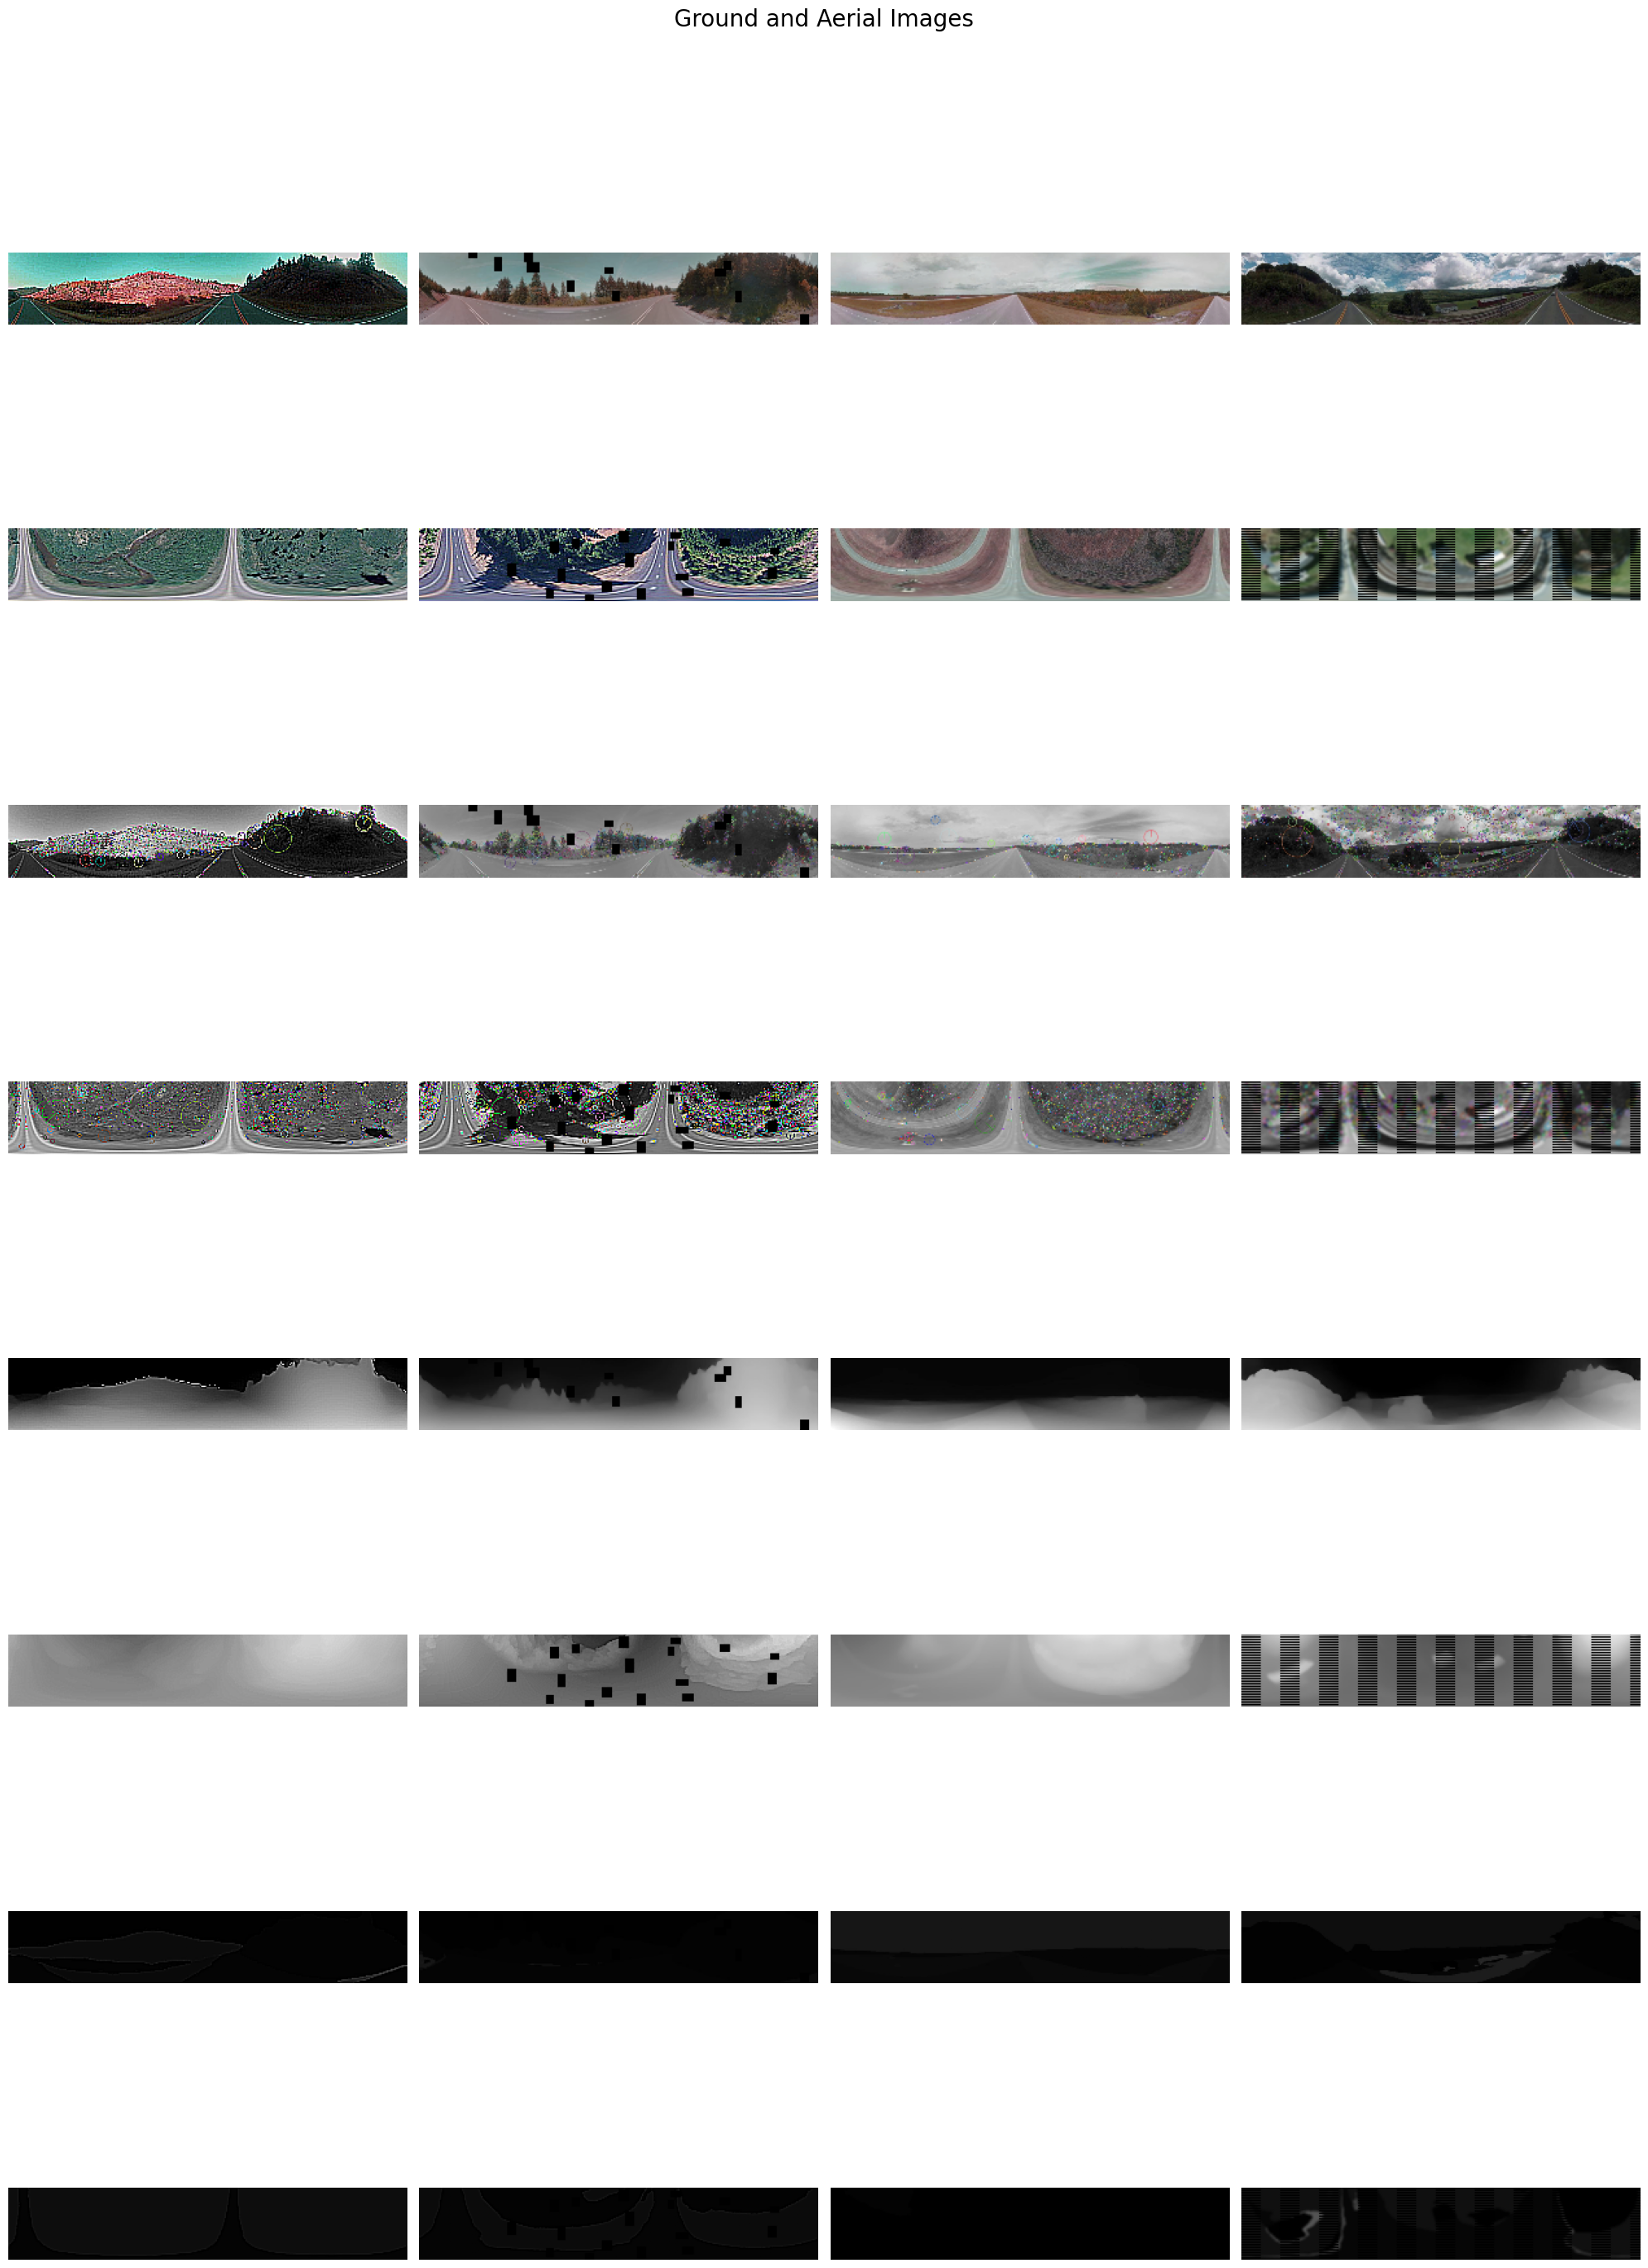

In [55]:
import matplotlib.pyplot as plt

# Function to visualize images from the dataloader
def visualize_dataloader(dataloader):

    batch = next(iter(dataloader))

    ground_images, aerial_images, ground_sift, aerial_sift, ground_depth, aerial_depth, ground_segmap, aerial_segmap = batch

    # Convert tensor to numpy array for visualization
    def to_numpy(tensor):
        return tensor.permute(0, 2, 3, 1).cpu().numpy()

    ground_images = to_numpy(ground_images)
    aerial_images = to_numpy(aerial_images)
    ground_sift = to_numpy(ground_sift)
    aerial_sift = to_numpy(aerial_sift)
    ground_depth = to_numpy(ground_depth)
    aerial_depth = to_numpy(aerial_depth)
    ground_segmap = to_numpy(ground_segmap)
    aerial_segmap = to_numpy(aerial_segmap)

    # Visualize images
    num_images = 4  # Number of images to display
    fig, axes = plt.subplots(8, num_images, figsize=(num_images * 5, 30))
    fig.suptitle('Ground and Aerial Images', fontsize=20)

    for i in range(num_images):
        axes[0, i].imshow(ground_images[i])
        axes[0, i].axis('off')
        axes[0, i].set_aspect('equal')
        axes[1, i].imshow(aerial_images[i])
        axes[1, i].axis('off')
        axes[1, i].set_aspect('equal')
        axes[2, i].imshow(ground_sift[i])
        axes[2, i].axis('off')
        axes[2, i].set_aspect('equal')
        axes[3, i].imshow(aerial_sift[i])
        axes[3, i].axis('off')
        axes[3, i].set_aspect('equal')
        axes[4, i].imshow(ground_depth[i], cmap='gray')
        axes[4, i].axis('off')
        axes[4, i].set_aspect('equal')
        axes[5, i].imshow(aerial_depth[i], cmap='gray')
        axes[5, i].axis('off')
        axes[5, i].set_aspect('equal')
        axes[6, i].imshow(ground_segmap[i], cmap='jet')
        axes[6, i].axis('off')
        axes[6, i].set_aspect('equal')
        axes[7, i].imshow(aerial_segmap[i], cmap='jet')
        axes[7, i].axis('off')
        axes[7, i].set_aspect('equal')

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

# Visualize a batch from the train dataloader
visualize_dataloader(dataloader)



